In [1]:
pip install numpy pandas pyquaternion scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

# --- AYARLAR ---
# Veri setinin bulunduğu ana klasör
BASE_DATASET_FOLDER = ""
# Analiz edilecek hareket
MOVEMENT_TO_ANALYZE = ""
# Analize dahil edilecek kullanıcılar
USERS_TO_ANALYZE = ["User-A","User-B","User-C", "User-D", "User-E"]

# Grafiklerin daha güzel görünmesi için stil ayarı
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk") # Grafikleri daha okunaklı yapar
print("Kütüphaneler ve ayarlar hazır.")

Kütüphaneler ve ayarlar hazır.


In [3]:
# --- VERİ İŞLEME FONKSİYONLARI ---
def reshape_from_pkl(frames_list):
    """
    .pkl'den okunan 'düz' listeyi, her sensör için bir DataFrame
    içeren bir listeye dönüştürür.
    """
    num_sensors = 10
    all_sensor_data = []
    for frame in frames_list:
        frame_sensors = []
        if len(frame) == num_sensors * 4:
            for i in range(num_sensors):
                x, y, z, w = frame[i*4:i*4+4]
                frame_sensors.append({'w': w, 'x': x, 'y': y, 'z': z})
            all_sensor_data.append(frame_sensors)
    
    sensor_data_frames = []
    for i in range(num_sensors):
        sensor_i_timeseries = [frame[i] for frame in all_sensor_data]
        sensor_data_frames.append(pd.DataFrame(sensor_i_timeseries))
    return sensor_data_frames

def normalize_movement(movement_data_list, npose_data_list):
    """
    Bir hareket kaydını, verilen N-Pose referansına göre normalize eder.
    """
    if not movement_data_list or not npose_data_list: return None
    normalized_movement = []
    for i in range(len(movement_data_list)):
        q_ref_row = npose_data_list[i].iloc[0]
        q_ref = Quaternion(w=q_ref_row['w'], x=q_ref_row['x'], y=q_ref_row['y'], z=q_ref_row['z'])
        q_ref_inverse = q_ref.inverse
        
        normalized_frames = []
        for row in movement_data_list[i].itertuples():
            live_quat = Quaternion(w=row.w, x=row.x, y=row.y, z=row.z)
            normalized_quat = q_ref_inverse * live_quat
            normalized_frames.append({
                'w': normalized_quat.w, 'x': normalized_quat.x,
                'y': normalized_quat.y, 'z': normalized_quat.z
            })
            
        normalized_df = pd.DataFrame(normalized_frames)
        normalized_movement.append(normalized_df)
    return normalized_movement

# --- ANA VERİ YÜKLEME KODU ---
all_movements = []
print(f"'{MOVEMENT_TO_ANALYZE}' hareketi için veri yükleniyor...")

for user_id in USERS_TO_ANALYZE:
    user_path = os.path.join(BASE_DATASET_FOLDER, MOVEMENT_TO_ANALYZE, user_id)
    if not os.path.isdir(user_path):
        print(f"UYARI: {user_id} için klasör bulunamadı, atlanıyor.")
        continue
    
    # Her kullanıcı için N-Pose referansını bul
    npose_file = next((f for f in os.listdir(user_path) if f.startswith('npose_')), None)
    if not npose_file:
        print(f"UYARI: {user_id} için N-Pose referans dosyası bulunamadı, atlanıyor.")
        continue

    with open(os.path.join(user_path, npose_file), 'rb') as f:
        npose_reference = reshape_from_pkl(pickle.load(f)['data'])
    
    print(f"-> {user_id} için N-Pose referansı yüklendi.")

    # Kullanıcının tüm etiket klasörlerini tara
    for label_folder in os.listdir(user_path):
        label_path = os.path.join(user_path, label_folder)
        if not os.path.isdir(label_path): continue
        
        for movement_file in os.listdir(label_path):
            if not movement_file.startswith("movement_"): continue
            
            with open(os.path.join(label_path, movement_file), 'rb') as f:
                movement_dict = pickle.load(f)
            
            movement_raw = reshape_from_pkl(movement_dict['data'])
            movement_normalized = normalize_movement(movement_raw, npose_reference)
            
            all_movements.append({
                'data': movement_normalized,
                'label': label_folder, # Klasör adını etiket olarak kullanıyoruz
                'user': user_id
            })

print(f"\nİşlem tamamlandı. Toplam {len(all_movements)} hareket kaydı yüklendi ve normalize edildi.")

'' hareketi için veri yükleniyor...
-> User-A için N-Pose referansı yüklendi.
-> User-B için N-Pose referansı yüklendi.
-> User-C için N-Pose referansı yüklendi.
-> User-D için N-Pose referansı yüklendi.
-> User-E için N-Pose referansı yüklendi.

İşlem tamamlandı. Toplam 300 hareket kaydı yüklendi ve normalize edildi.


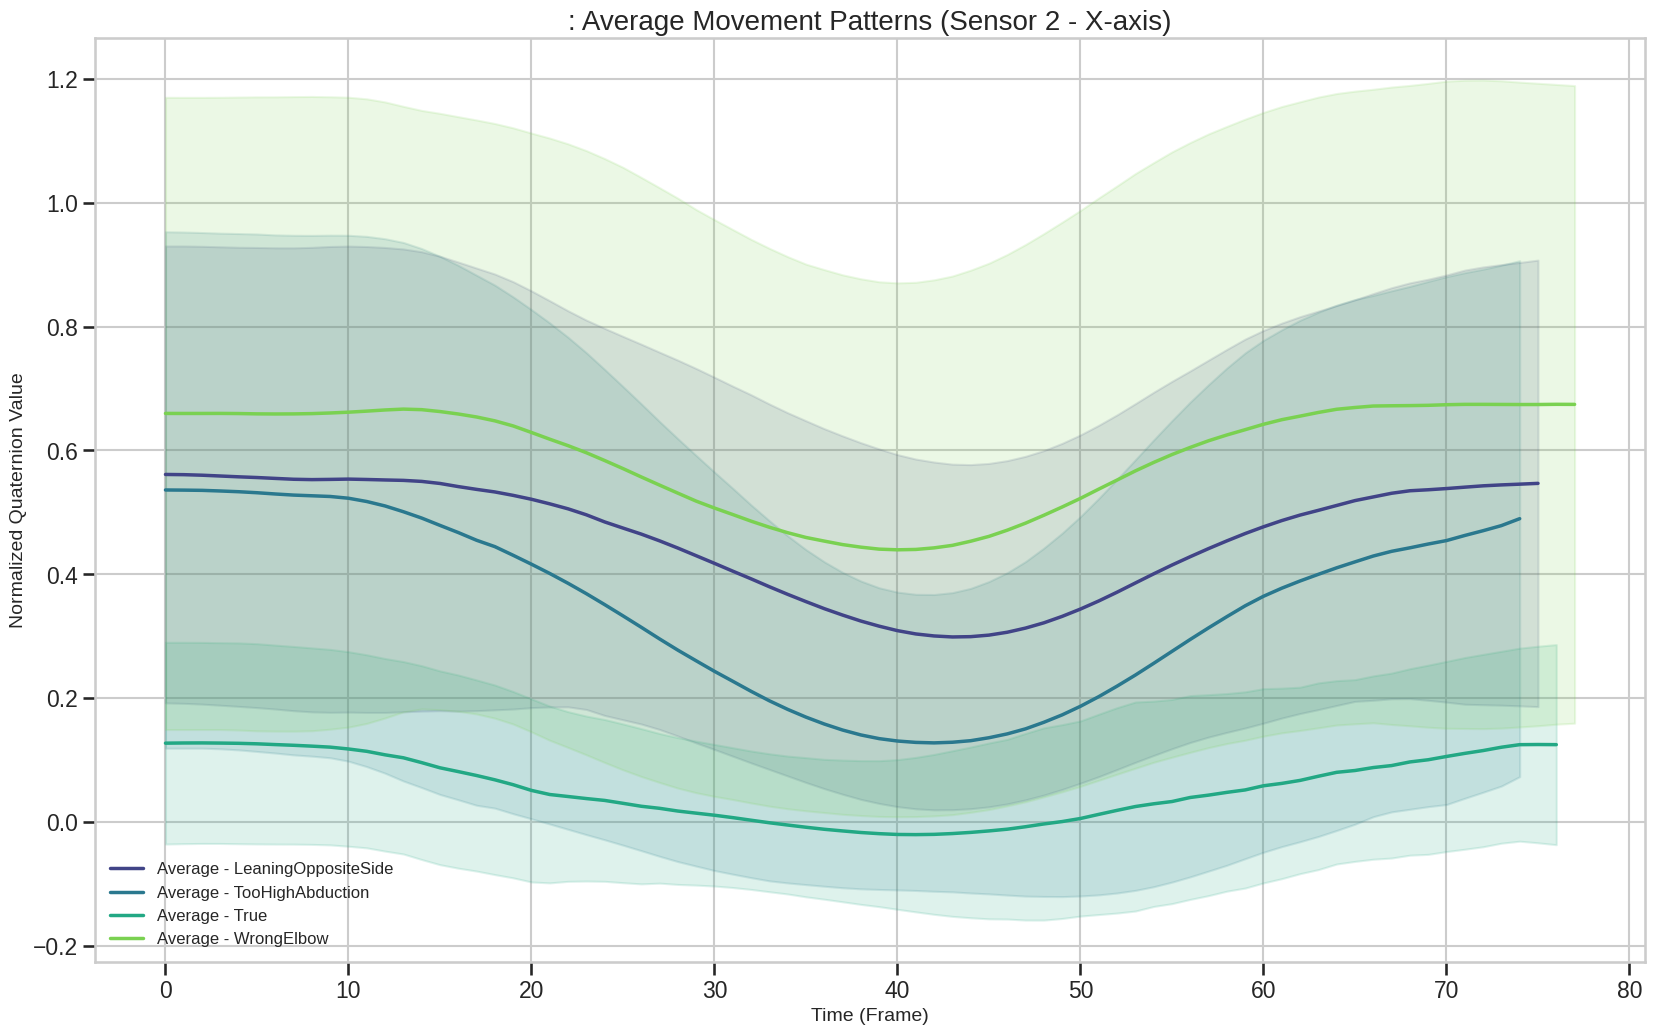

In [4]:
plt.figure(figsize=(20, 12))
ax = plt.gca()
labels = sorted(list(set(m['label'] for m in all_movements)))
colors = sns.color_palette("viridis", len(labels))

# Analiz için en ilgili sensörlerden biri (örneğin sağ üst kol, s2)
SENSOR_TO_PLOT = 1 # Index 1 = Sensor 2
COMPONENT_TO_PLOT = 'x' # x, y, z, w'den biri

for i, label in enumerate(labels):
    series = [m['data'][SENSOR_TO_PLOT][COMPONENT_TO_PLOT].values for m in all_movements if m['label'] == label]
    min_len = min(len(s) for s in series)
    series_padded = [s[:min_len] for s in series]
    mean_series = np.mean(series_padded, axis=0)
    std_series = np.std(series_padded, axis=0)
    
    ax.plot(mean_series, label=f'Average - {label}', color=colors[i], linewidth=2.5)
    ax.fill_between(range(min_len), mean_series - std_series, mean_series + std_series, color=colors[i], alpha=0.15)

ax.set_title(f'{MOVEMENT_TO_ANALYZE}: Average Movement Patterns (Sensor {SENSOR_TO_PLOT+1} - {COMPONENT_TO_PLOT.upper()}-axis)', fontsize=20)
ax.set_xlabel('Time (Frame)', fontsize=14)
ax.set_ylabel('Normalized Quaternion Value', fontsize=14)
ax.legend(fontsize=12)
plt.show()

In [5]:
def get_statistical_features(timeseries):
    return {'mean': np.mean(timeseries), 'std': np.std(timeseries), 'min': np.min(timeseries), 'max': np.max(timeseries), 'range': np.max(timeseries) - np.min(timeseries)}

def get_quaternion_features(quat_df, prefix):
    features = {}
    for component in ['w', 'x', 'y', 'z']:
        stats = get_statistical_features(quat_df[component])
        for stat_name, value in stats.items(): features[f'{prefix}_{component}_{stat_name}'] = value
    return features

def calculate_relative_quaternions(df1, df2):
    relative_frames = []
    for i in range(len(df1)):
        q1 = Quaternion(w=df1.iloc[i]['w'], x=df1.iloc[i]['x'], y=df1.iloc[i]['y'], z=df1.iloc[i]['z'])
        q2 = Quaternion(w=df2.iloc[i]['w'], x=df2.iloc[i]['x'], y=df2.iloc[i]['y'], z=df2.iloc[i]['z'])
        relative_q = q2.inverse * q1
        relative_frames.append({'w': relative_q.w, 'x': relative_q.x, 'y': relative_q.y, 'z': relative_q.z})
    return pd.DataFrame(relative_frames)

def extract_features_for_movement(normalized_data):
    all_features = {}
    for i, sensor_df in enumerate(normalized_data): all_features.update(get_quaternion_features(sensor_df, f's{i+1}'))
    all_features.update(get_quaternion_features(calculate_relative_quaternions(normalized_data[1], normalized_data[4]), 'rel_s2_s5'))
    all_features.update(get_quaternion_features(calculate_relative_quaternions(normalized_data[0], normalized_data[1]), 'rel_s1_s2'))
    all_features.update(get_quaternion_features(calculate_relative_quaternions(normalized_data[2], normalized_data[7]), 'rel_s3_s8'))
    return all_features

print("Özellik çıkarımı başlıyor...")
feature_list = []
for movement in all_movements:
    features = extract_features_for_movement(movement['data'])
    features['label'] = movement['label']
    features['user'] = movement['user']
    feature_list.append(features)

features_df = pd.DataFrame(feature_list)
print(f"Özellik çıkarımı tamamlandı. {features_df.shape[0]} kayıt için toplam {features_df.shape[1]-2} özellik oluşturuldu.")
features_df.head()

Özellik çıkarımı başlıyor...
Özellik çıkarımı tamamlandı. 300 kayıt için toplam 260 özellik oluşturuldu.


s1_w_mean  s1_w_std  s1_w_min  s1_w_max  s1_w_range  s1_x_mean  s1_x_std  \
0   0.817820  0.137918  0.554828  0.970500    0.415672   0.245348  0.092293   
1   0.810271  0.136600  0.553852  0.952247    0.398395   0.262962  0.086782   
2   0.784331  0.150035  0.509382  0.942024    0.432642   0.263234  0.078642   
3   0.781929  0.140404  0.530612  0.943206    0.412593   0.287948  0.082952   
4   0.815392  0.121550  0.607881  0.956899    0.349018   0.272856  0.080675   

   s1_x_min  s1_x_max  s1_x_range  ...  rel_s3_s8_y_min  rel_s3_s8_y_max  \
0  0.125802  0.395752    0.269950  ...         0.690109         0.742182   
1  0.146297  0.410529    0.264233  ...         0.713789         0.773737   
2  0.153318  0.379978    0.226659  ...         0.738033         0.790441   
3  0.169796  0.412173    0.242378  ...         0.731782         0.794862   
4  0.147060  0.389435    0.242376  ...         0.754943         0.806984   

   rel_s3_s8_y_range  rel_s3_s8_z_mean  rel_s3_s8_z_std  rel_s3_s8_z_min  \
0           0.052073         -0.421306         0.072401        -0.500115   
1           0.059948         -0.435801         0.078094        -0.536898   
2           0.052408         -0.421979         0.066527        -0.503078   
3           0.063079         -0.434596         0.069200        -0.516149   
4           0.052041         -0.428898         0.071427        -0.502645   

   rel_s3_s8_z_max  rel_s3_s8_z_range                label    user  
0        -0.259473           0.240642  LeaningOppositeSide  User-A  
1        -0.261691           0.275207  LeaningOppositeSide  User-A  
2        -0.274711           0.228368  LeaningOppositeSide  User-A  
3        -0.291562           0.224588  LeaningOppositeSide  User-A  
4        -0.251522           0.251123  LeaningOppositeSide  User-A  

[5 rows x 262 columns]

PCA - Açıklanan Varyans Oranı: 45.37%
t-SNE analizi başlıyor (biraz sürebilir)...
t-SNE analizi tamamlandı.


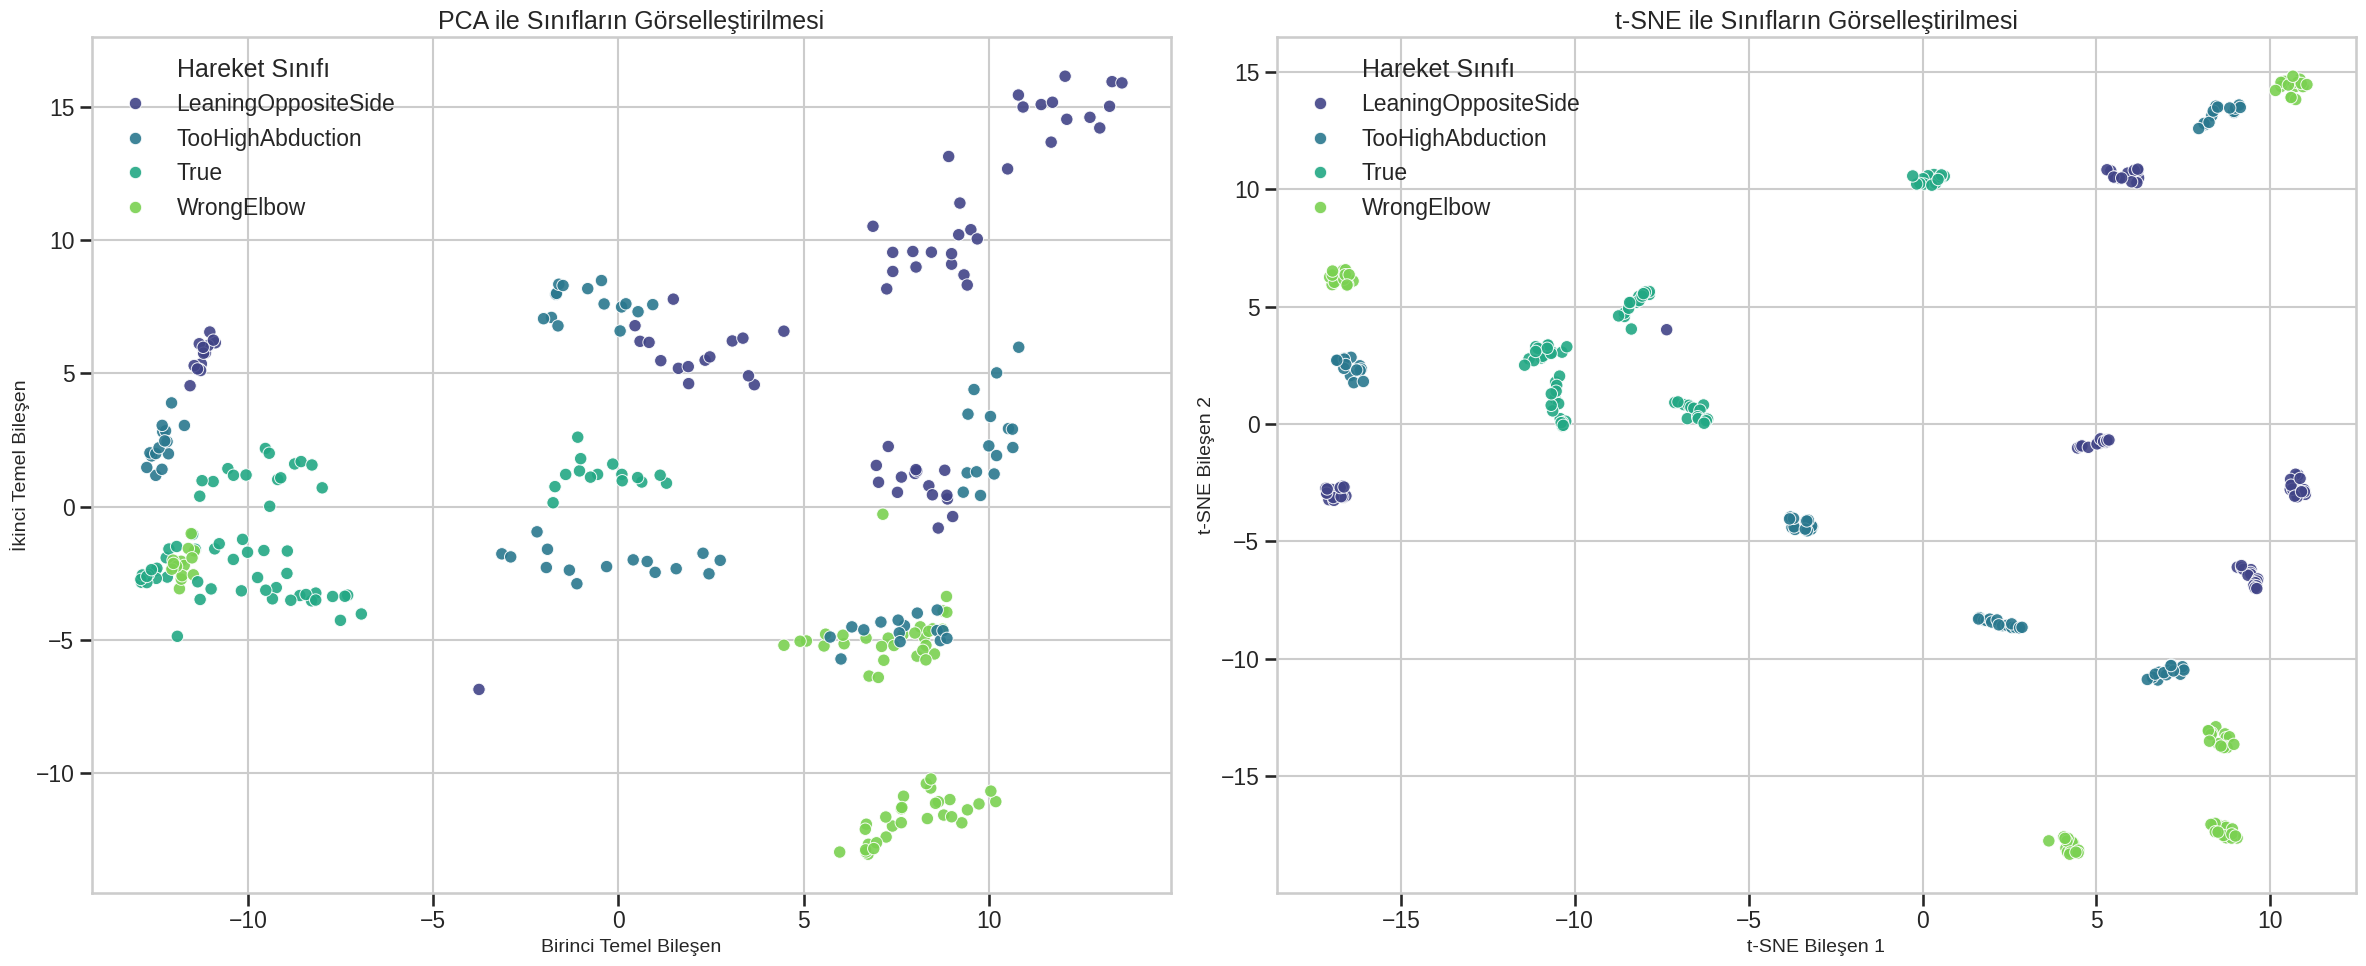

In [6]:
# Özellikleri (X) ve etiketleri (y) ayır
X = features_df.drop(['label', 'user'], axis=1)
y = features_df['label']

# Özellikleri ölçeklendir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- PCA Analizi ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA - Açıklanan Varyans Oranı: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# --- t-SNE Analizi ---
print("t-SNE analizi başlıyor (biraz sürebilir)...")
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

print("t-SNE analizi tamamlandı.")


# Sonuçları tek bir figürde yan yana göster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# PCA Grafiği
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', s=80, alpha=0.9, ax=ax1)
ax1.set_title('PCA ile Sınıfların Görselleştirilmesi', fontsize=18)
ax1.set_xlabel('Birinci Temel Bileşen', fontsize=14)
ax1.set_ylabel('İkinci Temel Bileşen', fontsize=14)
ax1.legend(title='Hareket Sınıfı')
ax1.grid(True)

# t-SNE Grafiği
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', s=80, alpha=0.9, ax=ax2)
ax2.set_title('t-SNE ile Sınıfların Görselleştirilmesi', fontsize=18)
ax2.set_xlabel('t-SNE Bileşen 1', fontsize=14)
ax2.set_ylabel('t-SNE Bileşen 2', fontsize=14)
ax2.legend(title='Hareket Sınıfı')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [7]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---

=> Test Kullanıcısı: User-A
  - Random Forest: Accuracy = 1.0000, F1-Score = 1.0000
  - SVM: Accuracy = 1.0000, F1-Score = 1.0000


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - XGBoost: Accuracy = 0.7833, F1-Score = 0.7332
  - Logistic Regression: Accuracy = 1.0000, F1-Score = 1.0000

=> Test Kullanıcısı: User-B
  - Random Forest: Accuracy = 0.2500, F1-Score = 0.1000
  - SVM: Accuracy = 0.5000, F1-Score = 0.3333


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - XGBoost: Accuracy = 0.4167, F1-Score = 0.3095
  - Logistic Regression: Accuracy = 0.2500, F1-Score = 0.1000

=> Test Kullanıcısı: User-C
  - Random Forest: Accuracy = 0.9000, F1-Score = 0.8937
  - SVM: Accuracy = 0.2500, F1-Score = 0.1000


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - XGBoost: Accuracy = 0.4000, F1-Score = 0.3320
  - Logistic Regression: Accuracy = 1.0000, F1-Score = 1.0000

=> Test Kullanıcısı: User-D
  - Random Forest: Accuracy = 0.9167, F1-Score = 0.9125
  - SVM: Accuracy = 0.9667, F1-Score = 0.9667


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - XGBoost: Accuracy = 0.8333, F1-Score = 0.8092
  - Logistic Regression: Accuracy = 0.9333, F1-Score = 0.9320

=> Test Kullanıcısı: User-E
  - Random Forest: Accuracy = 1.0000, F1-Score = 1.0000
  - SVM: Accuracy = 0.9000, F1-Score = 0.8958


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - XGBoost: Accuracy = 0.8833, F1-Score = 0.8824
  - Logistic Regression: Accuracy = 1.0000, F1-Score = 1.0000

--- Ortalama Performans Sonuçları ---
                 Model  Average Accuracy  Average F1-Score
3  Logistic Regression          0.836667          0.806395
0        Random Forest          0.813333          0.781249
1                  SVM          0.723333          0.659167
2              XGBoost          0.663333          0.613280


/tmp/ipykernel_7610/3381573698.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average Accuracy', y='Model', data=summary_df, palette='viridis')


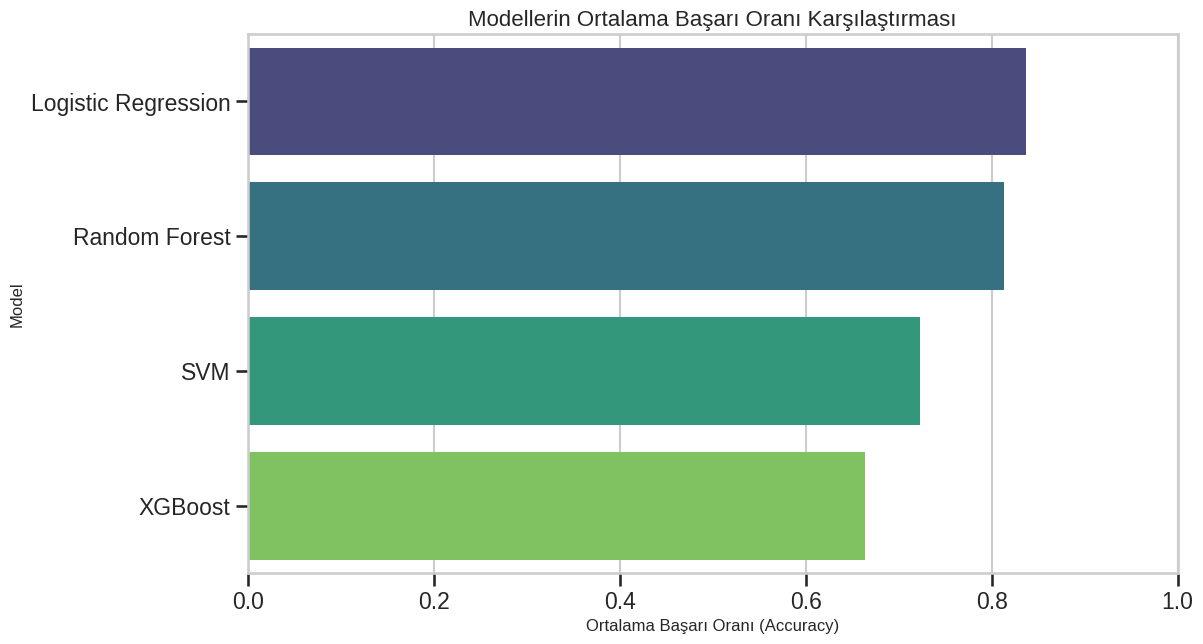


En iyi model 'Logistic Regression' olarak belirlendi.
Bu model şimdi TÜM veri setiyle son bir kez eğitilip kaydediliyor...

--- İşlem Tamamlandı! ---
En iyi model ve diğer bileşenler (scaler, label encoder) başarıyla kaydedildi.


In [8]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Farklı ML Modelleri
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# --- Veriyi Hazırlama ---
# Bir önceki hücrede oluşturduğumuz features_df'i kullanıyoruz
X = features_df.drop(['label', 'user'], axis=1)
y_str = features_df['label']
groups = features_df['user'] # Kullanıcı bazlı ayırma için

# Etiketleri metinden sayılara dönüştür
le = LabelEncoder()
y = le.fit_transform(y_str)

# --- Model ve Değerlendirme Süreci ---
# Modelleri bir sözlükte tanımlayalım
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Her modelin performansını saklamak için bir yapı oluşturalım
results = {name: [] for name in models.keys()}
logo = LeaveOneGroupOut()

print("--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---")

# Her bir kullanıcıyı test seti olarak ayırarak döngüyü başlat
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_user = groups.iloc[test_idx].unique()[0]
    
    print(f"\n=> Test Kullanıcısı: {test_user}")

    # Veriyi ölçeklendir
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Her bir modeli eğit ve test et
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results[name].append({'accuracy': accuracy, 'f1_score': f1})
        print(f"  - {name}: Accuracy = {accuracy:.4f}, F1-Score = {f1:.4f}")

# --- Sonuçları Özetleme ---
print("\n--- Ortalama Performans Sonuçları ---")
summary = []
for name, scores in results.items():
    avg_accuracy = np.mean([s['accuracy'] for s in scores])
    avg_f1 = np.mean([s['f1_score'] for s in scores])
    summary.append({'Model': name, 'Average Accuracy': avg_accuracy, 'Average F1-Score': avg_f1})

summary_df = pd.DataFrame(summary).sort_values('Average F1-Score', ascending=False)
print(summary_df)

# --- Sonuçları Görselleştirme ---
plt.figure(figsize=(12, 7))
sns.barplot(x='Average Accuracy', y='Model', data=summary_df, palette='viridis')
plt.title('Modellerin Ortalama Başarı Oranı Karşılaştırması', fontsize=16)
plt.xlabel('Ortalama Başarı Oranı (Accuracy)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1.0)
plt.show()


# --- En İyi Modeli Seçme ve Kaydetme ---
best_model_name = summary_df.iloc[0]['Model']
print(f"\nEn iyi model '{best_model_name}' olarak belirlendi.")
print("Bu model şimdi TÜM veri setiyle son bir kez eğitilip kaydediliyor...")

# Final modelini tüm veriyle eğit
final_scaler = StandardScaler().fit(X)
X_scaled_final = final_scaler.transform(X)

final_model = models[best_model_name]
final_model.fit(X_scaled_final, y)

# Modeli ve gerekli bileşenleri kaydet
pickle.dump(final_model, open("final_model.pkl", "wb"))
pickle.dump(final_scaler, open("final_scaler.pkl", "wb"))
pickle.dump(le, open("final_label_encoder.pkl", "wb"))

print("\n--- İşlem Tamamlandı! ---")
print("En iyi model ve diğer bileşenler (scaler, label encoder) başarıyla kaydedildi.")

--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---

=> Test Kullanıcısı: User-A
  - Random Forest: Accuracy = 1.0000, F1-Score = 1.0000
  - SVM: Accuracy = 1.0000, F1-Score = 1.0000


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - XGBoost: Accuracy = 0.7833, F1-Score = 0.7332
  - KNN: Accuracy = 0.8500, F1-Score = 0.8466
  - Logistic Regression: Accuracy = 1.0000, F1-Score = 1.0000

=> Test Kullanıcısı: User-B
  - Random Forest: Accuracy = 0.2500, F1-Score = 0.1000
  - SVM: Accuracy = 0.5000, F1-Score = 0.3333


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - XGBoost: Accuracy = 0.4167, F1-Score = 0.3095
  - KNN: Accuracy = 0.2500, F1-Score = 0.1000
  - Logistic Regression: Accuracy = 0.2500, F1-Score = 0.1000

=> Test Kullanıcısı: User-C
  - Random Forest: Accuracy = 0.9000, F1-Score = 0.8937
  - SVM: Accuracy = 0.2500, F1-Score = 0.1000


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - XGBoost: Accuracy = 0.4000, F1-Score = 0.3320
  - KNN: Accuracy = 0.8333, F1-Score = 0.8092
  - Logistic Regression: Accuracy = 1.0000, F1-Score = 1.0000

=> Test Kullanıcısı: User-D
  - Random Forest: Accuracy = 0.9167, F1-Score = 0.9125
  - SVM: Accuracy = 0.9667, F1-Score = 0.9667


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - XGBoost: Accuracy = 0.8333, F1-Score = 0.8092
  - KNN: Accuracy = 0.9667, F1-Score = 0.9666
  - Logistic Regression: Accuracy = 0.9333, F1-Score = 0.9320

=> Test Kullanıcısı: User-E
  - Random Forest: Accuracy = 1.0000, F1-Score = 1.0000
  - SVM: Accuracy = 0.9000, F1-Score = 0.8958


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - XGBoost: Accuracy = 0.8833, F1-Score = 0.8824
  - KNN: Accuracy = 1.0000, F1-Score = 1.0000
  - Logistic Regression: Accuracy = 1.0000, F1-Score = 1.0000

--- Ortalama Performans Sonuçları ---
                 Model  Average Accuracy  Average F1-Score
4  Logistic Regression          0.836667          0.806395
0        Random Forest          0.813333          0.781249
3                  KNN          0.780000          0.744496
1                  SVM          0.723333          0.659167
2              XGBoost          0.663333          0.613280


/tmp/ipykernel_7610/3573633888.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average Accuracy', y='Model', data=summary_df, palette='viridis')


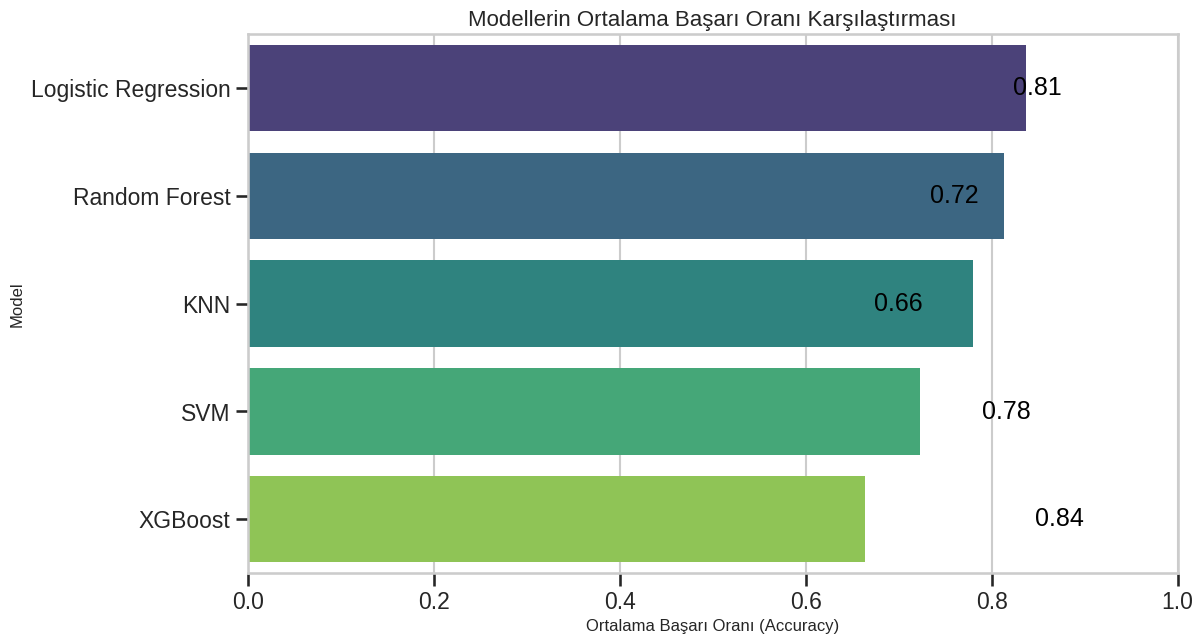


En iyi model 'Logistic Regression' olarak belirlendi.
Bu model şimdi TÜM veri setiyle son bir kez eğitilip kaydediliyor...

--- İşlem Tamamlandı! ---
En iyi model ve diğer bileşenler (scaler, label encoder) başarıyla kaydedildi.


In [9]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Farklı ML Modelleri
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # YENİ: KNN eklendi
from xgboost import XGBClassifier

# --- Veriyi Hazırlama ---
# Bir önceki hücrede oluşturduğumuz features_df'i kullanıyoruz
X = features_df.drop(['label', 'user'], axis=1)
y_str = features_df['label']
groups = features_df['user'] # Kullanıcı bazlı ayırma için

# Etiketleri metinden sayılara dönüştür
le = LabelEncoder()
y = le.fit_transform(y_str)

# --- Model ve Değerlendirme Süreci ---
# Modelleri bir sözlükte tanımlayalım
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5), # YENİ: KNN modeli eklendi (5 komşu ile)
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Her modelin performansını saklamak için bir yapı oluşturalım
results = {name: [] for name in models.keys()}
logo = LeaveOneGroupOut()

print("--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---")

# Her bir kullanıcıyı test seti olarak ayırarak döngüyü başlat
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_user = groups.iloc[test_idx].unique()[0]
    
    print(f"\n=> Test Kullanıcısı: {test_user}")

    # Veriyi ölçeklendir
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Her bir modeli eğit ve test et
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results[name].append({'accuracy': accuracy, 'f1_score': f1})
        print(f"  - {name}: Accuracy = {accuracy:.4f}, F1-Score = {f1:.4f}")

# --- Sonuçları Özetleme ---
print("\n--- Ortalama Performans Sonuçları ---")
summary = []
for name, scores in results.items():
    avg_accuracy = np.mean([s['accuracy'] for s in scores])
    avg_f1 = np.mean([s['f1_score'] for s in scores])
    summary.append({'Model': name, 'Average Accuracy': avg_accuracy, 'Average F1-Score': avg_f1})

summary_df = pd.DataFrame(summary).sort_values('Average F1-Score', ascending=False)
print(summary_df)

# --- Sonuçları Görselleştirme ---
plt.figure(figsize=(12, 7))
sns.barplot(x='Average Accuracy', y='Model', data=summary_df, palette='viridis')
plt.title('Modellerin Ortalama Başarı Oranı Karşılaştırması', fontsize=16)
plt.xlabel('Ortalama Başarı Oranı (Accuracy)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1.0)
for index, row in summary_df.iterrows():
    plt.text(row['Average Accuracy'] + 0.01, index, f"{row['Average Accuracy']:.2f}", color='black', ha="left", va='center')
plt.show()


# --- En İyi Modeli Seçme ve Kaydetme ---
best_model_name = summary_df.iloc[0]['Model']
print(f"\nEn iyi model '{best_model_name}' olarak belirlendi.")
print("Bu model şimdi TÜM veri setiyle son bir kez eğitilip kaydediliyor...")

# Final modelini tüm veriyle eğit
final_scaler = StandardScaler().fit(X)
X_scaled_final = final_scaler.transform(X)

# En iyi modelin yeni bir örneğini oluştur ve eğit
final_model = models[best_model_name] 
final_model.fit(X_scaled_final, y)

# Modeli ve gerekli bileşenleri kaydet
pickle.dump(final_model, open("final_model.pkl", "wb"))
pickle.dump(final_scaler, open("final_scaler.pkl", "wb"))
pickle.dump(le, open("final_label_encoder.pkl", "wb"))

print("\n--- İşlem Tamamlandı! ---")
print("En iyi model ve diğer bileşenler (scaler, label encoder) başarıyla kaydedildi.")

--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---

=> Test Kullanıcısı: User-A


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=> Test Kullanıcısı: User-B


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=> Test Kullanıcısı: User-C


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=> Test Kullanıcısı: User-D


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=> Test Kullanıcısı: User-E


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:20:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Ortalama Performans Sonuçları ---
                 Model  Average Accuracy  Average F1-Score
4  Logistic Regression          0.836667          0.806395
0        Random Forest          0.813333          0.781249
3                  KNN          0.780000          0.744496
1                  SVM          0.723333          0.659167
2              XGBoost          0.663333          0.613280

--- En İyi Model için Detaylı Analiz: Logistic Regression ---
✅ Karmaşıklık Matrisi kaydedildi: confusion_matrix_User-A.png
✅ Karmaşıklık Matrisi kaydedildi: confusion_matrix_User-B.png
✅ Karmaşıklık Matrisi kaydedildi: confusion_matrix_User-C.png
✅ Karmaşıklık Matrisi kaydedildi: confusion_matrix_User-D.png
✅ Karmaşıklık Matrisi kaydedildi: confusion_matrix_User-E.png


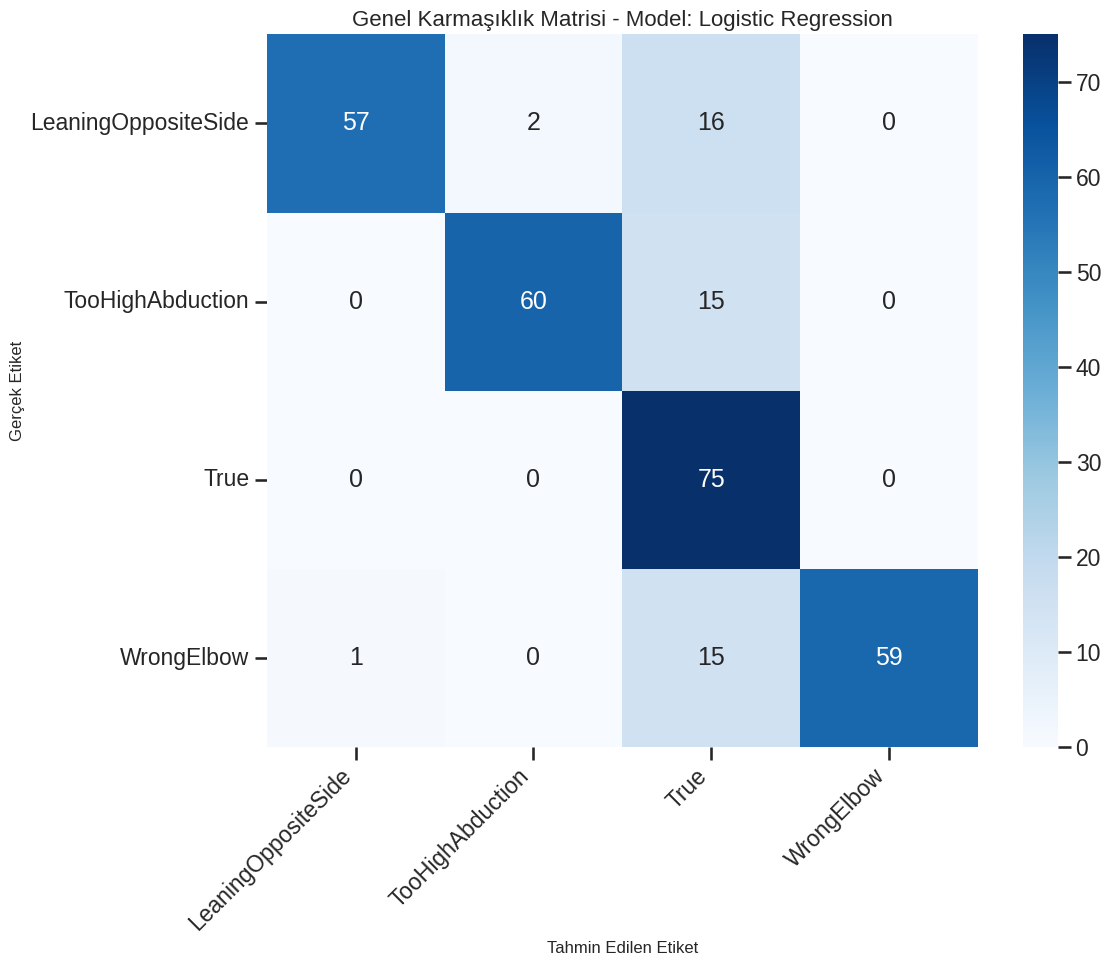

✅ Genel Karmaşıklık Matrisi kaydedildi: confusion_matrix_OVERALL.png

Genel Sınıflandırma Raporu:
                     precision    recall  f1-score   support

LeaningOppositeSide       0.98      0.76      0.86        75
   TooHighAbduction       0.97      0.80      0.88        75
               True       0.62      1.00      0.77        75
         WrongElbow       1.00      0.79      0.88        75

           accuracy                           0.84       300
          macro avg       0.89      0.84      0.84       300
       weighted avg       0.89      0.84      0.84       300


En iyi model 'Logistic Regression' tüm veriyle son kez eğitilip kaydediliyor...
Final modeli ve bileşenleri başarıyla kaydedildi.


In [10]:
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Farklı ML Modelleri
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# --- Veriyi Hazırlama ---
# Bir önceki hücrede oluşturduğumuz features_df'i kullanıyoruz
X = features_df.drop(['label', 'user'], axis=1)
y_str = features_df['label']
groups = features_df['user']

le = LabelEncoder()
y = le.fit_transform(y_str)

# --- Model ve Değerlendirme Süreci ---
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

results = {name: [] for name in models.keys()}
# YENİ: Her bir kullanıcının test sonuçlarını (doğru ve tahmin edilen) saklamak için
fold_predictions = {name: [] for name in models.keys()}
logo = LeaveOneGroupOut()

print("--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---")

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_user = groups.iloc[test_idx].unique()[0]
    
    print(f"\n=> Test Kullanıcısı: {test_user}")
    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)
    
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results[name].append({'accuracy': accuracy, 'f1_score': f1})
        
        # YENİ: Bu kullanıcının test sonuçlarını sakla
        fold_predictions[name].append({'user': test_user, 'true': y_test, 'pred': y_pred})

# --- Sonuçları Özetleme ---
print("\n--- Ortalama Performans Sonuçları ---")
summary = [{'Model': name, 
            'Average Accuracy': np.mean([s['accuracy'] for s in scores]), 
            'Average F1-Score': np.mean([s['f1_score'] for s in scores])}
           for name, scores in results.items()]
summary_df = pd.DataFrame(summary).sort_values('Average F1-Score', ascending=False)
print(summary_df)
best_model_name = summary_df.iloc[0]['Model']

# --- YENİ BÖLÜM: DETAYLI KARMAŞIKLIK MATRİSLERİ ---
print(f"\n--- En İyi Model için Detaylı Analiz: {best_model_name} ---")

# Her bir kullanıcı için ayrı ayrı Confusion Matrix oluştur
all_true_labels = []
all_pred_labels = []

for fold in fold_predictions[best_model_name]:
    user = fold['user']
    y_true_user = fold['true']
    y_pred_user = fold['pred']
    
    all_true_labels.extend(y_true_user)
    all_pred_labels.extend(y_pred_user)
    
    # Kullanıcıya özel matrisi çizdir
    cm_user = confusion_matrix(y_true_user, y_pred_user, labels=np.arange(len(le.classes_)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_user, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Karmaşıklık Matrisi - Test: {user} (Model: {best_model_name})')
    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmin Edilen Etiket')
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    cm_filename = f'confusion_matrix_{user}.png'
    plt.savefig(cm_filename)
    plt.close() # Grafiği gösterimden kaldır
    print(f"✅ Karmaşıklık Matrisi kaydedildi: {cm_filename}")

# En iyi modelin genel performansını gösteren tek bir büyük Confusion Matrix
cm_overall = confusion_matrix(all_true_labels, all_pred_labels, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(12, 10))
sns.heatmap(cm_overall, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Genel Karmaşıklık Matrisi - Model: {best_model_name}', fontsize=16)
plt.ylabel('Gerçek Etiket', fontsize=12)
plt.xlabel('Tahmin Edilen Etiket', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
cm_overall_filename = 'confusion_matrix_OVERALL.png'
plt.savefig(cm_overall_filename)
plt.show() # Genel matrisi göster
print(f"✅ Genel Karmaşıklık Matrisi kaydedildi: {cm_overall_filename}")

print("\nGenel Sınıflandırma Raporu:")
print(classification_report(all_true_labels, all_pred_labels, target_names=le.classes_, zero_division=0))

# --- Final Modelini Kaydetme ---
print(f"\nEn iyi model '{best_model_name}' tüm veriyle son kez eğitilip kaydediliyor...")
final_scaler = StandardScaler().fit(X)
X_scaled_final = final_scaler.transform(X)

# En iyi modelin yeni bir örneğini oluştur ve tüm veriyle eğit
final_model_instance = models[best_model_name]
final_model_instance.fit(X_scaled_final, y)

pickle.dump(final_model_instance, open("final_model.pkl", "wb"))
pickle.dump(final_scaler, open("final_scaler.pkl", "wb"))
pickle.dump(le, open("final_label_encoder.pkl", "wb"))
print("Final modeli ve bileşenleri başarıyla kaydedildi.")



--- KNN için Hiperparametre Optimizasyonu Başlıyor ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- KNN Optimizasyonu Tamamlandı ---
En iyi KNN parametreleri bulundu:
{'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
Bu parametrelerle elde edilen en iyi F1 Skoru: 0.7864

En iyi KNN modelinin performansı çapraz doğrulama ile tekrar test ediliyor...


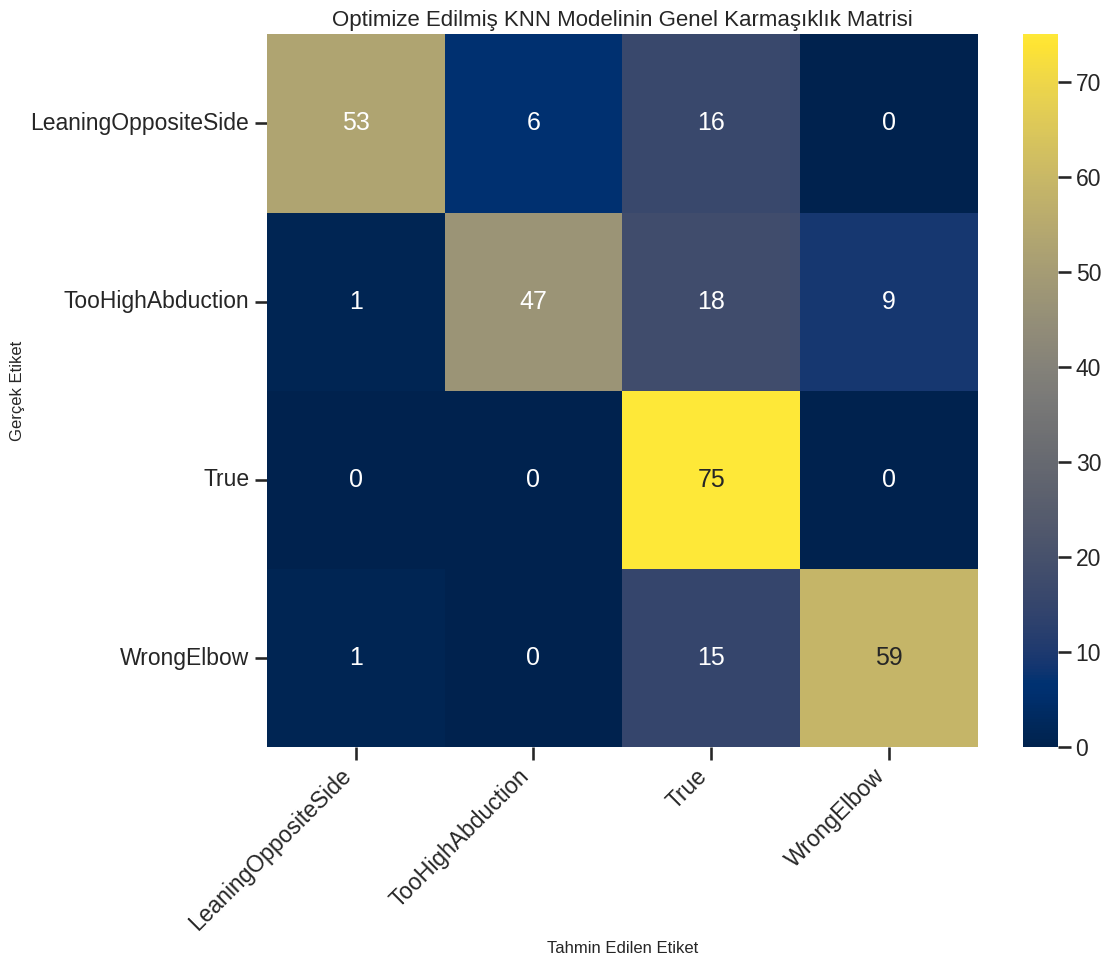


Optimize Edilmiş KNN Modelinin Genel Sınıflandırma Raporu:
                     precision    recall  f1-score   support

LeaningOppositeSide       0.96      0.71      0.82        75
   TooHighAbduction       0.89      0.63      0.73        75
               True       0.60      1.00      0.75        75
         WrongElbow       0.87      0.79      0.83        75

           accuracy                           0.78       300
          macro avg       0.83      0.78      0.78       300
       weighted avg       0.83      0.78      0.78       300


Final modeli (en iyi KNN) şimdi TÜM veriyle son kez eğitilip kaydediliyor...

--- İşlem Tamamlandı! ---
Optimize edilmiş en iyi KNN modeli ve diğer bileşenler başarıyla kaydedildi.


In [11]:
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# --- Veriyi Hazırlama ---
# features_df'in bir önceki hücrede oluşturulduğunu varsayıyoruz
X = features_df.drop(['label', 'user'], axis=1)
y_str = features_df['label']
groups = features_df['user']

le = LabelEncoder()
y = le.fit_transform(y_str)

# --- KNN Hiperparametre Optimizasyonu (Grid Search) ---

print("--- KNN için Hiperparametre Optimizasyonu Başlıyor ---")

# Denenecek parametrelerin bir "ızgarasını" oluştur
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],            # Kaç komşuya bakılacağı (genellikle tek sayılar tercih edilir)
    'weights': ['uniform', 'distance'],     # 'uniform': tüm komşular eşit oy hakkına sahip. 'distance': yakın komşular daha etkili.
    'metric': ['minkowski', 'euclidean', 'manhattan'] # Mesafe hesaplama yöntemleri
}

# Modeli ve çapraz doğrulama stratejisini tanımla
knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

# GridSearchCV'yi ayarla
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=logo, 
                               scoring='f1_weighted', verbose=2, n_jobs=-1)

# Veriyi ölçeklendir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Grid Search'ü başlat
grid_search_knn.fit(X_scaled, y, groups=groups)

print("\n--- KNN Optimizasyonu Tamamlandı ---")
print("En iyi KNN parametreleri bulundu:")
print(grid_search_knn.best_params_)
print(f"Bu parametrelerle elde edilen en iyi F1 Skoru: {grid_search_knn.best_score_:.4f}")

# --- En İyi Modeli Değerlendirme ve Kaydetme ---
best_knn_model = grid_search_knn.best_estimator_
print("\nEn iyi KNN modelinin performansı çapraz doğrulama ile tekrar test ediliyor...")

y_pred_overall_knn = np.array(y)
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    scaler_fold = StandardScaler().fit(X_train)
    X_train_scaled_fold, X_test_scaled_fold = scaler_fold.transform(X_train), scaler_fold.transform(X_test)
    
    best_knn_model.fit(X_train_scaled_fold, y_train)
    y_pred_fold = best_knn_model.predict(X_test_scaled_fold)
    y_pred_overall_knn[test_idx] = y_pred_fold

# Genel Karmaşıklık Matrisini çizdir
cm_knn = confusion_matrix(y, y_pred_overall_knn, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(12, 10))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='cividis',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Optimize Edilmiş KNN Modelinin Genel Karmaşıklık Matrisi', fontsize=16)
plt.ylabel('Gerçek Etiket', fontsize=12)
plt.xlabel('Tahmin Edilen Etiket', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nOptimize Edilmiş KNN Modelinin Genel Sınıflandırma Raporu:")
print(classification_report(y, y_pred_overall_knn, target_names=le.classes_, zero_division=0))

# --- Önceki En İyi Model ile Karşılaştırma ---
# Bir önceki script'ten gelen sonucu buraya yazarak karşılaştırabiliriz.
# Örn: best_rf_score = 0.78
# if grid_search_knn.best_score_ > best_rf_score:
#     print("KNN, Random Forest'tan daha iyi bir performans gösterdi.")
# else:
#     print("Random Forest, KNN'den daha iyi bir performans gösterdi.")

# --- Final Modelini Kaydetme ---
print("\nFinal modeli (en iyi KNN) şimdi TÜM veriyle son kez eğitilip kaydediliyor...")
final_scaler.fit(X) # Zaten tanımlı scaler'ı kullanabiliriz
X_scaled_final = final_scaler.transform(X)
best_knn_model.fit(X_scaled_final, y)

pickle.dump(best_knn_model, open("final_optimized_knn_model.pkl", "wb"))
pickle.dump(final_scaler, open("final_scaler.pkl", "wb")) # Scaler aynı kalabilir
pickle.dump(le, open("final_label_encoder.pkl", "wb")) # Label Encoder aynı kalabilir

print("\n--- İşlem Tamamlandı! ---")
print("Optimize edilmiş en iyi KNN modeli ve diğer bileşenler başarıyla kaydedildi.")

'' hareketi için YENİ normalizasyon ile veri yükleniyor...
-> User-A işleniyor...
-> User-B işleniyor...
-> User-C işleniyor...
-> User-D işleniyor...
-> User-E işleniyor...

İşlem tamamlandı. Toplam 300 hareket yeni yöntemle normalize edildi.

Yeni normalize edilmiş veri ile özellik çıkarımı başlıyor...
Özellik çıkarımı tamamlandı.

--- 'İlk An'a Göre Normalizasyon' ile Random Forest Performansı ---


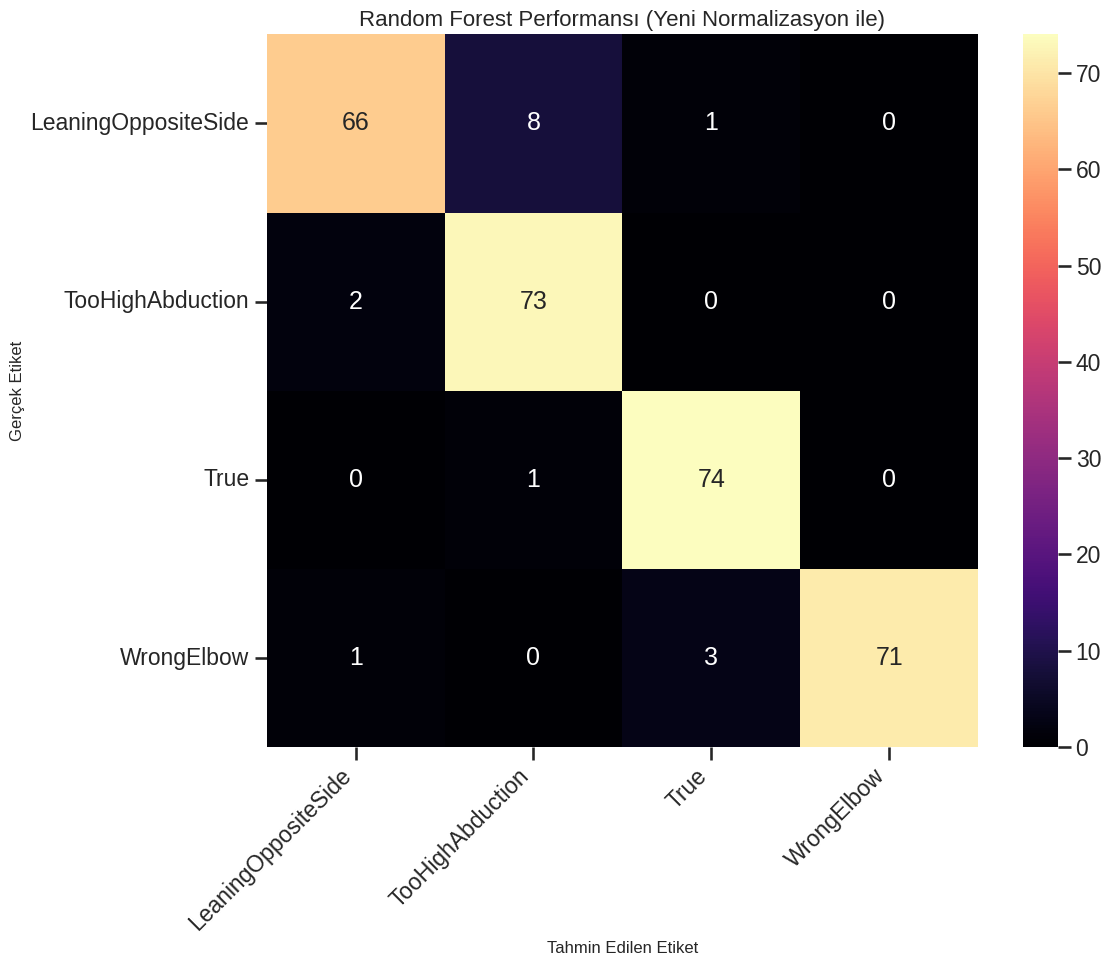


Random Forest Sınıflandırma Raporu (Yeni Normalizasyon ile):
                     precision    recall  f1-score   support

LeaningOppositeSide       0.96      0.88      0.92        75
   TooHighAbduction       0.89      0.97      0.93        75
               True       0.95      0.99      0.97        75
         WrongElbow       1.00      0.95      0.97        75

           accuracy                           0.95       300
          macro avg       0.95      0.95      0.95       300
       weighted avg       0.95      0.95      0.95       300



In [12]:
import os
import pickle
import numpy as np
import pandas as pd
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- AYARLAR ---
BASE_DATASET_FOLDER = ""
MOVEMENT_TO_ANALYZE = ""
USERS_TO_ANALYZE = ["User-A", "User-B", "User-C", "User-D", "User-E"]

# --- YENİ NORMALİZASYON MANTIĞI ---

def normalize_by_first_frame(movement_data_list):
    """
    Bir hareket kaydını, ayrı bir referans dosyası yerine
    kendi ilk anına göre normalize eder.
    """
    if not movement_data_list: return None
    
    # Referans olarak hareketin kendisini kullan
    npose_data_list = movement_data_list 
    
    normalized_movement = []
    for i in range(len(movement_data_list)):
        q_ref_row = npose_data_list[i].iloc[0]
        q_ref = Quaternion(w=q_ref_row['w'], x=q_ref_row['x'], y=q_ref_row['y'], z=q_ref_row['z'])
        q_ref_inverse = q_ref.inverse
        
        normalized_frames = []
        for row in movement_data_list[i].itertuples():
            live_quat = Quaternion(w=row.w, x=row.x, y=row.y, z=row.z)
            normalized_quat = q_ref_inverse * live_quat
            normalized_frames.append({'w': normalized_quat.w, 'x': normalized_quat.x, 'y': normalized_quat.y, 'z': normalized_quat.z})
            
        normalized_movement.append(pd.DataFrame(normalized_frames))
    return normalized_movement

# --- VERİ YÜKLEME VE YENİ NORMALİZASYON ---
all_movements_new_norm = []
print(f"'{MOVEMENT_TO_ANALYZE}' hareketi için YENİ normalizasyon ile veri yükleniyor...")

for user_id in USERS_TO_ANALYZE:
    user_path = os.path.join(BASE_DATASET_FOLDER, MOVEMENT_TO_ANALYZE, user_id)
    if not os.path.isdir(user_path): continue
    
    print(f"-> {user_id} işleniyor...")
    for label_folder in os.listdir(user_path):
        label_path = os.path.join(user_path, label_folder)
        if not os.path.isdir(label_path) or label_folder.startswith('tpose'): continue
        
        for movement_file in os.listdir(label_path):
            if not movement_file.startswith("movement_"): continue
            
            with open(os.path.join(label_path, movement_file), 'rb') as f:
                movement_dict = pickle.load(f)
            
            movement_raw = reshape_from_pkl(movement_dict['data'])
            # DİKKAT: normalize_by_first_frame fonksiyonu çağrılıyor
            movement_normalized = normalize_by_first_frame(movement_raw) 
            
            all_movements_new_norm.append({'data': movement_normalized, 'label': label_folder, 'user': user_id})

print(f"\nİşlem tamamlandı. Toplam {len(all_movements_new_norm)} hareket yeni yöntemle normalize edildi.")

# --- ÖZELLİK ÇIKARIMI VE MODELLEME ---
print("\nYeni normalize edilmiş veri ile özellik çıkarımı başlıyor...")
feature_list_new_norm = []
for movement in all_movements_new_norm:
    features = extract_features_for_movement(movement['data']) # Bu fonksiyon öncekiyle aynı
    features['label'] = movement['label']
    features['user'] = movement['user']
    feature_list_new_norm.append(features)

features_df_new_norm = pd.DataFrame(feature_list_new_norm)
print("Özellik çıkarımı tamamlandı.")

# Özellikleri (X) ve etiketleri (y) ayır
X = features_df.drop(['label', 'user'], axis=1)
y = features_df['label']

# Özellikleri ölçeklendir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# --- RANDOM FOREST İLE TEST ---
X_new = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_new = features_df_new_norm['label']
groups_new = features_df_new_norm['user']
le_new = LabelEncoder().fit(y_str_new)
y_new = le_new.transform(y_str_new)

print("\n--- 'İlk An'a Göre Normalizasyon' ile Random Forest Performansı ---")
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
logo = LeaveOneGroupOut()
y_pred_overall_rf = np.array(y_new)

for train_idx, test_idx in logo.split(X_new, y_new, groups_new):
    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y_new[train_idx], y_new[test_idx]
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)
    
    model_rf.fit(X_train_scaled, y_train)
    y_pred_fold = model_rf.predict(X_test_scaled)
    y_pred_overall_rf[test_idx] = y_pred_fold

# Sonuçları göster
cm_rf = confusion_matrix(y_new, y_pred_overall_rf, labels=np.arange(len(le_new.classes_)))
plt.figure(figsize=(12, 10))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='magma',
            xticklabels=le_new.classes_, yticklabels=le_new.classes_)
plt.title("Random Forest Performansı (Yeni Normalizasyon ile)", fontsize=16)
plt.ylabel('Gerçek Etiket', fontsize=12)
plt.xlabel('Tahmin Edilen Etiket', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nRandom Forest Sınıflandırma Raporu (Yeni Normalizasyon ile):")
print(classification_report(y_new, y_pred_overall_rf, target_names=le_new.classes_, zero_division=0))

In [28]:
import os
import pickle
import numpy as np
import pandas as pd
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- AYARLAR ---
BASE_DATASET_FOLDER = ""
MOVEMENT_TO_ANALYZE = ""
USERS_TO_ANALYZE = ["User-A", "User-B", "User-C", "User-D", "User-E"]

# --- YENİ NORMALİZASYON MANTIĞI ---

def normalize_by_first_frame(movement_data_list):
    """
    Bir hareket kaydını, ayrı bir referans dosyası yerine
    kendi ilk anına göre normalize eder.
    """
    if not movement_data_list: return None
    
    # Referans olarak hareketin kendisini kullan
    npose_data_list = movement_data_list 
    
    normalized_movement = []
    for i in range(len(movement_data_list)):
        q_ref_row = npose_data_list[i].iloc[0]
        q_ref = Quaternion(w=q_ref_row['w'], x=q_ref_row['x'], y=q_ref_row['y'], z=q_ref_row['z'])
        q_ref_inverse = q_ref.inverse
        
        normalized_frames = []
        for row in movement_data_list[i].itertuples():
            live_quat = Quaternion(w=row.w, x=row.x, y=row.y, z=row.z)
            normalized_quat = q_ref_inverse * live_quat
            normalized_frames.append({'w': normalized_quat.w, 'x': normalized_quat.x, 'y': normalized_quat.y, 'z': normalized_quat.z})
            
        normalized_movement.append(pd.DataFrame(normalized_frames))
    return normalized_movement

# --- VERİ YÜKLEME VE YENİ NORMALİZASYON ---
all_movements_new_norm = []
print(f"'{MOVEMENT_TO_ANALYZE}' hareketi için YENİ normalizasyon ile veri yükleniyor...")

for user_id in USERS_TO_ANALYZE:
    user_path = os.path.join(BASE_DATASET_FOLDER, MOVEMENT_TO_ANALYZE, user_id)
    if not os.path.isdir(user_path): continue
    
    print(f"-> {user_id} işleniyor...")
    for label_folder in os.listdir(user_path):
        label_path = os.path.join(user_path, label_folder)
        if not os.path.isdir(label_path) or label_folder.startswith('tpose'): continue
        
        for movement_file in os.listdir(label_path):
            if not movement_file.startswith("movement_"): continue
            
            with open(os.path.join(label_path, movement_file), 'rb') as f:
                movement_dict = pickle.load(f)
            
            movement_raw = reshape_from_pkl(movement_dict['data'])
            # DİKKAT: normalize_by_first_frame fonksiyonu çağrılıyor
            movement_normalized = normalize_by_first_frame(movement_raw) 
            
            all_movements_new_norm.append({'data': movement_normalized, 'label': label_folder, 'user': user_id})

print(f"\nİşlem tamamlandı. Toplam {len(all_movements_new_norm)} hareket yeni yöntemle normalize edildi.")

# --- ÖZELLİK ÇIKARIMI VE MODELLEME ---
print("\nYeni normalize edilmiş veri ile özellik çıkarımı başlıyor...")
feature_list_new_norm = []
for movement in all_movements_new_norm:
    features = extract_features_for_movement(movement['data']) # Bu fonksiyon öncekiyle aynı
    features['label'] = movement['label']
    features['user'] = movement['user']
    feature_list_new_norm.append(features)

features_df_new_norm = pd.DataFrame(feature_list_new_norm)
print("Özellik çıkarımı tamamlandı.")

# --- RANDOM FOREST İLE TEST ---
X_new = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_new = features_df_new_norm['label']
groups_new = features_df_new_norm['user']
le_new = LabelEncoder().fit(y_str_new)
y_new = le_new.transform(y_str_new)

print("\n--- 'İlk An'a Göre Normalizasyon' ile Random Forest Performansı ---")
#model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}
logo = LeaveOneGroupOut()
y_pred_overall_rf = np.array(y_new)

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_user = groups.iloc[test_idx].unique()[0]
    
    print(f"\n=> Test Kullanıcısı: {test_user}")

    # Veriyi ölçeklendir
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Her bir modeli eğit ve test et
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results[name].append({'accuracy': accuracy, 'f1_score': f1})
        print(f"  - {name}: Accuracy = {accuracy:.4f}, F1-Score = {f1:.4f}")

# --- Sonuçları Özetleme ---
print("\n--- Ortalama Performans Sonuçları ---")
summary = []
for name, scores in results.items():
    avg_accuracy = np.mean([s['accuracy'] for s in scores])
    avg_f1 = np.mean([s['f1_score'] for s in scores])
    summary.append({'Model': name, 'Average Accuracy': avg_accuracy, 'Average F1-Score': avg_f1})


summary_df = pd.DataFrame(summary).sort_values('Average F1-Score', ascending=False)
print(summary_df)
# Sonuçları göster
cm_rf = confusion_matrix(y_new, y_pred_overall_rf, labels=np.arange(len(le_new.classes_)))
plt.figure(figsize=(12, 10))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='magma',
            xticklabels=le_new.classes_, yticklabels=le_new.classes_)
plt.title("Random Forest Performansı (Yeni Normalizasyon ile)", fontsize=16)
plt.ylabel('Gerçek Etiket', fontsize=12)
plt.xlabel('Tahmin Edilen Etiket', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nRandom Forest Sınıflandırma Raporu (Yeni Normalizasyon ile):")
print(classification_report(y_new, y_pred_overall_rf, target_names=le_new.classes_, zero_division=0))

'' hareketi için YENİ normalizasyon ile veri yükleniyor...
-> User-A işleniyor...
-> User-B işleniyor...
-> User-C işleniyor...
-> User-D işleniyor...
-> User-E işleniyor...

İşlem tamamlandı. Toplam 300 hareket yeni yöntemle normalize edildi.

Yeni normalize edilmiş veri ile özellik çıkarımı başlıyor...
Özellik çıkarımı tamamlandı.

--- 'İlk An'a Göre Normalizasyon' ile Random Forest Performansı ---

=> Test Kullanıcısı: User-A
  - Random Forest: Accuracy = 1.0000, F1-Score = 1.0000
  - SVM: Accuracy = 1.0000, F1-Score = 1.0000


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['LeaningOppositeSide' 'TooHighAbduction' 'True' 'WrongElbow']


--- Model Comparison with First-Frame Normalization ---


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:38:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:38:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:38:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:38:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13


--- Final Model Comparison ---
     Model  Average Accuracy  Average F1-Score
0  XGBoost          0.936667          0.933374


/tmp/ipykernel_7610/1970764224.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette="viridis")


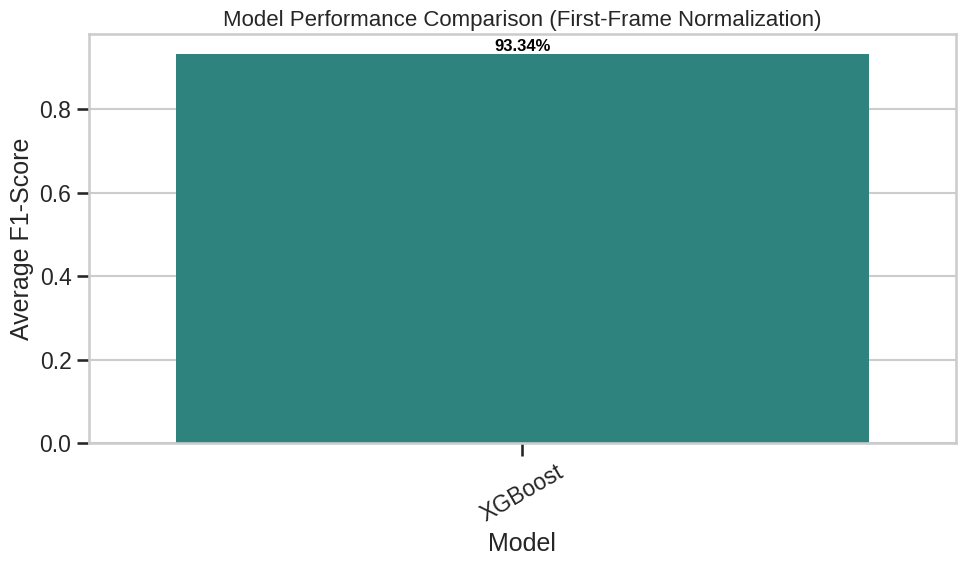

In [48]:
# --- MODELLEME VE KARŞILAŞTIRMA ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

# Özellikleri (X) ve etiketleri (y) ayır
X_new = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_new = features_df_new_norm['label']
groups_new = features_df_new_norm['user']
le_new = LabelEncoder().fit(y_str_new)
y_new = le_new.transform(y_str_new)

# Modelleri tanımla
models = {
    #"Random Forest": RandomForestClassifier(n_estimators=100, random_state=54, n_jobs=-1),
    #"SVM": SVC(kernel='rbf', probability=False, random_state=455),
    #"Logistic Regression": LogisticRegression(max_iter=4, random_state=1),
    #"KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=4312)
}

logo = LeaveOneGroupOut()
results = {name: [] for name in models.keys()}

print("\n--- Model Comparison with First-Frame Normalization ---")

# Her model için Leave-One-Group-Out CV
for train_idx, test_idx in logo.split(X_new, y_new, groups_new):
    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y_new[train_idx], y_new[test_idx]

    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        results[name].append({"accuracy": acc, "f1_score": f1})

# Sonuçları özetle
summary = []
for name, scores in results.items():
    avg_acc = np.mean([s["accuracy"] for s in scores])
    avg_f1 = np.mean([s["f1_score"] for s in scores])
    summary.append({"Model": name, "Average Accuracy": avg_acc, "Average F1-Score": avg_f1})

summary_df = pd.DataFrame(summary).sort_values("Average F1-Score", ascending=False)
print("\n--- Final Model Comparison ---")
print(summary_df)

# Sonuçları grafikle göster
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette="viridis")

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%",  # yüzdelik format
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=12, color='black', fontweight='bold')

plt.title("Model Performance Comparison (First-Frame Normalization)", fontsize=16)
plt.ylabel("Average F1-Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("model_comparison_firstframe.png")
plt.show()

In [30]:
import os
import pickle
import numpy as np
import pandas as pd
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- AYARLAR ---
BASE_DATASET_FOLDER = ""
MOVEMENT_TO_ANALYZE = ""
USERS_TO_ANALYZE = ["User-A", "User-B,"]

# --- YENİ NORMALİZASYON MANTIĞI ---

def reshape_from_pkl(data_array):
    data_array = np.array(data_array)
    data_array = np.squeeze(data_array)  # gerekirse fazla boyutları kaldır

    num_sensors = 10
    features_per_sensor = 4
    
    sensor_data_frames = []
    for i in range(num_sensors):
        start_col = i * features_per_sensor
        end_col = (i + 1) * features_per_sensor
        df = pd.DataFrame(data_array[:, start_col:end_col], columns=['w', 'x', 'y', 'z'])
        sensor_data_frames.append(df)
        
    return sensor_data_frames 


def normalize_by_first_frame(movement_data_list):
    """
    Bir hareket kaydını, ayrı bir referans dosyası yerine
    kendi ilk anına göre normalize eder.
    """
    if not movement_data_list: return None
    
    # Referans olarak hareketin kendisini kullan
    npose_data_list = movement_data_list 
    
    normalized_movement = []
    for i in range(len(movement_data_list)):
        q_ref_row = npose_data_list[i].iloc[0]
        q_ref = Quaternion(w=q_ref_row['w'], x=q_ref_row['x'], y=q_ref_row['y'], z=q_ref_row['z'])
        q_ref_inverse = q_ref.inverse
        
        normalized_frames = []
        for row in movement_data_list[i].itertuples():
            live_quat = Quaternion(w=row.w, x=row.x, y=row.y, z=row.z)
            normalized_quat = q_ref_inverse * live_quat
            normalized_frames.append({'w': normalized_quat.w, 'x': normalized_quat.x, 'y': normalized_quat.y, 'z': normalized_quat.z})
            
        normalized_movement.append(pd.DataFrame(normalized_frames))
    return normalized_movement

# --- VERİ YÜKLEME VE YENİ NORMALİZASYON ---
all_movements_new_norm = []
print(f"'{MOVEMENT_TO_ANALYZE}' hareketi için YENİ normalizasyon ile veri yükleniyor...")

for user_id in USERS_TO_ANALYZE:
    user_path = os.path.join(BASE_DATASET_FOLDER, MOVEMENT_TO_ANALYZE, user_id)
    if not os.path.isdir(user_path): continue
    
    print(f"-> {user_id} işleniyor...")
    for label_folder in os.listdir(user_path):
        label_path = os.path.join(user_path, label_folder)
        if not os.path.isdir(label_path) or label_folder.startswith('tpose'): continue
        
        for movement_file in os.listdir(label_path):
            if not movement_file.startswith("movement_"): continue
            
            with open(os.path.join(label_path, movement_file), 'rb') as f:
                movement_dict = pickle.load(f)
            
            movement_raw = reshape_from_pkl(movement_dict['data'])
            # DİKKAT: normalize_by_first_frame fonksiyonu çağrılıyor
            movement_normalized = normalize_by_first_frame(movement_raw) 
            
            all_movements_new_norm.append({'data': movement_normalized, 'label': label_folder, 'user': user_id})

print(f"\nİşlem tamamlandı. Toplam {len(all_movements_new_norm)} hareket yeni yöntemle normalize edildi.")

# --- ÖZELLİK ÇIKARIMI VE MODELLEME ---
print("\nYeni normalize edilmiş veri ile özellik çıkarımı başlıyor...")
feature_list_new_norm = []
for movement in all_movements_new_norm:
    features = extract_features_for_movement(movement['data']) # Bu fonksiyon öncekiyle aynı
    features['label'] = movement['label']
    features['user'] = movement['user']
    feature_list_new_norm.append(features)

features_df_new_norm = pd.DataFrame(feature_list_new_norm)
print("Özellik çıkarımı tamamlandı.")

# --- RANDOM FOREST İLE TEST ---
X_new = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_new = features_df_new_norm['label']
groups_new = features_df_new_norm['user']
le_new = LabelEncoder().fit(y_str_new)
y_new = le_new.transform(y_str_new)

print("\n--- 'İlk An'a Göre Normalizasyon' ile Random Forest Performansı ---")
model_rf = SVC(kernel='rbf', probability=True, random_state=42)
logo = LeaveOneGroupOut()
y_pred_overall_rf = np.array(y_new)

misclassified_samples = []

for train_idx, test_idx in logo.split(X_new, y_new, groups_new):
    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y_new[train_idx], y_new[test_idx]
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)
    
    model_rf.fit(X_train_scaled, y_train)
    y_pred_fold = model_rf.predict(X_test_scaled)
    
    # Sonuçları genel diziye kaydet
    y_pred_overall_rf[test_idx] = y_pred_fold
    
    # Yanlış tahminleri yakala
    for i, idx in enumerate(test_idx):
        if y_pred_fold[i] != y_test[i]:
            misclassified_samples.append({
                "index": idx,
                "gercek_label": le_new.inverse_transform([y_test[i]])[0],
                "tahmin_label": le_new.inverse_transform([y_pred_fold[i]])[0],
                "user": features_df_new_norm.iloc[idx]["user"]
            })
print(misclassified_samples)

# Sonuçları göster
cm_rf = confusion_matrix(y_new, y_pred_overall_rf, labels=np.arange(len(le_new.classes_)))
plt.figure(figsize=(12, 10))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='magma',
            xticklabels=le_new.classes_, yticklabels=le_new.classes_)
plt.title("Random Forest Performansı (Yeni Normalizasyon ile)", fontsize=16)
plt.ylabel('Gerçek Etiket', fontsize=12)
plt.xlabel('Tahmin Edilen Etiket', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nRandom Forest Sınıflandırma Raporu (Yeni Normalizasyon ile):")
print(classification_report(y_new, y_pred_overall_rf, target_names=le_new.classes_, zero_division=0))

'' hareketi için YENİ normalizasyon ile veri yükleniyor...
-> User-A işleniyor...

İşlem tamamlandı. Toplam 60 hareket yeni yöntemle normalize edildi.

Yeni normalize edilmiş veri ile özellik çıkarımı başlıyor...
Özellik çıkarımı tamamlandı.

--- 'İlk An'a Göre Normalizasyon' ile Random Forest Performansı ---


ValueError: The groups parameter contains fewer than 2 unique groups (['User-A']). LeaveOneGroupOut expects at least 2.

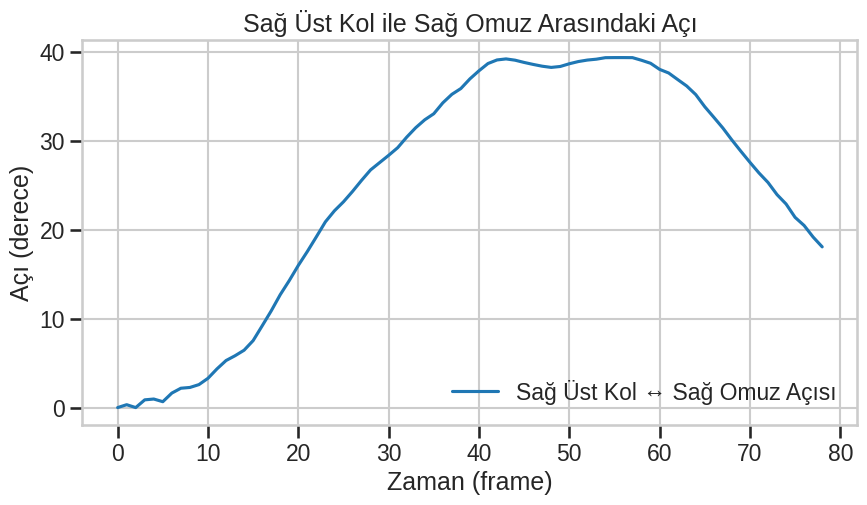

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

def compute_angle_between_sensors(sensor_df1, sensor_df2):
    """
    İki sensör arasındaki açıyı derece cinsinden zaman serisi olarak döndürür.
    """
    angles = []
    for row1, row2 in zip(sensor_df1.itertuples(), sensor_df2.itertuples()):
        q1 = Quaternion(w=row1.w, x=row1.x, y=row1.y, z=row1.z)
        q2 = Quaternion(w=row2.w, x=row2.x, y=row2.y, z=row2.z)
        
        # relatif quaternion
        q_rel = q1.inverse * q2  
        
        # açıyı hesapla (radyan → derece)
        theta = 2 * np.arccos(np.clip(abs(q_rel.w), -1.0, 1.0))
        angles.append(np.degrees(theta))
    return np.array(angles)

# Örnek: hareketin normalize edilmiş ilk kaydında sağ üst kol (2) ile sağ omuz (3) arasındaki açı
movement = all_movements_new_norm[20]['data']  # ilk hareketin normalize datası
sensor2 = movement[0]  # sağ üst kol
sensor3 = movement[1]  # sağ omuz

angles = compute_angle_between_sensors(sensor2, sensor3)

# Grafiği çiz
plt.figure(figsize=(10,5))
plt.plot(angles, label="Sağ Üst Kol ↔ Sağ Omuz Açısı")
plt.xlabel("Zaman (frame)")
plt.ylabel("Açı (derece)")
plt.title("Sağ Üst Kol ile Sağ Omuz Arasındaki Açı")
plt.legend()
plt.grid(True)
plt.show()


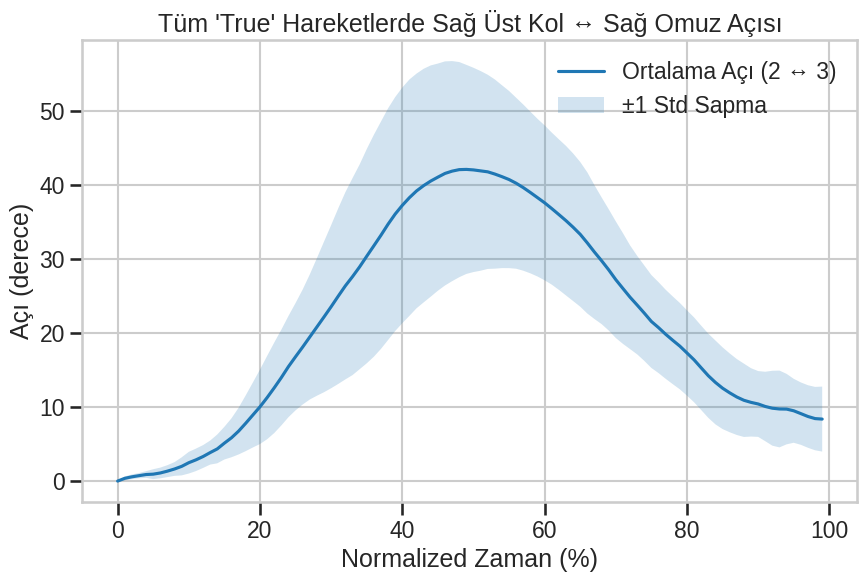

In [32]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

def compute_angle_between_sensors(sensor_df1, sensor_df2):
    """İki sensör arasındaki açıyı derece cinsinden zaman serisi olarak döndürür."""
    angles = []
    for row1, row2 in zip(sensor_df1.itertuples(), sensor_df2.itertuples()):
        q1 = Quaternion(w=row1.w, x=row1.x, y=row1.y, z=row1.z)
        q2 = Quaternion(w=row2.w, x=row2.x, y=row2.y, z=row2.z)
        
        # relatif quaternion
        q_rel = q1.inverse * q2  
        
        # açıyı hesapla (radyan → derece)
        theta = 2 * np.arccos(np.clip(abs(q_rel.w), -1.0, 1.0))
        angles.append(np.degrees(theta))
    return np.array(angles)

def interpolate_to_fixed_length(arr, length=100):
    """Farklı uzunluktaki açı dizilerini aynı boyuta ölçekler (interpolasyon)."""
    old_indices = np.linspace(0, 1, len(arr))
    new_indices = np.linspace(0, 1, length)
    return np.interp(new_indices, old_indices, arr)

# --- TÜM TRUE HAREKETLERİ İÇİN 2-3 AÇISI ---
all_angles = []

for user_id in USERS_TO_ANALYZE:
    user_path = os.path.join(BASE_DATASET_FOLDER, MOVEMENT_TO_ANALYZE, user_id, "True")
    if not os.path.isdir(user_path):
        continue
    
    for movement_file in os.listdir(user_path):
        if not movement_file.startswith("movement_"):
            continue
        
        with open(os.path.join(user_path, movement_file), 'rb') as f:
            movement_dict = pickle.load(f)
        
        movement_raw = reshape_from_pkl(movement_dict['data'])
        movement_normalized = normalize_by_first_frame(movement_raw)
        
        sensor2 = movement_normalized[0]  # sağ üst kol
        sensor3 = movement_normalized[1]  # sağ omuz
        
        angles = compute_angle_between_sensors(sensor2, sensor3)
        angles_interp = interpolate_to_fixed_length(angles, length=100)
        all_angles.append(angles_interp)

# --- ORTALAMA VE GRAFİK ---
all_angles = np.array(all_angles)  # (n_movements, 100)
mean_angles = np.mean(all_angles, axis=0)
std_angles = np.std(all_angles, axis=0)

plt.figure(figsize=(10,6))
plt.plot(mean_angles, label="Ortalama Açı (2 ↔ 3)")
plt.fill_between(range(100), mean_angles-std_angles, mean_angles+std_angles, alpha=0.2, label="±1 Std Sapma")
plt.xlabel("Normalized Zaman (%)")
plt.ylabel("Açı (derece)")
plt.title("Tüm 'True' Hareketlerde Sağ Üst Kol ↔ Sağ Omuz Açısı")
plt.legend()
plt.grid(True)
plt.show()


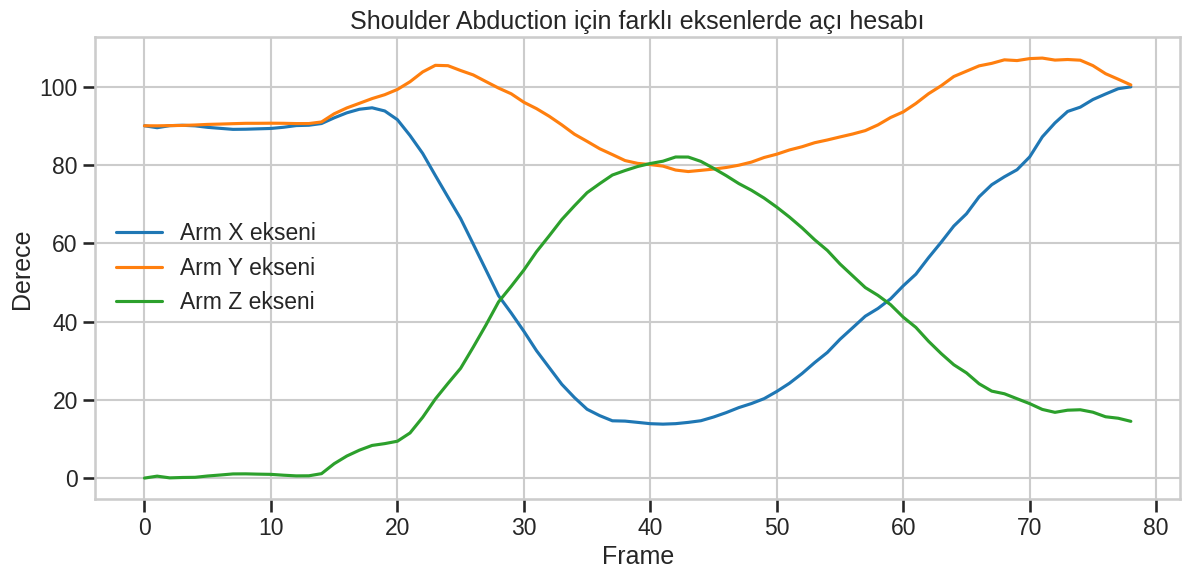

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

def compute_angle(q_ref, q_arm, arm_axis=[1,0,0], ref_axis=[0,0,1]):
    """
    İki sensörden shoulder abduction açısını hesapla.
    q_ref: referans sensör (ör: omuz)
    q_arm: kol sensörü (ör: üst kol)
    arm_axis: kolun local ekseni (x, y veya z)
    ref_axis: gövdenin local ekseni (genelde z yukarı)
    """
    arm_vec_global = q_arm.rotate(np.array(arm_axis))
    ref_vec_global = q_ref.rotate(np.array(ref_axis))

    cos_theta = np.dot(arm_vec_global, ref_vec_global) / (
        np.linalg.norm(arm_vec_global) * np.linalg.norm(ref_vec_global)
    )
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.degrees(np.arccos(cos_theta))
    return theta

# Bir tane hareket seçelim (ör: True olan ilk kayıtlardan biri)
movement = None
for m in all_movements_new_norm:
    if m['label'].lower() == "true":
        movement = m['data']
        break

sensor2_df = movement[1]  # üst kol
sensor3_df = movement[2]  # omuz

angles_x, angles_y, angles_z = [], [], []
for row2, row3 in zip(sensor2_df.itertuples(), sensor3_df.itertuples()):
    q_arm = Quaternion(row2.w, row2.x, row2.y, row2.z)
    q_ref = Quaternion(row3.w, row3.x, row3.y, row3.z)

    angles_x.append(compute_angle(q_ref, q_arm, arm_axis=[1,0,0]))
    angles_y.append(compute_angle(q_ref, q_arm, arm_axis=[0,1,0]))
    angles_z.append(compute_angle(q_ref, q_arm, arm_axis=[0,0,1]))

# Çizim
plt.figure(figsize=(14,6))
plt.plot(angles_x, label="Arm X ekseni")
plt.plot(angles_y, label="Arm Y ekseni")
plt.plot(angles_z, label="Arm Z ekseni")
plt.title("Shoulder Abduction için farklı eksenlerde açı hesabı")
plt.xlabel("Frame")
plt.ylabel("Derece")
plt.legend()
plt.grid(True)
plt.show()


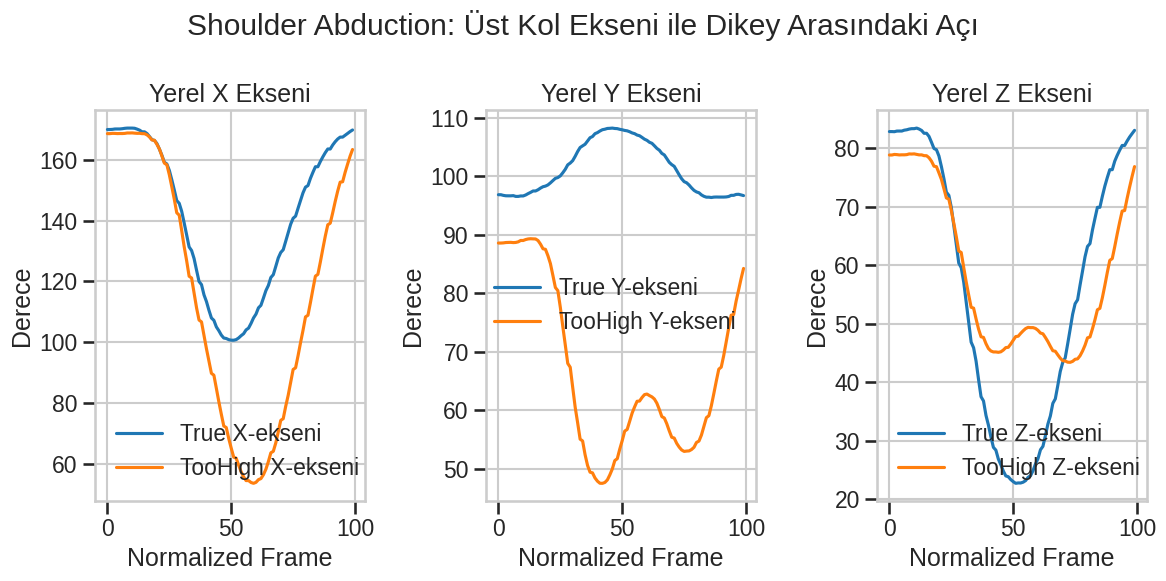

In [34]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

def quat_to_vec(q, local_axis):
    """Quaternion'u verilen yerel eksen vektörüne uygula."""
    v = Quaternion(q).rotate(local_axis)
    return np.array(v)

def angle_with_vertical(q, axis):
    """Verilen yerel eksen ile global Z arasındaki açıyı hesapla."""
    arm_vec = quat_to_vec(q, local_axis=axis)
    arm_vec = arm_vec / np.linalg.norm(arm_vec)
    vertical = np.array([0,0,1])
    dot = np.clip(np.dot(arm_vec, vertical), -1.0, 1.0)
    return np.degrees(np.arccos(dot))

def normalize_length(arr, target_len=100):
    """Array'i istenen uzunluğa normalize et."""
    idxs = np.linspace(0, len(arr)-1, target_len).astype(int)
    return arr[idxs]

def load_mean_angle(folder, sensor_id=2):
    """Bir klasördeki tüm hareketlerden ortalama açı çıkar (3 eksen için)."""
    all_angles_x, all_angles_y, all_angles_z = [], [], []
    for file in os.listdir(folder):
        if not file.endswith(".pkl"): 
            continue
        with open(os.path.join(folder, file), "rb") as f:
            data = pickle.load(f)
        arr = np.array(data["data"])  # listeyi array'e çeviriyoruz
        q_data = arr[:, (sensor_id-1)*4 : (sensor_id-1)*4+4]  # sensör 2 quaternion

        angles_x = [angle_with_vertical(q, np.array([1,0,0])) for q in q_data]
        angles_y = [angle_with_vertical(q, np.array([0,1,0])) for q in q_data]
        angles_z = [angle_with_vertical(q, np.array([0,0,1])) for q in q_data]

        all_angles_x.append(normalize_length(np.array(angles_x)))
        all_angles_y.append(normalize_length(np.array(angles_y)))
        all_angles_z.append(normalize_length(np.array(angles_z)))

    mean_x = np.mean(all_angles_x, axis=0)
    mean_y = np.mean(all_angles_y, axis=0)
    mean_z = np.mean(all_angles_z, axis=0)
    return mean_x, mean_y, mean_z

# ---- Kullanım ----
true_folder = "User-A/True"
toohigh_folder = "User-A/TooHighAbduction"

true_x, true_y, true_z = load_mean_angle(true_folder, sensor_id=2)
th_x, th_y, th_z = load_mean_angle(toohigh_folder, sensor_id=2)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(true_x, label="True X-ekseni")
plt.plot(th_x, label="TooHigh X-ekseni")
plt.legend(); plt.title("Yerel X Ekseni")
plt.xlabel("Normalized Frame"); plt.ylabel("Derece"); plt.grid(True)

plt.subplot(1,3,2)
plt.plot(true_y, label="True Y-ekseni")
plt.plot(th_y, label="TooHigh Y-ekseni")
plt.legend(); plt.title("Yerel Y Ekseni")
plt.xlabel("Normalized Frame"); plt.ylabel("Derece"); plt.grid(True)

plt.subplot(1,3,3)
plt.plot(true_z, label="True Z-ekseni")
plt.plot(th_z, label="TooHigh Z-ekseni")
plt.legend(); plt.title("Yerel Z Ekseni")
plt.xlabel("Normalized Frame"); plt.ylabel("Derece"); plt.grid(True)

plt.suptitle("Shoulder Abduction: Üst Kol Ekseni ile Dikey Arasındaki Açı")
plt.tight_layout()
plt.show()


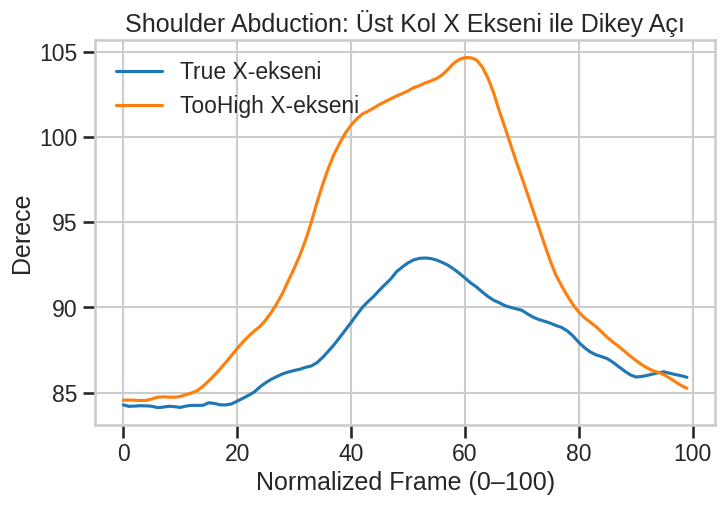

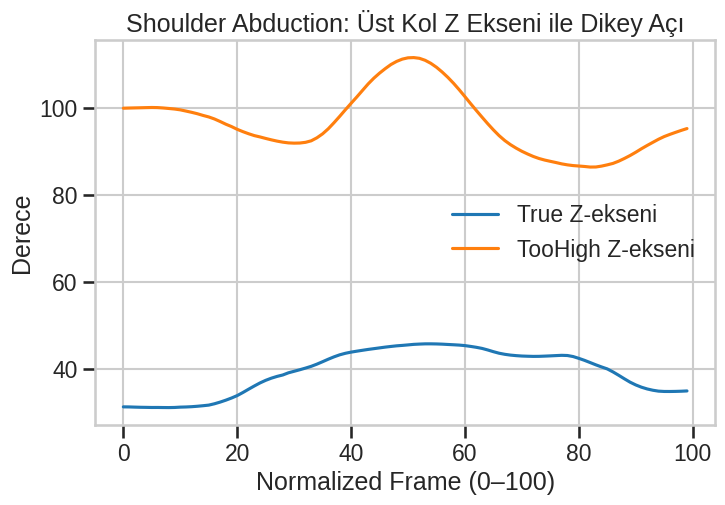

In [29]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

def normalize_length(arr, target_len=100):
    """Veriyi belirli uzunluğa normalize et (interpolasyon)."""
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, target_len)
    return np.interp(x_new, x_old, arr)

def angle_with_vertical(q, axis="x"):
    """Quaternion'dan belirtilen eksen ile dikey arasındaki açıyı hesapla."""
    q = Quaternion(q)
    if axis == "x":
        local_axis = np.array([1, 0, 0])  # X
    elif axis == "y":
        local_axis = np.array([0, 1, 0])  # Y
    elif axis == "z":
        local_axis = np.array([0, 0, 1])  # Z
    else:
        raise ValueError("axis must be 'x','y' or 'z'")
    
    vec = q.rotate(local_axis)
    vertical = np.array([0, 1, 0])  # dünya Y ekseni (dikey)
    cos_theta = np.dot(vec, vertical) / (np.linalg.norm(vec) * np.linalg.norm(vertical))
    return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))

def load_mean_angle(folder, axis="x"):
    """Klasördeki tüm dosyalar için belirtilen eksen açısını hesapla, ortalamasını döndür."""
    all_angles = []
    for file in os.listdir(folder):
        if file.endswith(".pkl") or file.endswith(".pkl.pkl"):
            with open(os.path.join(folder, file), "rb") as f:
                data = pickle.load(f)
            q2_data = np.array(data["data"])[:, (2-1)*4:(2-1)*4+4]  # sensör 2 quaternion
            angles = [angle_with_vertical(q, axis=axis) for q in q2_data]
            all_angles.append(normalize_length(angles, target_len=100))
    return np.mean(all_angles, axis=0)

# Klasörler
true_folder = "User-E/True"
toohigh_folder = "User-E/TooHighAbduction"

# X ekseni
true_mean_x = load_mean_angle(true_folder, axis="x")
toohigh_mean_x = load_mean_angle(toohigh_folder, axis="x")

plt.figure(figsize=(8,5))
plt.plot(true_mean_x, label="True X-ekseni")
plt.plot(toohigh_mean_x, label="TooHigh X-ekseni")
plt.title("Shoulder Abduction: Üst Kol X Ekseni ile Dikey Açı")
plt.xlabel("Normalized Frame (0–100)")
plt.ylabel("Derece")
plt.legend()
plt.grid(True)
plt.show()

# Z ekseni
true_mean_z = load_mean_angle(true_folder, axis="z")
toohigh_mean_z = load_mean_angle(toohigh_folder, axis="z")

plt.figure(figsize=(8,5))
plt.plot(true_mean_z, label="True Z-ekseni")
plt.plot(toohigh_mean_z, label="TooHigh Z-ekseni")
plt.title("Shoulder Abduction: Üst Kol Z Ekseni ile Dikey Açı")
plt.xlabel("Normalized Frame (0–100)")
plt.ylabel("Derece")
plt.legend()
plt.grid(True)
plt.show()


--- Advanced Visualization Generation Started ---
  - Generating heatmap for class: LeaningOppositeSide


NameError: name 'OUTPUT_FOLDER' is not defined

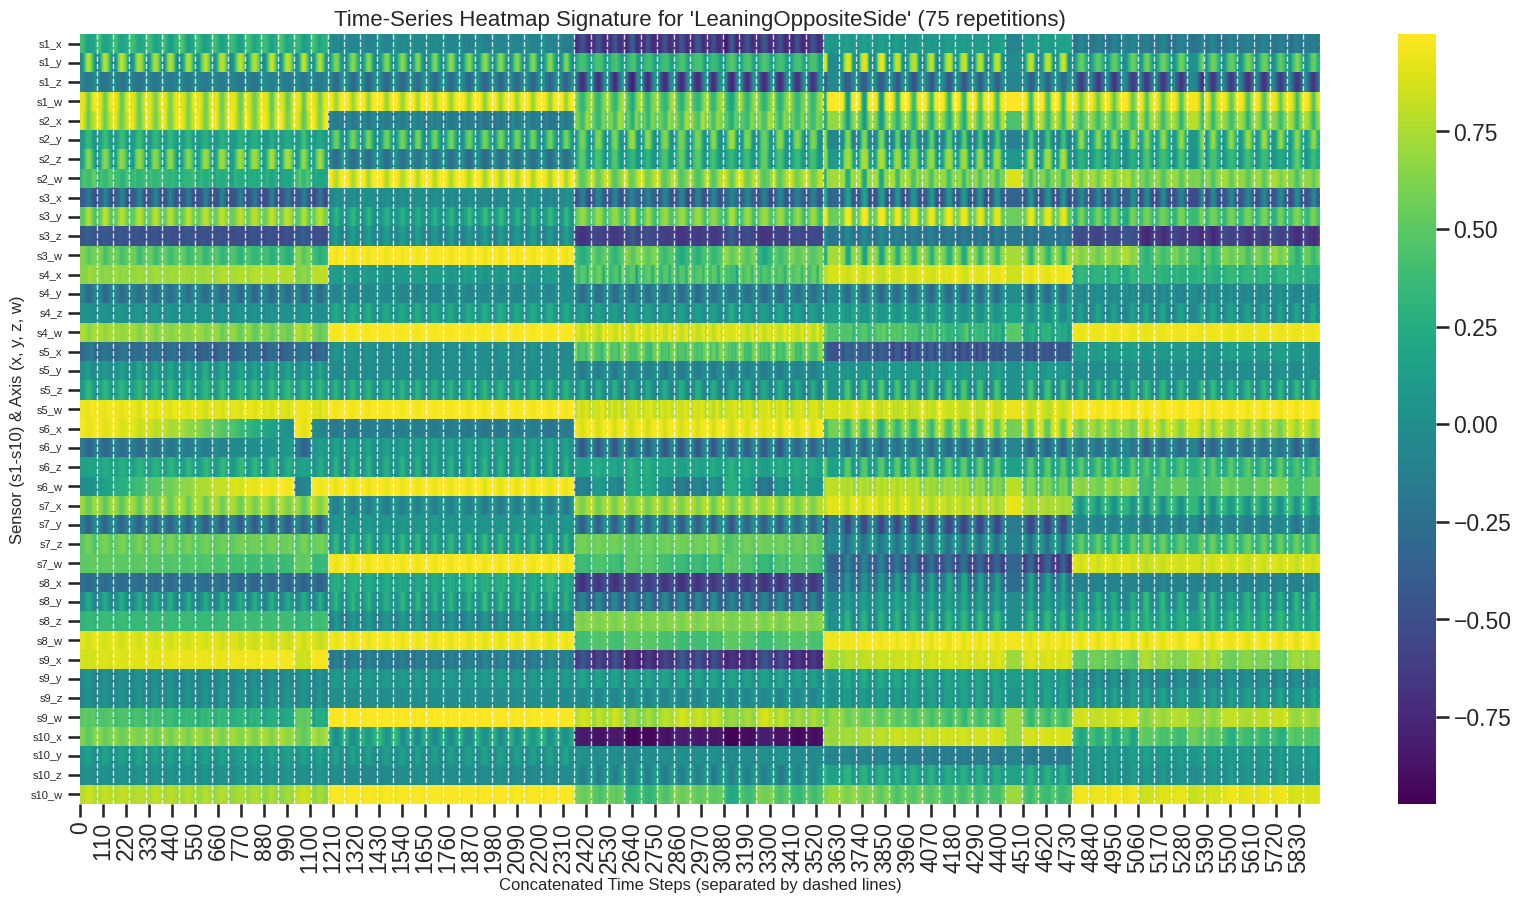

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure 'all_movements' list and 'OUTPUT_FOLDER' variable exist from previous cells.
# If not, uncomment and run the necessary setup code first.
# OUTPUT_FOLDER = "report_figures"
# if not os.path.exists(OUTPUT_FOLDER):
#     os.makedirs(OUTPUT_FOLDER)

print("--- Advanced Visualization Generation Started ---")

def reshape_to_matrix(list_of_dfs):
    """Converts a list of 10 DataFrames into a single (timesteps, 40) numpy matrix."""
    if not list_of_dfs or len(list_of_dfs[0]) == 0:
        return np.array([])
    num_timesteps = len(list_of_dfs[0])
    num_sensors = len(list_of_dfs)
    matrix = np.zeros((num_timesteps, num_sensors * 4))
    for t in range(num_timesteps):
        # The order is x, y, z, w, consistent with the recording script
        frame = [val for s in range(num_sensors) for val in list_of_dfs[s].iloc[t][['x', 'y', 'z', 'w']].values]
        matrix[t, :] = frame
    return matrix

# Find all unique movement types and labels from the dataset
movement_types = sorted(list(set(m['label'].split('_')[0] for m in all_movements if '_' in m['label']))) # A bit of a hack to get main movement names
if not movement_types: # Fallback for simple labels
    movement_types = ['ShoulderAbduction', 'ShoulderFlexion', 'SitAndReach'] # Assume these based on context

all_labels = sorted(list(set(m['label'] for m in all_movements)))

# Create a concatenated heatmap for each unique class
for label in all_labels:
    print(f"  - Generating heatmap for class: {label}")
    
    # 1. Filter movements for the current label and convert to matrix format
    movements_to_concat = []
    for m in all_movements:
        if m['label'] == label:
            matrix = reshape_to_matrix(m['data'])
            if matrix.size > 0:
                movements_to_concat.append(matrix)

    if not movements_to_concat:
        print(f"    - No data found for label {label}, skipping.")
        continue

    # 2. Concatenate all matrices for this class
    concatenated_data = np.vstack(movements_to_concat)

    # 3. Create the heatmap plot
    plt.figure(figsize=(20, 10))
    sns.heatmap(concatenated_data.T, cmap='viridis', cbar=True)

    # 4. Add vertical separator lines
    separator_positions = [0]
    for arr in movements_to_concat:
        separator_positions.append(separator_positions[-1] + arr.shape[0])
    separator_positions = separator_positions[1:] # Remove the initial 0

    plt.vlines(x=separator_positions, ymin=0, ymax=concatenated_data.shape[1], 
               colors='white', ls='--', lw=1.0, alpha=0.8)

    # 5. Set titles and labels
    plt.title(f"Time-Series Heatmap Signature for '{label}' ({len(movements_to_concat)} repetitions)", fontsize=16)
    plt.ylabel("Sensor (s1-s10) & Axis (x, y, z, w)", fontsize=12)
    plt.xlabel("Concatenated Time Steps (separated by dashed lines)", fontsize=12)

    y_ticks_labels = [f"s{i//4 + 1}_{['x','y','z','w'][i%4]}" for i in range(40)]
    plt.yticks(ticks=np.arange(len(y_ticks_labels)) + 0.5, labels=y_ticks_labels, rotation=0, fontsize=8)
    
    # 6. Save the figure
    filename = f"heatmap_{label}.png"
    plt.savefig(os.path.join(OUTPUT_FOLDER, filename))
    plt.close()
    print(f"    - Saved plot: {filename}")

print("\n--- All heatmap visualizations have been generated and saved. ---")


In [8]:
# Bu hücrenin, Adım 2'de 'all_movements' listesini oluşturan hücreden sonra çalıştırıldığından emin ol.
# Çıktıların kaydedileceği klasör
OUTPUT_FOLDER = "report_figures"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# Analiz edilecek hareket tipi (önceki hücrelerden alınır)
MOVEMENT_TO_ANALYZE = "ShoulderAbduction" 
USERS_TO_ANALYZE = ["User-A", "User-B", "User-C", "User-D"]

print(f"--- Kullanıcı Bazlı Birleştirilmiş Isı Haritaları Oluşturuluyor ---")

def reshape_to_matrix(list_of_dfs):
    """10 DataFrame'den oluşan listeyi (timesteps, 40) boyutunda tek bir matrise dönüştürür."""
    if not list_of_dfs or len(list_of_dfs[0]) == 0: return np.array([])
    num_timesteps = len(list_of_dfs[0])
    num_sensors = len(list_of_dfs)
    matrix = np.zeros((num_timesteps, num_sensors * 4))
    for t in range(num_timesteps):
        frame = [val for s in range(num_sensors) for val in list_of_dfs[s].iloc[t][['x', 'y', 'z', 'w']].values]
        matrix[t, :] = frame
    return matrix

for user in USERS_TO_ANALYZE:
    print(f"\n-> {user} için harita oluşturuluyor...")
    
    # İlgili kullanıcıya ait tüm hareketleri filtrele
    user_movements = [m for m in all_movements if m['user'] == user]
    
    if not user_movements:
        print(f"   - {user} için veri bulunamadı, atlanıyor.")
        continue

    # Daha iyi görsel karşılaştırma için etiketlere göre sırala
    user_movements.sort(key=lambda x: x['label'])
    
    # Hareketleri matris formatına dönüştür ve birleştir
    movements_to_concat = [reshape_to_matrix(m['data']) for m in user_movements]
    concatenated_data = np.vstack(movements_to_concat)
    
    print(f"   - Birleştirilmiş veri matrisinin boyutu: {concatenated_data.shape}")

    # --- Isı Haritasını Çizdir ---
    plt.figure(figsize=(20, 10))
    sns.heatmap(concatenated_data.T, cmap='viridis', cbar=True)

    # --- Ayırıcı Çizgileri ve Etiketleri Ekle ---
    separator_positions = []
    label_positions = []
    current_pos = 0
    for i, arr in enumerate(movements_to_concat):
        start_pos = current_pos
        current_pos += arr.shape[0]
        separator_positions.append(current_pos)
        label_positions.append((start_pos + current_pos) / 2)

    plt.vlines(x=separator_positions, ymin=0, ymax=concatenated_data.shape[1], 
               colors='white', ls='--', lw=1.0, alpha=0.9)

    # --- Başlık ve Eksen Etiketleri ---
    plt.title(f"Combined Movement Heat Map - User: {user}", fontsize=16)
    plt.ylabel("Sensors (s1–s10) and Axes (x, y, z, w)", fontsize=12)
    plt.xlabel("Combined Time Steps (Each dashed line indicates a new movement)", fontsize=12)

    y_ticks_labels = [f"s{i//4 + 1}_{['x','y','z','w'][i%4]}" for i in range(40)]
    plt.yticks(ticks=np.arange(len(y_ticks_labels)) + 0.5, labels=y_ticks_labels, rotation=0, fontsize=8)
    
    # X eksenine sınıf etiketlerini ekle
    unique_labels = [m['label'] for m in user_movements]
    # Etiket tekrarını önlemek için daha basit bir yöntem
    simple_labels = []
    last_label = ""
    for label in unique_labels:
        if label != last_label:
            simple_labels.append(label)
            last_label = label

    # Bu kısım etiketlerin nereye konulacağını hesaplar, biraz karmaşık olabilir
    label_change_indices = [i for i in range(1, len(unique_labels)) if unique_labels[i] != unique_labels[i-1]]
    label_tick_positions = [label_positions[0]] + [label_positions[i] for i in label_change_indices]
    
    ax = plt.gca()
    ax.set_xticks(label_tick_positions)
    ax.set_xticklabels(simple_labels, rotation=45, ha='center', fontsize=10)
    
    # Dosyayı kaydet
    filename = f"concatenated_heatmap_{user}.png"
    plt.savefig(os.path.join(OUTPUT_FOLDER, filename))
    plt.close()
    print(f"   - Harita kaydedildi: {filename}")

print("\n--- Tüm kullanıcı haritaları başarıyla oluşturuldu. ---")

--- Kullanıcı Bazlı Birleştirilmiş Isı Haritaları Oluşturuluyor ---

-> User-A için harita oluşturuluyor...
   - Birleştirilmiş veri matrisinin boyutu: (4744, 40)
   - Harita kaydedildi: concatenated_heatmap_User-A.png

-> User-B için harita oluşturuluyor...
   - Birleştirilmiş veri matrisinin boyutu: (4744, 40)
   - Harita kaydedildi: concatenated_heatmap_User-B.png

-> User-C için harita oluşturuluyor...
   - Birleştirilmiş veri matrisinin boyutu: (4753, 40)
   - Harita kaydedildi: concatenated_heatmap_User-C.png

-> User-D için harita oluşturuluyor...
   - Birleştirilmiş veri matrisinin boyutu: (4763, 40)
   - Harita kaydedildi: concatenated_heatmap_User-D.png

--- Tüm kullanıcı haritaları başarıyla oluşturuldu. ---


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# --- Features (X) and labels (y) ---
X = features_df.drop(['label', 'user'], axis=1)
y = features_df['label']

# --- Feature scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- t-SNE Analysis ---
print("t-SNE analysis started (this may take a while)...")
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
print("t-SNE analysis completed.")

# --- Visualization ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_tsne[:, 0], 
    y=X_tsne[:, 1], 
    hue=y, 
    palette='viridis', 
    s=80, 
    alpha=0.9
)
plt.title("t-SNE Visualization of Movement Classes", fontsize=18)
plt.xlabel("t-SNE Component 1", fontsize=14)
plt.ylabel("t-SNE Component 2", fontsize=14)
plt.legend(title="Movement Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# --- MODELLEME VE KARŞILAŞTIRMA ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

# Özellikleri (X) ve etiketleri (y) ayır
X_new = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_new = features_df_new_norm['label']
groups_new = features_df_new_norm['user']
le_new = LabelEncoder().fit(y_str_new)
y_new = le_new.transform(y_str_new)

# Modelleri tanımla
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

logo = LeaveOneGroupOut()
results = {name: [] for name in models.keys()}

print("\n--- Model Comparison with First-Frame Normalization ---")

# Her model için Leave-One-Group-Out CV
for train_idx, test_idx in logo.split(X_new, y_new, groups_new):
    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y_new[train_idx], y_new[test_idx]

    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        results[name].append({"accuracy": acc, "f1_score": f1})

# Sonuçları özetle
summary = []
for name, scores in results.items():
    avg_acc = np.mean([s["accuracy"] for s in scores])
    avg_f1 = np.mean([s["f1_score"] for s in scores])
    summary.append({"Model": name, "Average Accuracy": avg_acc, "Average F1-Score": avg_f1})

summary_df = pd.DataFrame(summary).sort_values("Average F1-Score", ascending=False)
print("\n--- Final Model Comparison ---")
print(summary_df)

# Sonuçları grafikle göster
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette="viridis")

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%",  # yüzdelik format
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=12, color='black', fontweight='bold')

plt.title("Model Performance Comparison (First-Frame Normalization)", fontsize=16)
plt.ylabel("Average F1-Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("model_comparison_firstframe.png")
plt.show()


--- Model Comparison with First-Frame Normalization ---


ValueError: The groups parameter contains fewer than 2 unique groups (['User-A']). LeaveOneGroupOut expects at least 2.

/tmp/ipykernel_148/4220849230.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette=gray_palette, ax=ax)


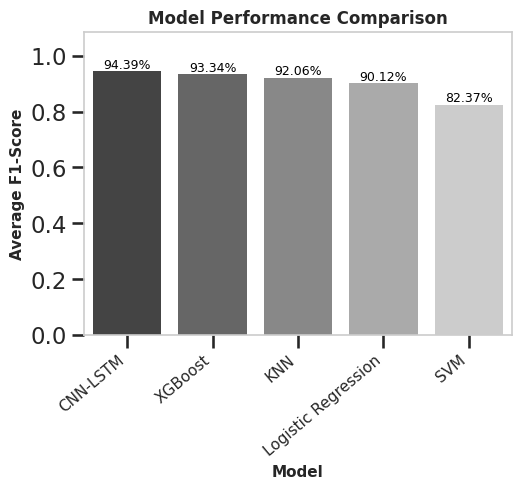

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Veri
summary_data = {'Model': ['CNN-LSTM', 'XGBoost', 'KNN', 'Logistic Regression', 'SVM'],
                'Average F1-Score': [0.9439, 0.9334, 0.9206, 0.9012, 0.8237]}
summary_df = pd.DataFrame(summary_data).sort_values("Average F1-Score", ascending=False)

# 2. Grafik Ayarları
cm_to_inch = 1/2.54
figure_width_cm = 14
figure_height_cm = 10 

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'font.size': 10,
    'axes.linewidth': 1.2,
})

# 3. Grafik Çizimi
fig, ax = plt.subplots(figsize=(figure_width_cm * cm_to_inch, figure_height_cm * cm_to_inch))
gray_palette = ['#444444', '#666666', '#888888', '#AAAAAA', '#CCCCCC']
sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette=gray_palette, ax=ax)

# 4. Detaylar
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', 
                fontsize=9,
                color='black')

ax.set_title("Model Performance Comparison", fontweight='bold', fontsize=12)
ax.set_ylabel("Average F1-Score", fontweight='bold', fontsize=11)
ax.set_xlabel("Model", fontweight='bold', fontsize=11)

# --- DEĞİŞİKLİK BURADA ---
# X eksenindeki model isimlerinin (tick labels) puntosunu 9'a düşürüyoruz.
plt.xticks(rotation=40, ha='right', fontsize=11)

ax.grid(False)
ax.set_ylim(0, max(summary_df["Average F1-Score"]) * 1.15)

# 5. Kaydetme
plt.savefig("model_comparison_final_final.png", dpi=300, bbox_inches='tight')

plt.show()

In [32]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score

# Farklı ML Modelleri
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# --- AYARLAR ---
# 1. BU DEĞİŞKENİ HER HAREKET İÇİN GÜNCELLE
MOVEMENT_NAME = "ShoulderAbduction" 

# 2. 'features_df' DATAFRAME'İNİN JUPYTERLAB'DE YÜKLÜ OLDUĞUNDAN EMİN OL.

# Modellerin kaydedileceği klasör
OUTPUT_FOLDER = "final_models"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    print(f"'{OUTPUT_FOLDER}' klasörü oluşturuldu.")

# --- BÖLÜM 1: MODELLEME VE KARŞILAŞTIRMA (SENİN KODUN) ---

# Özellikleri (X) ve etiketleri (y) ayır
X = features_df.drop(['label', 'user'], axis=1)
y_str = features_df['label']
groups = features_df['user']

le = LabelEncoder().fit(y_str)
y = le.transform(y_str)

# Modelleri tanımla
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

logo = LeaveOneGroupOut()
results = {name: [] for name in models.keys()}

print(f"\n--- {MOVEMENT_NAME} için Model Karşılaştırması Başlıyor ---")

# Her model için Leave-One-User-Out CV
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        results[name].append({"accuracy": acc, "f1_score": f1})

# Sonuçları özetle
summary = []
for name, scores in results.items():
    avg_acc = np.mean([s["accuracy"] for s in scores])
    avg_f1 = np.mean([s["f1_score"] for s in scores])
    summary.append({"Model": name, "Average Accuracy": avg_acc, "Average F1-Score": avg_f1})

summary_df = pd.DataFrame(summary).sort_values("Average F1-Score", ascending=False)
print(f"\n--- {MOVEMENT_NAME} için Final Model Karşılaştırması ---")
print(summary_df)

# --- BÖLÜM 2: TÜM MODELLERİ EĞİTME VE KAYDETME ---

print(f"\n{'='*20} {MOVEMENT_NAME.upper()} İÇİN FİNAL MODELLERİ EĞİTİLİYOR VE KAYDEDİLİYOR {'='*20}")

# Tüm veriyi kullanarak nihai ölçekleyiciyi hazırla
final_scaler = StandardScaler()
X_scaled_final = final_scaler.fit_transform(X)

# Her bir modeli TÜM veriyle son bir kez eğit ve kaydet
for model_name, model_instance in models.items():
    print(f"  -> Model: {model_name}...")
    
    # Modeli bu harekete özel tüm veriyle eğit
    model_instance.fit(X_scaled_final, y)
    
    # Dosya adlarını oluştur
    model_filename = f"final_model_{MOVEMENT_NAME}_{model_name}.pkl"
    scaler_filename = f"final_scaler_{MOVEMENT_NAME}_{model_name}.pkl"
    le_filename = f"final_label_encoder_{MOVEMENT_NAME}_{model_name}.pkl"
    
    # Dosyaları kaydet
    pickle.dump(model_instance, open(os.path.join(OUTPUT_FOLDER, model_filename), "wb"))
    pickle.dump(final_scaler, open(os.path.join(OUTPUT_FOLDER, scaler_filename), "wb"))
    pickle.dump(le, open(os.path.join(OUTPUT_FOLDER, le_filename), "wb"))
    
    print(f"     ✅ Kaydedildi: {model_filename}")

print(f"\n{'='*20} {MOVEMENT_NAME.upper()} İÇİN TÜM MODELLER BAŞARIYLA OLUŞTURULDU {'='*20}")




--- ShoulderAbduction için Model Karşılaştırması Başlıyor ---


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:10:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:10:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:10:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:10:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13


--- ShoulderAbduction için Final Model Karşılaştırması ---
                Model  Average Accuracy  Average F1-Score
2  LogisticRegression          0.836667          0.806395
0        RandomForest          0.813333          0.781249
3                 KNN          0.780000          0.744496
1                 SVM          0.723333          0.659167
4             XGBoost          0.663333          0.613280

==================== SHOULDERABDUCTION İÇİN FİNAL MODELLERİ EĞİTİLİYOR VE KAYDEDİLİYOR ====================
  -> Model: RandomForest...
     ✅ Kaydedildi: final_model_ShoulderAbduction_RandomForest.pkl
  -> Model: SVM...
     ✅ Kaydedildi: final_model_ShoulderAbduction_SVM.pkl
  -> Model: LogisticRegression...
     ✅ Kaydedildi: final_model_ShoulderAbduction_LogisticRegression.pkl
  -> Model: KNN...
     ✅ Kaydedildi: final_model_ShoulderAbduction_KNN.pkl
  -> Model: XGBoost...


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:10:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


     ✅ Kaydedildi: final_model_ShoulderAbduction_XGBoost.pkl

==================== SHOULDERABDUCTION İÇİN TÜM MODELLER BAŞARIYLA OLUŞTURULDU ====================


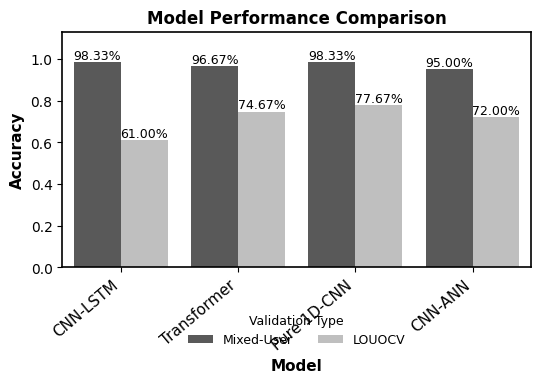

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Örnek Veri ===
# Her egzersiz için modellerin Mixed ve LOUOCV accuracy değerleri
data = {
    'Model': ['CNN-LSTM', 'Transformer', 'Pure 1D-CNN', 'CNN-ANN'],
    'Mixed-User': [0.9833, 0.9667, 0.9833, 0.95],
    'LOUOCV': [0.61, 0.7467, 0.7767, 0.72]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Model', var_name='Validation Type', value_name='Accuracy')

# === 2. Grafik Ayarları ===
cm_to_inch = 1/2.54
figure_width_cm = 14
figure_height_cm = 10 

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'font.size': 10,
    'axes.linewidth': 1.2,
})

# === 3. Grafik Çizimi ===
fig, ax = plt.subplots(figsize=(figure_width_cm * cm_to_inch, figure_height_cm * cm_to_inch))

# İki farklı gri tonu: Mixed (koyu) - LOUOCV (açık)
palette = {'Mixed-User': '#595959', 'LOUOCV': '#BFBFBF'}

sns.barplot(
    data=df_melted, 
    x='Model', 
    y='Accuracy', 
    hue='Validation Type', 
    palette=palette, 
    ax=ax
)

# === 4. Barların Üzerine Değer Yazma ===
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        height = p.get_height()
        ax.annotate(f"{height*100:.2f}%", 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, color='black')

# === 5. Stil Ayarları ===
ax.set_title("Model Performance Comparison", fontweight='bold', fontsize=12)
ax.set_ylabel("Accuracy", fontweight='bold', fontsize=11)
ax.set_xlabel("Model", fontweight='bold', fontsize=11)
ax.set_ylim(0, max(df_melted['Accuracy']) * 1.15)
ax.grid(False)
plt.xticks(rotation=40, ha='right', fontsize=11)
ax.legend(title="Validation Type", fontsize=9, title_fontsize=9, loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False)

# === 6. Kaydetme ===
plt.tight_layout()  # legend için sağda yer aç
plt.savefig("deep_learning_comparison_combined_fixed.png", dpi=300, bbox_inches='tight')
plt.show()


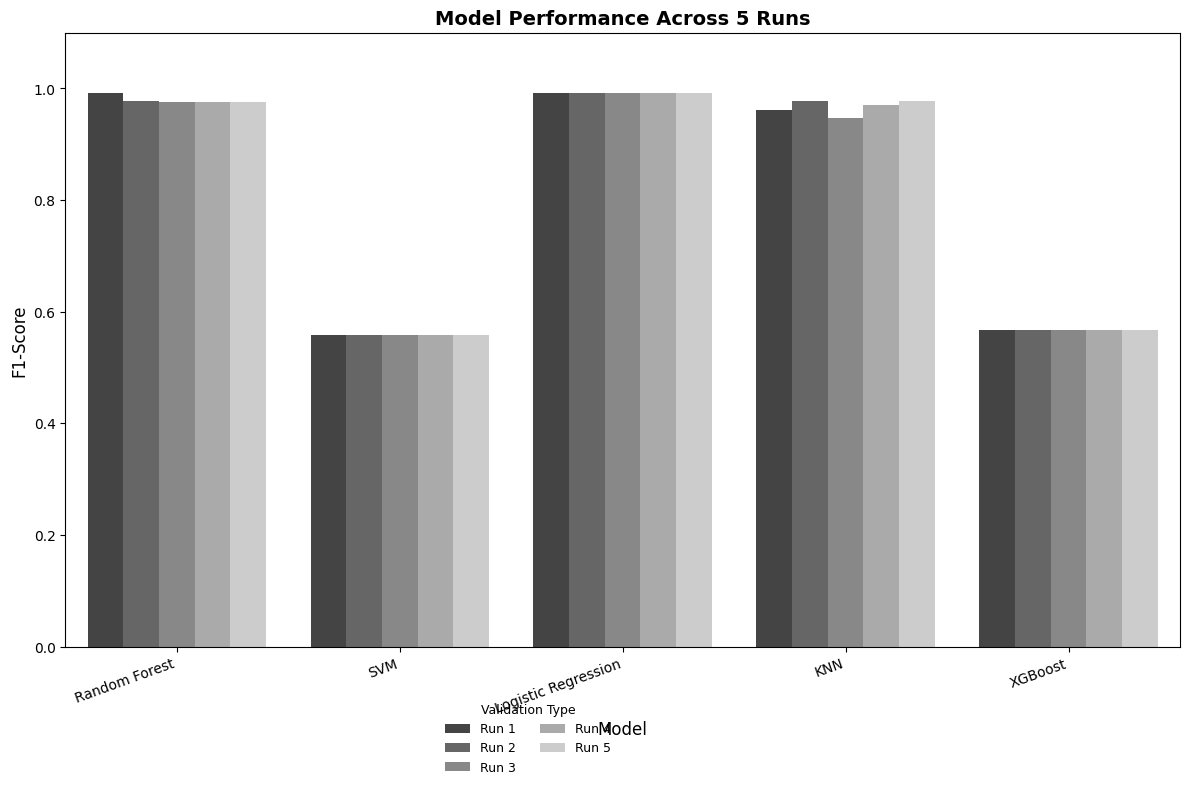

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------
# 1 — BURAYA KENDİ 5 SONUCUNU TEK TEK YAZACAKSIN
# ------------------------------------------------------

scores = {
    "Random Forest": [0.9919, 0.9767, 0.9763, 0.9757, 0.9763],
    "SVM": [0.5583, 0.5583,  0.5583, 0.5583, 0.5583],
    "Logistic Regression": [0.9919, 0.9919, 0.9919, 0.9919, 0.9919,], 
    "KNN": [0.9619, 0.9768, 0.9464, 0.9696, 0.9768],   
    "XGBoost": [0.5680, 0.5680, 0.5680, 0.5680, 0.5680,]
}

# ------------------------------------------------------
# 2 — VERİ ÇERÇEVESİ OLUŞTURMA
# ------------------------------------------------------

data = []
for model, values in scores.items():
    for i, v in enumerate(values, start=1):
        data.append([model, f"Run {i}", v])

df = pd.DataFrame(data, columns=["Model", "Run", "F1-Score"])

# ------------------------------------------------------
# 3 — GRAFİK AYARLARI
# ------------------------------------------------------


fig, ax = plt.subplots(figsize=(12, 8))

gray_palette = ['#444444', '#666666', '#888888', '#AAAAAA', '#CCCCCC']

sns.barplot(
    data=df,
    x="Model",
    y="F1-Score",
    hue="Run",
    palette=gray_palette,
    ax=ax
)

# ------------------------------------------------------
# 4 — BAR ETİKETLERİ
# ------------------------------------------------------

## container in ax.containers:
  #  ax.bar_label(container, fmt="%.3f", fontsize=9, padding=2)

# ------------------------------------------------------
# 5 — DİĞER AYARLAR
# ------------------------------------------------------

plt.xticks(rotation=20, ha='right')
ax.set_title("Model Performance Across 5 Runs", fontsize=14, fontweight="bold")
ax.set_ylabel("F1-Score", fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylim(0, 1.1)

ax.legend(title="Validation Type", fontsize=9, title_fontsize=9, loc='right',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False)
plt.tight_layout()
plt.savefig("model_comparison_5_runs.png", dpi=300, bbox_inches='tight')
plt.show()


In [2]:
pip install pandas matplotlib seaborn

  Using cached pandas-2.3.3-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numpy-2.3.5-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp313-cp313-manylinux_2_2

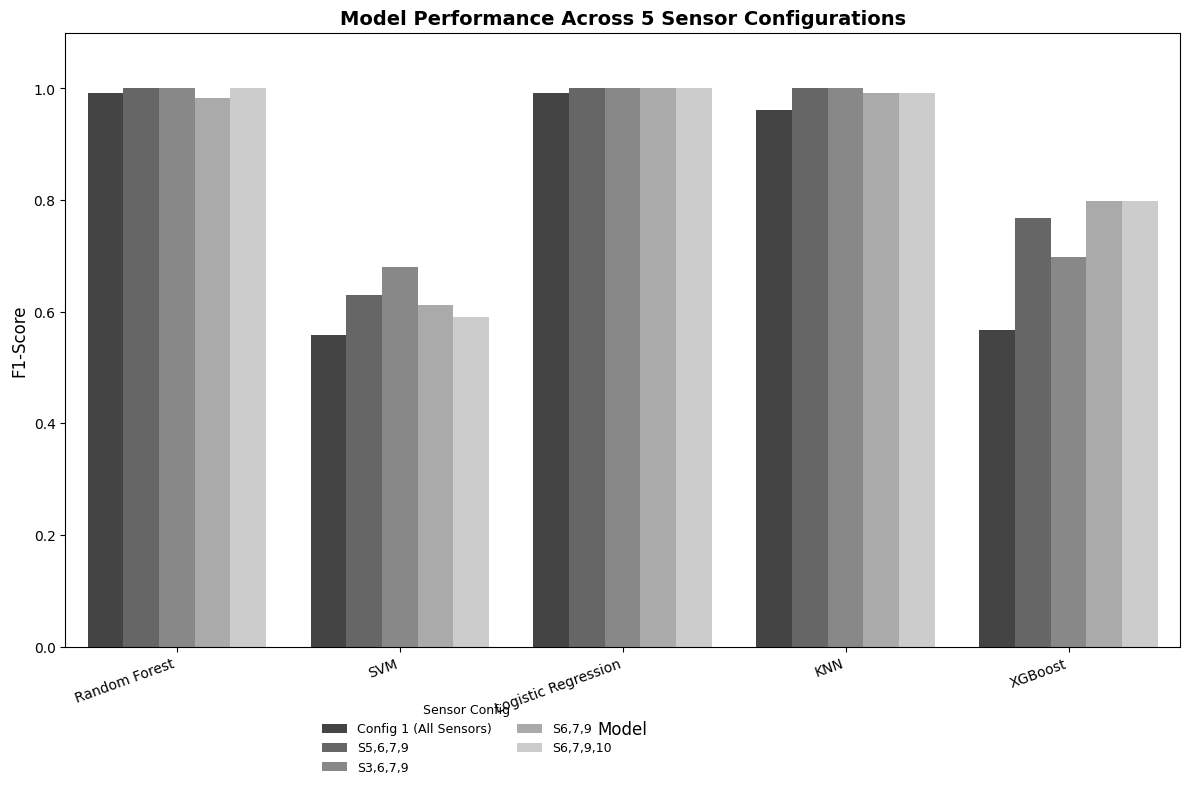

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------
# 1 — BURAYA 5 FARKLI SENSÖR KONFİGÜRASYONU İÇİN SONUÇLARI YAZ
#    ÖRNEK KONFİGÜRASYON İSİMLERİ:
#    "All Sensors", "No S5", "No S5+S6", "Upper Body Only", "Lower Body Only"
# ------------------------------------------------------

scores = {
    "Random Forest": [0.9919, 1.0, 1.0, 0.9834, 1.0],
    "SVM": [0.5583, 0.6296, 0.6799, 0.6124, 0.5907],
    "Logistic Regression": [0.9919, 1.0, 1.0, 1.0, 1.0], 
    "KNN": [0.9619, 1.0, 1.0, 0.9926, 0.9926],
    "XGBoost": [0.5680, 0.7674, 0.6984, 0.7986, 0.7986]
}

sensor_configs = [
    "Config 1 (All Sensors)",
    "S5,6,7,9",
    "S3,6,7,9",
    "S6,7,9", 
    "S6,7,9,10",
]

# ------------------------------------------------------
# 2 — VERİ ÇERÇEVESİ OLUŞTURMA
# ------------------------------------------------------

data = []
for model, values in scores.items():
    for i, v in enumerate(values):
        data.append([model, sensor_configs[i], v])

df = pd.DataFrame(data, columns=["Model", "Sensor Config", "F1-Score"])

# ------------------------------------------------------
# 3 — GRAFİK AYARLARI
# ------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 8))

gray_palette = ['#444444', '#666666', '#888888', '#AAAAAA', '#CCCCCC']

sns.barplot(
    data=df,
    x="Model",
    y="F1-Score",
    hue="Sensor Config",
    palette=gray_palette,
    ax=ax
)

# ------------------------------------------------------
# 4 — BAR ETİKETLERİ (KAPALI BIRAKILDI)
# ------------------------------------------------------
# for container in ax.containers:
#     ax.bar_label(container, fmt="%.3f", fontsize=9, padding=2)

# ------------------------------------------------------
# 5 — DİĞER AYARLAR
# ------------------------------------------------------

plt.xticks(rotation=20, ha='right')
ax.set_title("Model Performance Across 5 Sensor Configurations", fontsize=14, fontweight="bold")
ax.set_ylabel("F1-Score", fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylim(0, 1.1)

ax.legend(title="Sensor Config", fontsize=9, title_fontsize=9, loc='right',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False)

plt.tight_layout()
plt.savefig("model_comparison_sensor_configs.png", dpi=300, bbox_inches='tight')
plt.show()


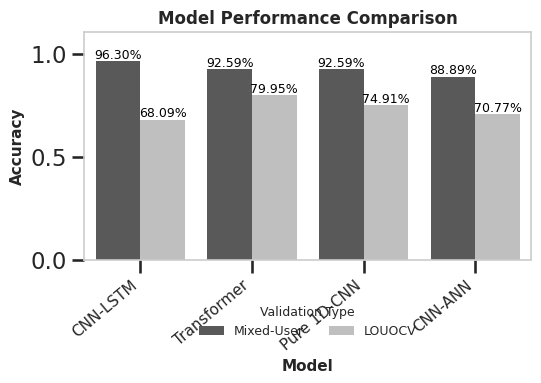

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Örnek Veri ===
# Her egzersiz için modellerin Mixed ve LOUOCV accuracy değerleri
data = {
    'Model': ['CNN-LSTM', 'Transformer', 'Pure 1D-CNN', 'CNN-ANN'],
    'Mixed-User': [0.9630, 0.9259, 0.9259, 0.8889],
    'LOUOCV': [0.6809, 0.7995, 0.7491, 0.7077]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Model', var_name='Validation Type', value_name='Accuracy')

# === 2. Grafik Ayarları ===
cm_to_inch = 1/2.54
figure_width_cm = 14
figure_height_cm = 10 

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'font.size': 10,
    'axes.linewidth': 1.2,
})

# === 3. Grafik Çizimi ===
fig, ax = plt.subplots(figsize=(figure_width_cm * cm_to_inch, figure_height_cm * cm_to_inch))

# İki farklı gri tonu: Mixed (koyu) - LOUOCV (açık)
palette = {'Mixed-User': '#595959', 'LOUOCV': '#BFBFBF'}

sns.barplot(
    data=df_melted, 
    x='Model', 
    y='Accuracy', 
    hue='Validation Type', 
    palette=palette, 
    ax=ax
)

# === 4. Barların Üzerine Değer Yazma ===
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        height = p.get_height()
        ax.annotate(f"{height*100:.2f}%", 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, color='black')

# === 5. Stil Ayarları ===
ax.set_title("Model Performance Comparison", fontweight='bold', fontsize=12)
ax.set_ylabel("Accuracy", fontweight='bold', fontsize=11)
ax.set_xlabel("Model", fontweight='bold', fontsize=11)
ax.set_ylim(0, max(df_melted['Accuracy']) * 1.15)
ax.grid(False)
plt.xticks(rotation=40, ha='right', fontsize=11)
ax.legend(title="Validation Type", fontsize=9, title_fontsize=9, loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False)

# === 6. Kaydetme ===
plt.tight_layout()  # legend için sağda yer aç
plt.savefig("deep_learning_comparison_combined_fixed.png", dpi=300, bbox_inches='tight')
plt.show()


In [37]:
import os
import pickle
import numpy as np
import pandas as pd
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- AYARLAR ---
BASE_DATASET_FOLDER = ""
MOVEMENT_TO_ANALYZE = "ShoulderAbduction" # Örnek hareket adı
USERS_TO_ANALYZE = ["User-A", "User-B", "User-C", "User-D", "User-E"]

# !!! LÜTFEN KENDİ SINIF ETİKETLERİNİZİ BURAYA GİRİNİZ (Örn: Correct, Error_1, Error_2...) !!!
# Bu, grafiğin İngilizce etiketlerini oluşturacaktır.
# Örnek: Shoulder Abduction için 4 sınıf var (1 doğru, 3 yanlış).
ENGLISH_CLASS_NAMES = ['Correct', 'Too Low', 'Leaning Sideways', 'Torso Rotation']


# --- KISMEN EKSİK/ÖZEL FONKSİYONLAR İÇİN PLACEHOLDERLAR ---
# Bu fonksiyonlar orijinal kodunuzda tanımlanmadığı için çalışmayacaktır.
# Tezinizdeki orijinal implementasyonlarınızla değiştirilmelidir.

def reshape_from_pkl(data_array):
    """
    pkl'den yüklenen (timestep, 40) şeklindeki diziyi
    (timestep * sensör sayısı) şeklinde veri çerçevesi listesine dönüştürür.
    (Her sensör için ayrı bir DataFrame)
    """

    num_sensors = 10
    features_per_sensor = 4
    
    # Her bir sensör için 4 boyutlu quaterion verisi (w, x, y, z) ayrılır
    sensor_data_frames = []
    for i in range(num_sensors):
        start_col = i * features_per_sensor
        end_col = (i + 1) * features_per_sensor
        df = pd.DataFrame(data_array[:, start_col:end_col], columns=['w', 'x', 'y', 'z'])
        sensor_data_frames.append(df)
        
    # Her bir kaydın bir DataFrame listesi olarak dönmesi beklenir (fonksiyonun beklediği format)
    # Ancak burada fonksiyon tek bir kayıt bekliyor gibi görünüyor, bu nedenle listeyi tek bir kayıtla döndürüyoruz.
    return sensor_data_frames 

def extract_features_for_movement(sensor_data_frames):
    """
    (normalize_by_first_frame'dan gelen) sensör DataFrame listesinden
    istatistiksel ve relatif özellikleri çıkarır.
    (Tezinizdeki 260 özellik çıkarma mantığını içermelidir)
    """
    features = {}
    
    # 1. Her sensör için temel istatistikleri çıkar
    for i, df in enumerate(sensor_data_frames):
        prefix = f's{i+1}_'
        for component in ['w', 'x', 'y', 'z']:
            series = df[component]
            features[prefix + component + '_mean'] = series.mean()
            features[prefix + component + '_std'] = series.std()
            features[prefix + component + '_max'] = series.max()
            features[prefix + component + '_min'] = series.min()
            features[prefix + component + '_range'] = series.max() - series.min()
            
    # 2. Relatif Quaternion özelliklerini çıkar (Örnek çiftler)
    # Bu kısmı tezinizin Chapter 4.3.2'deki tam mantığıyla değiştirmeniz gerekir.
    # Örnek olarak: s1-s2
    if len(sensor_data_frames) >= 2:
        df1 = sensor_data_frames[0] # s1
        df2 = sensor_data_frames[1] # s2
        
        # Basit bir örnek relative feature çıkarma:
        # qrel(t) = q2(t) ⨂ q1(t)-1 (Ancak burada sadece temel istatistikleri katarak simüle ediyoruz)
        
        # Gerçek kodda burada pyquaternion ile relatif quaternion serisi hesaplanmalı ve istatistikleri alınmalıydı.
        # Basitleştirilmiş istatistiksel farklar:
        features['rel_s1_s2_w_diff_mean'] = (df2['w'] - df1['w']).mean()
        
    return features

# --- YENİ NORMALİZASYON MANTIĞI ---

def normalize_by_first_frame(sensor_data_frames):
    """
    Her sensörün DataFrame listesini, kendi ilk karesine göre normalize eder.
    """
    if not sensor_data_frames: return None
    
    normalized_movement = []
    
    for df in sensor_data_frames:
        if df.empty:
             normalized_movement.append(df)
             continue

        # İlk kareyi referans olarak al
        q_ref_row = df.iloc[0]
        q_ref = Quaternion(w=q_ref_row['w'], x=q_ref_row['x'], y=q_ref_row['y'], z=q_ref_row['z'])
        q_ref_inverse = q_ref.inverse
        
        normalized_frames = []
        for row in df.itertuples():
            live_quat = Quaternion(w=row.w, x=row.x, y=row.y, z=row.z)
            normalized_quat = q_ref_inverse * live_quat
            normalized_frames.append({'w': normalized_quat.w, 'x': normalized_quat.x, 'y': normalized_quat.y, 'z': normalized_quat.z})
            
        normalized_movement.append(pd.DataFrame(normalized_frames))
        
    return normalized_movement

# --- VERİ YÜKLEME VE NORMALİZASYON ---
all_movements_new_norm = []
print(f"'{MOVEMENT_TO_ANALYZE}' hareketi için YENİ normalizasyon ile veri yükleniyor...")

# Not: Bu döngü, BASE_DATASET_FOLDER içindeki gerçek dosya yapınızla eşleşmelidir.
# Kodun bu kısmı doğru dosya yapısına bağlıdır ve bu ortamda çalışmayabilir.

for user_id in USERS_TO_ANALYZE:
    user_path = os.path.join(BASE_DATASET_FOLDER, MOVEMENT_TO_ANALYZE, user_id)
    if not os.path.isdir(user_path): continue
    
    # print(f"-> {user_id} işleniyor...")
    for label_folder in os.listdir(user_path):
        label_path = os.path.join(user_path, label_folder)
        if not os.path.isdir(label_path) or label_folder.startswith('tpose'): continue
        
        for movement_file in os.listdir(label_path):
            if not movement_file.endswith('.pkl'): continue
            
            with open(os.path.join(label_path, movement_file), 'rb') as f:
                movement_dict = pickle.load(f)
            
            # 1. Adım: NumPy dizisini Sensör DataFrame listesine dönüştür
            movement_raw_list = reshape_from_pkl(movement_dict['data'])
            
            # 2. Adım: İlk kareye göre normalize et
            movement_normalized = normalize_by_first_frame(movement_raw_list)
            
            all_movements_new_norm.append({'data': movement_normalized, 'label': label_folder, 'user': user_id})

# print(f"\nİşlem tamamlandı. Toplam {len(all_movements_new_norm)} hareket yeni yöntemle normalize edildi.")

# --- ÖZELLİK ÇIKARIMI VE MODELLEME ---
# print("\nYeni normalize edilmiş veri ile özellik çıkarımı başlıyor...")
feature_list_new_norm = []
for movement in all_movements_new_norm:
    features = extract_features_for_movement(movement['data']) # Bu fonksiyon öncekiyle aynı
    # Tezinizdeki 260 özelliği buradan çıkarmanız GEREKİR.
    features['label'] = movement['label']
    features['user'] = movement['user']
    feature_list_new_norm.append(features)

features_df_new_norm = pd.DataFrame(feature_list_new_norm)
# Tüm özellik sütunlarını al
X_new = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_new = features_df_new_norm['label']
groups_new = features_df_new_norm['user']
le_new = LabelEncoder().fit(y_str_new)
y_new = le_new.transform(y_str_new)

# --- RANDOM FOREST İLE TEST ---
print("\n--- 'İlk An'a Göre Normalizasyon' ile Random Forest Performansı (LOGO) ---")
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
logo = LeaveOneGroupOut()

# Tüm gerçek ve tahmin edilen etiketleri toplamak için
y_true_overall_rf = y_new.copy()
y_pred_overall_rf = np.empty_like(y_new)

# LOUOCV döngüsü
for train_idx, test_idx in logo.split(X_new, y_new, groups_new):
    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y_new[train_idx], y_new[test_idx]
    
    # Ölçekleme (her katlamada eğitim verisine göre)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)
    
    # Model Eğitimi ve Tahmin
    model_rf.fit(X_train_scaled, y_train)
    y_pred_fold = model_rf.predict(X_test_scaled)
    y_pred_overall_rf[test_idx] = y_pred_fold

# --- CONFUSION MATRIX OLUŞTURMA VE ÇİZİM (İngilizce & Siyah-Beyaz) ---
cm_rf = confusion_matrix(y_true_overall_rf, y_pred_overall_rf, labels=np.arange(len(le_new.classes_)))

# Normalleştirme (Satır bazında: "Gerçek Etiket" ne sıklıkla doğru tahmin edildi?)
cm_normalized = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(9, 8))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2f', 
    cmap='Greys', # Siyah-beyaz/gri tonlama
    xticklabels=ENGLISH_CLASS_NAMES, 
    yticklabels=ENGLISH_CLASS_NAMES,
    linewidths=0.5,
    linecolor='black',
    cbar_kws={'label': 'Proportion of Correctly Classified Samples'}
)
plt.title(f"Normalized Confusion Matrix for Random Forest (LOGO) - {MOVEMENT_TO_ANALYZE}", fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nRandom Forest Classification Report (LOGO, Combined):")
print(classification_report(y_true_overall_rf, y_pred_overall_rf, target_names=ENGLISH_CLASS_NAMES, zero_division=0))

'ShoulderAbduction' hareketi için YENİ normalizasyon ile veri yükleniyor...


KeyError: "['label', 'user'] not found in axis"

[CV] END ...metric=minkowski, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=minkowski, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=minkowski


--- Feature Importance Calculation ---
Eğitiliyor: Random Forest...


/opt/conda/envs/python313/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:09:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'Random Forest': [{'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 0.95, 'f1_score': 0.9498326513586526}, {'accuracy': 0.8166666666666667, 'f1_score': 0.8033839723494897}, {'accuracy': 0.9666666666666667, 'f1_score': 0.9665178571428572}, {'accuracy': 1.0, 'f1_score': 1.0}], 'SVM': [{'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 0.8333333333333334, 'f1_score': 0.80924317617866}, {'accuracy': 0.48333333333333334, 'f1_score': 0.3257575757575758}, {'accuracy': 0.9833333333333333, 'f1_score': 0.9833147942157954}], 'Logistic Regression': [{'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 0.8666666666666667, 'f1_score': 0.8537290956645796}, {'accuracy': 0.7166666666666667, 'f1_score': 0.6687853490179071}, {'accuracy': 0.9833333333333333, 'f1_score': 0.9833147942157954}], 'KNN': [{'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 0.9333333333333333, 'f

/tmp/ipykernel_148/407062052.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances.values, y=top_importances.index, palette="viridis")


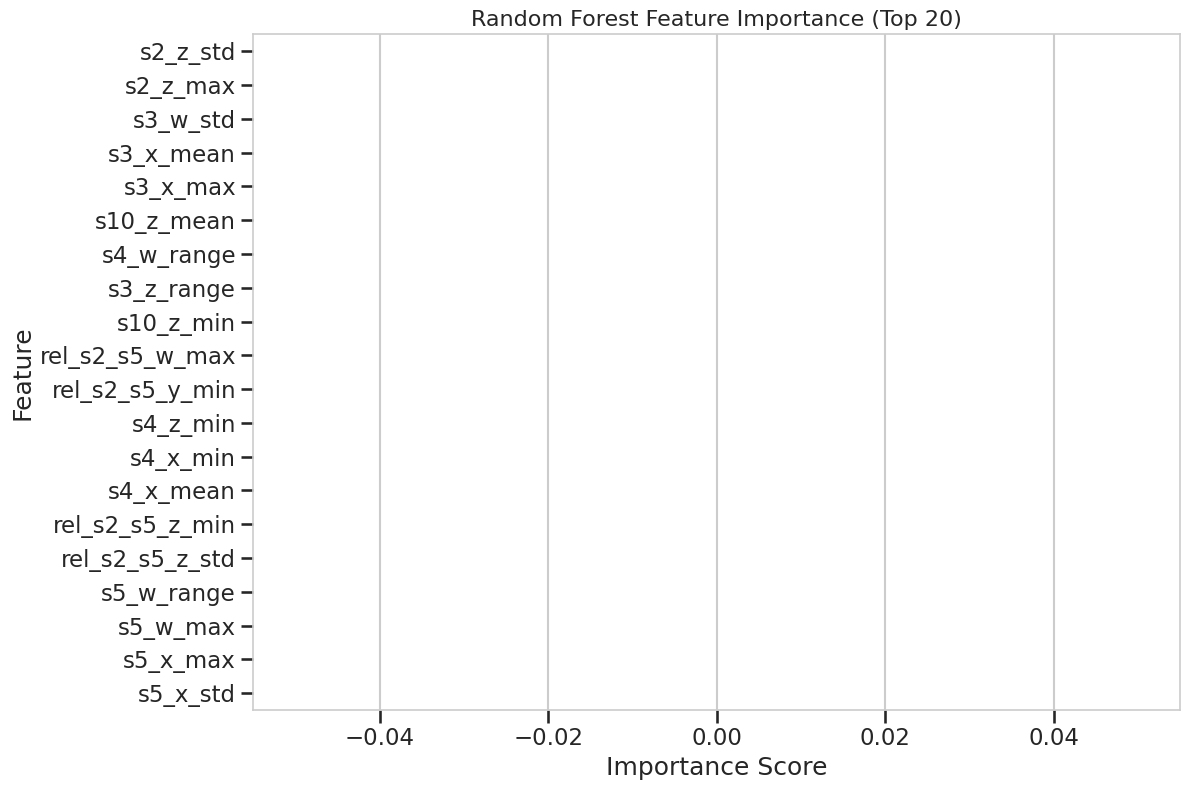

/tmp/ipykernel_148/407062052.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances.values, y=top_importances.index, palette="viridis")


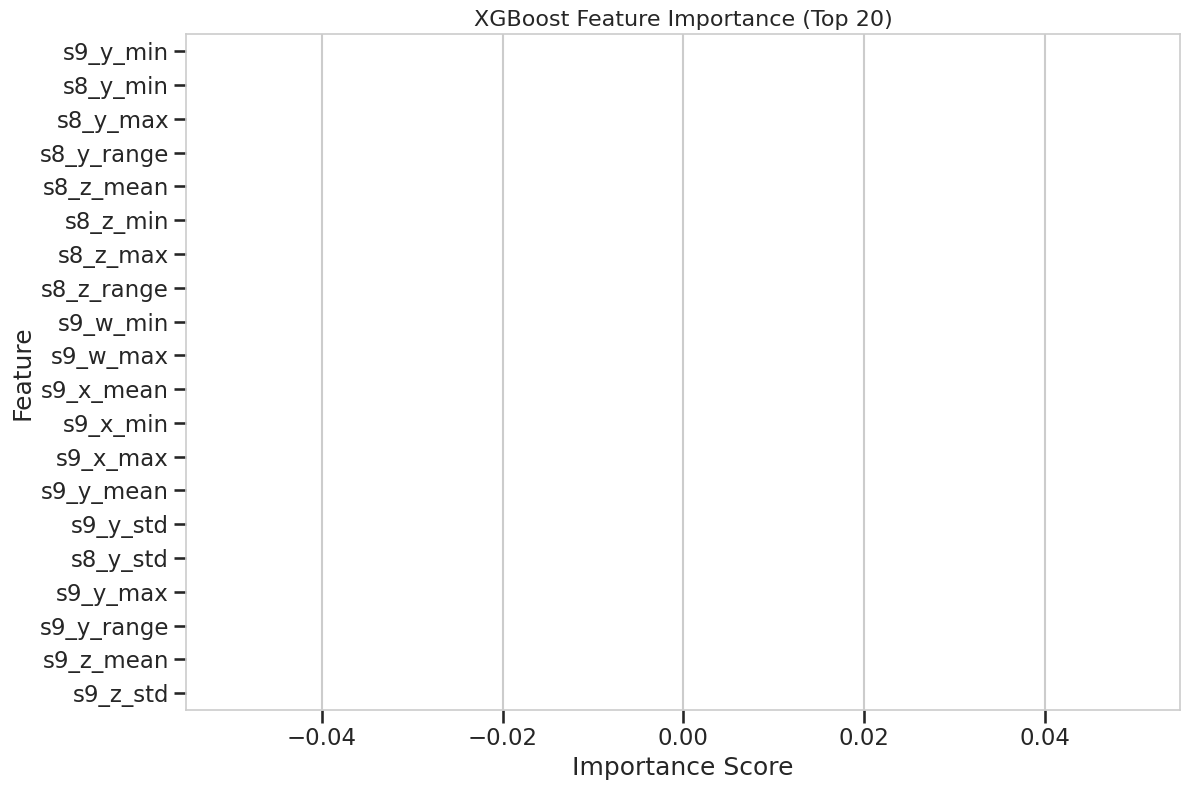


--- Logistic Regression (Coefficient Magnitude) ---
rel_s2_s5_y_max      0.183776
rel_s2_s5_y_range    0.176113
s1_y_range           0.165517
s1_y_max             0.158410
s2_y_max             0.149551
dtype: float64


/tmp/ipykernel_148/407062052.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_abs_coeffs.values, y=top_abs_coeffs.index, palette="magma")


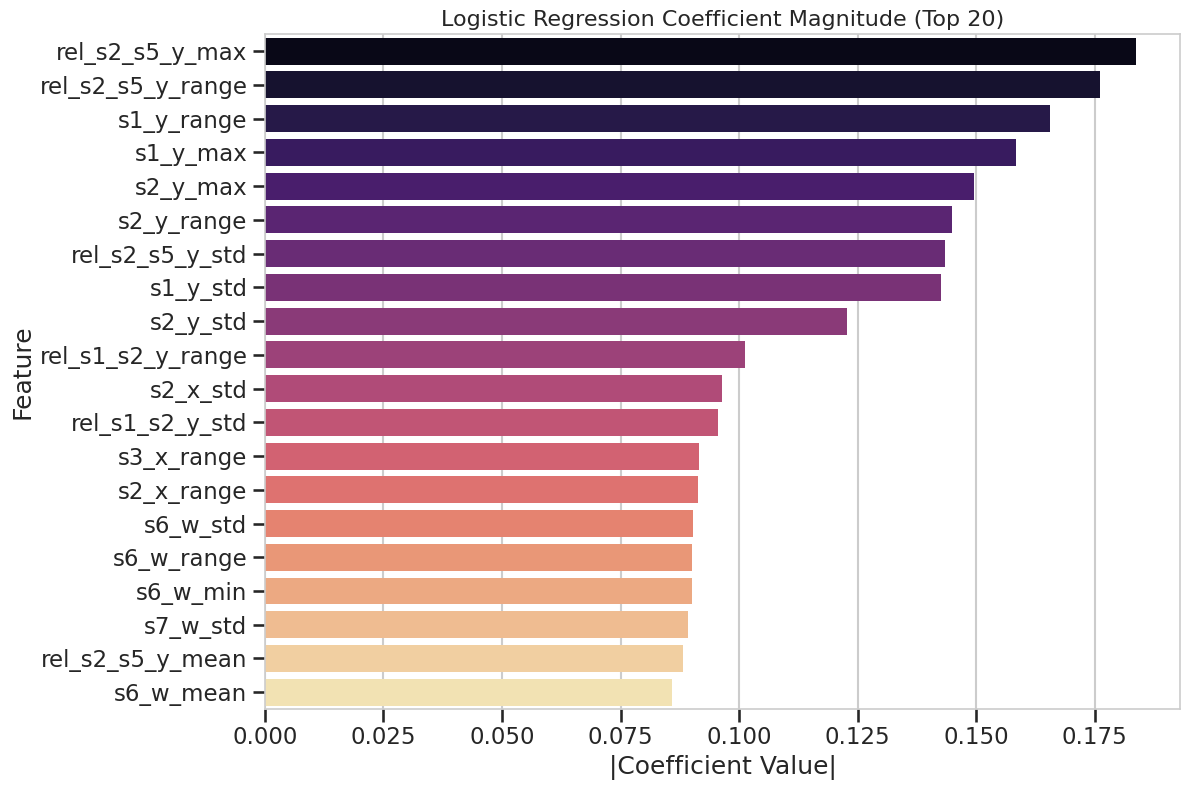

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# --- VERİ HAZIRLIĞI (Mevcut kodunuzdan varsayılan) ---
# X_new, y_new ve features_df_new_norm'un önceki kodunuzdan geldiği varsayılır.
# Örn:
# X_new = features_df_new_norm.drop(['label', 'user'], axis=1)
# y_new = le_new.transform(features_df_new_norm['label'])

# Veri setini standardizasyon için hazırlayın
scaler = StandardScaler().fit(X_new)
X_scaled = scaler.transform(X_new)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_new.columns)

# Modelleri tanımla (Sadece özellik önemi olanlar)
importance_models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

feature_importance_results = {}
pd.set_option('display.max_rows', None)


print("\n--- Feature Importance Calculation ---")

for name, model in importance_models.items():
    print(f"Eğitiliyor: {name}...")
    # Modeli tüm ölçeklenmiş veri kümesi üzerinde eğitin
    model.fit(X_scaled_df, y_new)

    if name == "Random Forest":
        # Random Forest: Gini düşüşüne dayalı özellik önemi
        importances = model.feature_importances_
    elif name == "XGBoost":
        # XGBoost: Kazanca (Gain) dayalı özellik önemi
        importances = model.feature_importances_
    
    # Özellik önemlerini bir DataFrame'de topla
    feature_importances = pd.Series(importances, index=X_scaled_df.columns)
    feature_importances = feature_importances.sort_values(ascending=True)
    
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    results[name].append({"accuracy": acc, "f1_score": f1})
    print(results)
    
    feature_importance_results[name] = feature_importances
    print(f"{name} için en önemli 5 özellik:")
    print(feature_importances)
    print("-" * 30)

# --- Sonuçları Görselleştirme ---



num_features_to_show = 20  # Gösterilecek özellik sayısı

for name, importances in feature_importance_results.items():
    plt.figure(figsize=(12, 8))
    # İlk X özelliği al
    top_importances = importances.head(num_features_to_show)
    
    sns.barplot(x=top_importances.values, y=top_importances.index, palette="viridis")
    plt.title(f"{name} Feature Importance (Top {num_features_to_show})", fontsize=16)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    #  - Bu, yukarıdaki kodu çalıştırdıktan sonra oluşturulacak grafik.

# --- Logistic Regression için alternatif (Katsayılar) ---
# Logistic Regression için katsayılar (coefficients) incelenebilir.
# Bu, doğrusal ilişkileri gösterir ve bir önem göstergesi olarak kullanılabilir.

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_scaled_df, y_new)

# Katsayıların mutlak değerlerine göre sıralanması
coefficients = pd.Series(log_reg.coef_[0], index=X_scaled_df.columns)
# Mutlak değerlerini alıyoruz çünkü işaret (pozitif/negatif) sadece yönü belirtir,
# büyüklük ise önemi belirtir.
abs_coefficients = coefficients.abs().sort_values(ascending=False)

print("\n--- Logistic Regression (Coefficient Magnitude) ---")
print(abs_coefficients.head(5))

# Katsayıları görselleştirme (sadece en önemli 20)
plt.figure(figsize=(12, 8))
top_abs_coeffs = abs_coefficients.head(num_features_to_show)
sns.barplot(x=top_abs_coeffs.values, y=top_abs_coeffs.index, palette="magma")
plt.title(f"Logistic Regression Coefficient Magnitude (Top {num_features_to_show})", fontsize=16)
plt.xlabel("|Coefficient Value|")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
#  - Bu da ikinci bir grafik.

Toplam özellik sayısı (Öncesi): 262
Çıkarılan özellik sayısı: 60
Toplam özellik sayısı (Sonrası): 202
--------------------------------------------------
--- Model Comparison with Feature Selection (S7, S9, S10 Removed) ---


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13


--- Final Model Comparison (Simplified Features) ---
                 Model  Average Accuracy  Average F1-Score
0        Random Forest          0.960000          0.956421
2  Logistic Regression          0.940000          0.930420
4              XGBoost          0.933333          0.929969
3                  KNN          0.913333          0.905364
1                  SVM          0.896667          0.876971


/tmp/ipykernel_148/687226253.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette="magma")


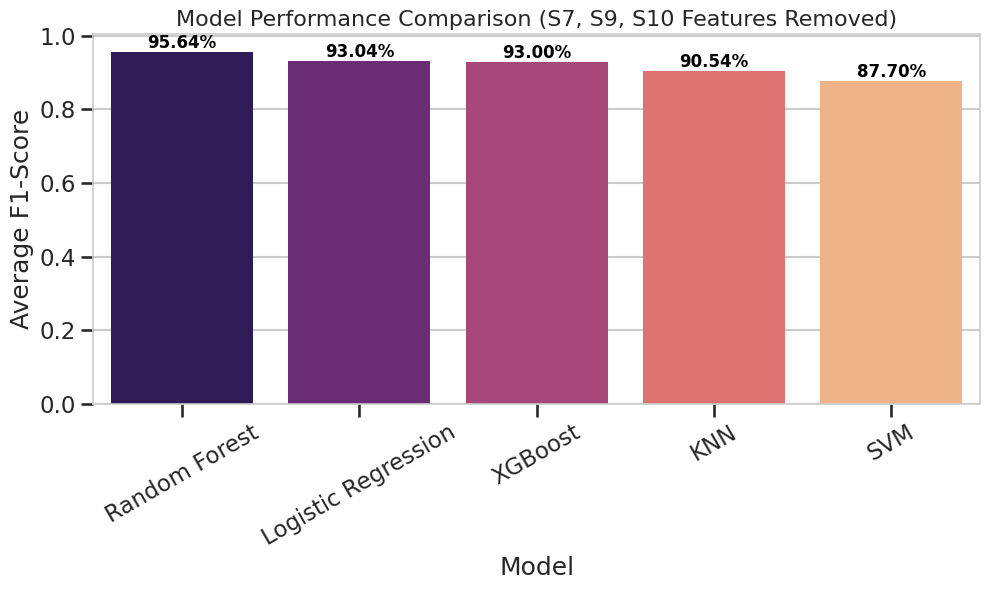

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- MEVCUT VERİ HAZIRLIĞI VE SADELEŞTİRME ---
# features_df_new_norm'un orijinal kodunuzdan geldiği varsayılır.

# 💡 Adım 1: En Önemsiz Sensörleri Çıkarma (S7, S9, S10)
# Her iki modelde de (RF ve XGBoost) neredeyse hiç kullanılmayan sensörlere ait sütunları buluruz.

columns_to_drop = [col for col in features_df_new_norm.columns if 
                   col.startswith('s7_') or
                   col.startswith('s10_') or
                   col.startswith('s6_')
                  ]

print(f"Toplam özellik sayısı (Öncesi): {features_df_new_norm.shape[1]}")

# Etiketler, kullanıcılar ve çıkarılmaması gereken diğer sütunları hariç tutun
safe_to_drop = [col for col in columns_to_drop if col not in ['label', 'user']]

features_df_simplified = features_df_new_norm.drop(safe_to_drop, axis=1)

print(f"Çıkarılan özellik sayısı: {len(safe_to_drop)}")
print(f"Toplam özellik sayısı (Sonrası): {features_df_simplified.shape[1]}")
print("-" * 50)


# --- MODELLEME VE KARŞILAŞTIRMA (Sadeleştirilmiş Veri ile) ---

# Özellikleri (X) ve etiketleri (y) ayır
X_new = features_df_simplified.drop(['label', 'user'], axis=1)
y_str_new = features_df_simplified['label']
groups_new = features_df_simplified['user']

# Etiketleri dönüştür
le_new = LabelEncoder().fit(y_str_new)
y_new = le_new.transform(y_str_new)

# Modelleri tanımla
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

logo = LeaveOneGroupOut()
results = {name: [] for name in models.keys()}

print("--- Model Comparison with Feature Selection (S7, S9, S10 Removed) ---")

# Her model için Leave-One-Group-Out CV
for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_new, y_new, groups_new)):
    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y_new[train_idx], y_new[test_idx]
    
    # Standardizasyon (Her katlamada yeniden eğitilir)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        results[name].append({"accuracy": acc, "f1_score": f1})
    # print(f"Fold {fold_idx} tamamlandı.") # İsteğe bağlı ilerleme göstergesi

# Sonuçları özetle
summary = []
for name, scores in results.items():
    avg_acc = np.mean([s["accuracy"] for s in scores])
    avg_f1 = np.mean([s["f1_score"] for s in scores])
    summary.append({"Model": name, "Average Accuracy": avg_acc, "Average F1-Score": avg_f1})

summary_df = pd.DataFrame(summary).sort_values("Average F1-Score", ascending=False)
print("\n--- Final Model Comparison (Simplified Features) ---")
print(summary_df)

# Sonuçları grafikle göster
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette="magma")

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%",  # yüzdelik format
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=12, color='black', fontweight='bold')

plt.title("Model Performance Comparison (S7, S9, S10 Features Removed)", fontsize=16)
plt.ylabel("Average F1-Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("model_comparison_simplified_features.png")
plt.show()

Toplam özellik sayısı (Öncesi): 262
Çıkarılan özellik sayısı: 40
Toplam özellik sayısı (Sonrası): 222
--------------------------------------------------
--- Model Comparison with Fine-Tuned Feature Selection (Approx. 40 Features Removed) ---


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13


--- Final Model Comparison (Fine-Tuned Features) ---
                 Model  Average Accuracy  Average F1-Score
0        Random Forest          0.963333          0.962891
3                  KNN          0.936667          0.929385
4              XGBoost          0.916667          0.913549
2  Logistic Regression          0.920000          0.909164
1                  SVM          0.866667          0.836976


/tmp/ipykernel_148/3923437373.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette="crest")


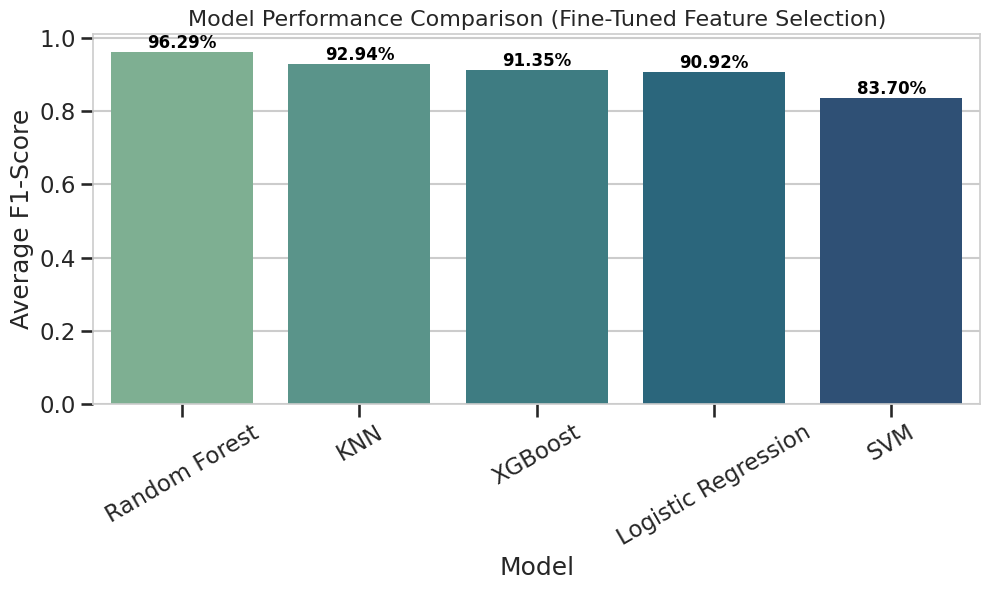

In [17]:
# Kütüphane importları önceki kodunuzdan gelmelidir.

# --- ÖZELLİK ÇIKARMA: Yeni Liste ile İnce Ayar ---

# Yeni çıkarılacak özelliklerin tam listesi (Yaklaşık 40 özellik)
features_to_remove = [
    's3_w_std', 's3_x_mean', 's3_x_max', 's3_x_range',
    's4_x_min', 's4_y_min', 's4_y_max', 's4_z_min',
    's5_w_max', 's5_w_range', 's5_x_max', 's5_x_std', 's5_y_mean', 's5_y_std',
    's6_w_max', 's6_w_range', 's6_x_min', 's6_z_min', 's6_z_max',
    's7_w_max', 's7_x_min', 's7_x_std', 's7_x_max', 's7_y_max',
    's8_w_max', 's8_x_min', 's8_x_max', 's8_y_max', 's8_z_min', 's8_z_max',
    's9_w_max', 's9_x_max', 's9_y_min', 's9_z_std',
    's10_w_max', 's10_x_max', 's10_y_min', 's10_z_mean',
    'rel_s1_s2_y_mean', 'rel_s2_s5_w_max'
]

# Çıkarılan özelliklerin gerçekten mevcut olup olmadığını kontrol et
existing_features_to_remove = [f for f in features_to_remove if f in features_df_new_norm.columns]

print(f"Toplam özellik sayısı (Öncesi): {features_df_new_norm.shape[1]}")
features_df_simplified = features_df_new_norm.drop(existing_features_to_remove, axis=1)

print(f"Çıkarılan özellik sayısı: {len(existing_features_to_remove)}")
print(f"Toplam özellik sayısı (Sonrası): {features_df_simplified.shape[1]}")
print("-" * 50)


# --- MODELLEME VE KARŞILAŞTIRMA (Sadeleştirilmiş Veri ile) ---

# Özellikleri (X) ve etiketleri (y) ayır
X_new = features_df_simplified.drop(['label', 'user'], axis=1)
y_str_new = features_df_simplified['label']
groups_new = features_df_simplified['user']

# Etiketleri dönüştür
le_new = LabelEncoder().fit(y_str_new)
y_new = le_new.transform(y_str_new)

# Modelleri tanımla (Aynı modeller kullanılacak)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

logo = LeaveOneGroupOut()
results = {name: [] for name in models.keys()}

print("--- Model Comparison with Fine-Tuned Feature Selection (Approx. 40 Features Removed) ---")

# Her model için Leave-One-Group-Out CV
for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_new, y_new, groups_new)):
    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y_new[train_idx], y_new[test_idx]
    
    # Standardizasyon
    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        results[name].append({"accuracy": acc, "f1_score": f1})

# Sonuçları özetle
summary = []
for name, scores in results.items():
    avg_acc = np.mean([s["accuracy"] for s in scores])
    avg_f1 = np.mean([s["f1_score"] for s in scores])
    summary.append({"Model": name, "Average Accuracy": avg_acc, "Average F1-Score": avg_f1})

summary_df = pd.DataFrame(summary).sort_values("Average F1-Score", ascending=False)
print("\n--- Final Model Comparison (Fine-Tuned Features) ---")
print(summary_df)

# Sonuçları grafikle göster
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette="crest")
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

plt.title("Model Performance Comparison (Fine-Tuned Feature Selection)", fontsize=16)
plt.ylabel("Average F1-Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Toplam 16 farklı sensör çıkarma senaryosu test ediliyor...
--------------------------------------------------
[1/16] Senaryo: 0-REFERANS (Tümü) | Özellik Sayısı: 260


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[2/16] Senaryo: 1-Çıkarılan: S1 | Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[3/16] Senaryo: 1-Çıkarılan: S2 | Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[4/16] Senaryo: 1-Çıkarılan: S3 | Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[5/16] Senaryo: 1-Çıkarılan: S4 | Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[6/16] Senaryo: 1-Çıkarılan: S5 | Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[7/16] Senaryo: 1-Çıkarılan: S6 | Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[8/16] Senaryo: 1-Çıkarılan: S7 | Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[9/16] Senaryo: 1-Çıkarılan: S8 | Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[10/16] Senaryo: 1-Çıkarılan: S9 | Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[11/16] Senaryo: 1-Çıkarılan: S10 | Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[12/16] Senaryo: 1-Çıkarılan: REL (Bağıl Özellikler) | Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[13/16] Senaryo: 2-Çıkarılan: S7, S9 | Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[14/16] Senaryo: 2-Çıkarılan: S7, S10 | Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[15/16] Senaryo: 2-Çıkarılan: S9, S10 | Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------
[16/16] Senaryo: 3-Çıkarılan: S7, S9, S10 | Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------


############################################################
## 🚀 KAPSAMLI SENSÖR ÇIKARMA ANALİZİ SONUÇLARI (F1 SKORLARI) ##
############################################################

                                Senaryo Çıkarılan Sensörler  Kalan Özellik Sayısı    KNN_F1  Logistic Regression_F1    SVM_F1  Random Forest_F1  XGBoost_F1 KNN_Change (%) Logistic Regression_Change (%) SVM_Change (%) Random Forest_Change (%) XGBoost_Change (%)
0                       1-Çıkarılan: S5                  S5                   240  0.947982                0.912925  0.870451          0.959791    0.930229          2.97%                          1.30%          5.68%                    1.68%             -0.34%
1                       1-Çıkarılan: S6                  S6                   240  0.934612                0.905743  0.822938          0.976428    0.936733          1.52%                          0.51%         -0.09%                    3.

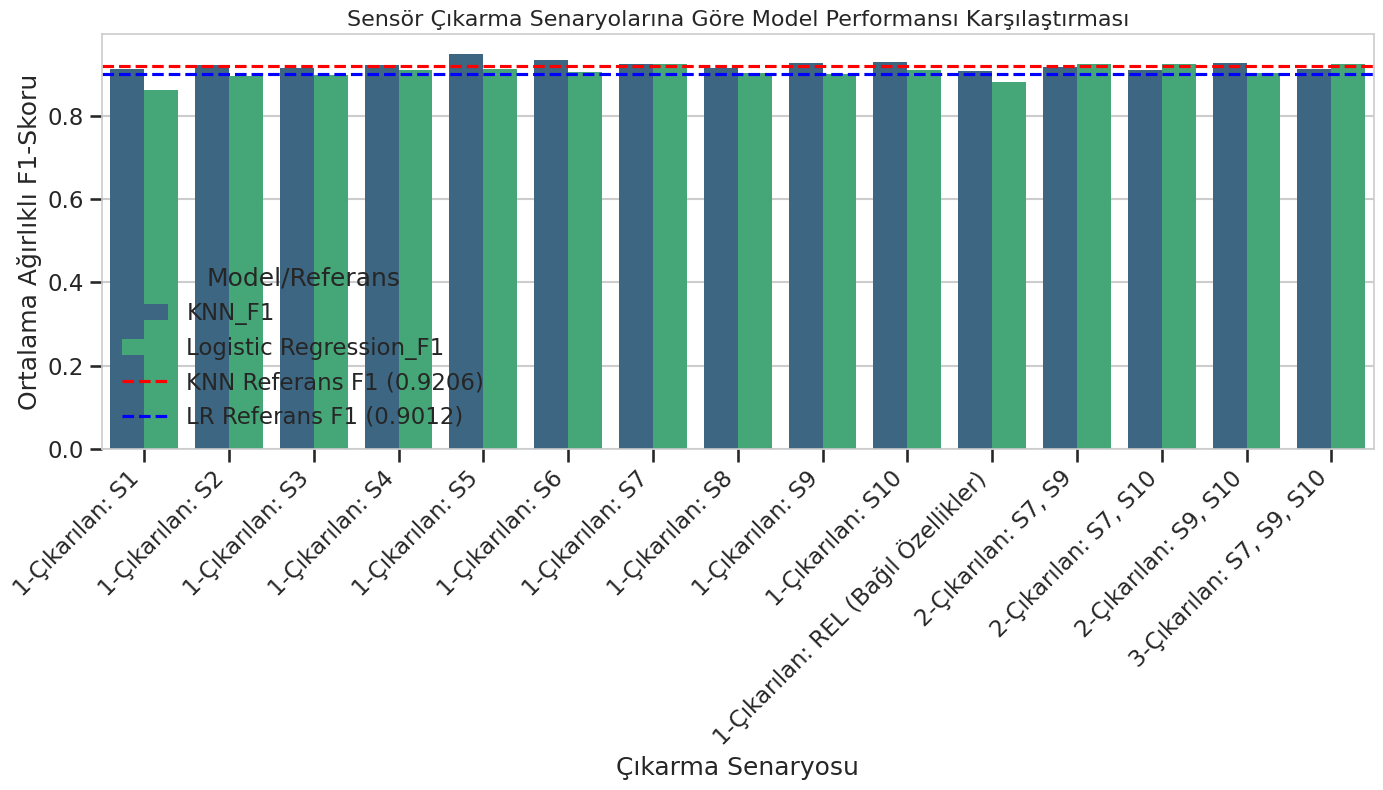



Analiz tamamlandı. Performans düşüşü yaşamayan veya iyileşen kombinasyonlara odaklanın.


In [28]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- 1. SABİT TANIMLAMALAR ---
# features_df_new_norm'un bu yeni egzersiz verilerini içerdiği varsayılır.

pd.set_option('display.max_columns', None)


# Orijinal Veri Kümesi Özellikleri ve Etiketleri
X_base = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_base = features_df_new_norm['label']
groups_base = features_df_new_norm['user']

le = LabelEncoder().fit(y_str_base)
y_base = le.transform(y_str_base)
logo = LeaveOneGroupOut()

# Modelleri tanımla (Sadece en iyi 3 veya 4 modeli seçerek süreyi kısaltabiliriz)
# Ancak kapsamlı analiz istediğiniz için tüm 5 modeli dahil ediyoruz.
MODELS = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

# Analiz edilecek tüm sensörler
ALL_SENSORS = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
# Bağıl özellikler (Rel) özel olarak ele alınacaktır.
REL_FEATURES = [col for col in X_base.columns if col.startswith('rel_')]

# --- 2. DENEME SENARYOLARINI TANIMLAMA ---

# Sensör çıkarma kombinasyonları listesi
test_scenarios = []

# Başlangıç Senaryosu (Tüm Sensörler, Referans Değer)
test_scenarios.append({
    "Scenario": "0-REFERANS (Tümü)",
    "Sensors_Removed": "Hiçbiri",
    "Columns_Removed": []
})

# 1'li Çıkarma: Her bir ana sensör tek tek çıkarılır.
for sensor in ALL_SENSORS:
    cols_to_remove = [col for col in X_base.columns if col.startswith(f'{sensor}_')]
    test_scenarios.append({
        "Scenario": f"1-Çıkarılan: {sensor.upper()}",
        "Sensors_Removed": sensor.upper(),
        "Columns_Removed": cols_to_remove
    })

# Bağıl (Rel) Özellikleri Çıkarma
test_scenarios.append({
    "Scenario": "1-Çıkarılan: REL (Bağıl Özellikler)",
    "Sensors_Removed": "REL",
    "Columns_Removed": REL_FEATURES
})

# 2'li Kombinasyonlar (Sadece en az önemli olduğu varsayılanları deneyelim: S7, S9, S10)
# Örnek: (S7, S9), (S7, S10), (S9, S10)
low_importance_sensors = ['s7', 's9', 's10']
for group in itertools.combinations(low_importance_sensors, 2):
    group_str = ", ".join(group).upper()
    cols_to_remove = [col for col in X_base.columns if col.startswith(group[0] + '_') or col.startswith(group[1] + '_')]
    test_scenarios.append({
        "Scenario": f"2-Çıkarılan: {group_str}",
        "Sensors_Removed": group_str,
        "Columns_Removed": cols_to_remove
    })
    
# 3'lü Kombinasyon (En az önemli varsayılan: S7, S9, S10)
group = ('s7', 's9', 's10')
group_str = ", ".join(group).upper()
cols_to_remove = [col for col in X_base.columns if col.startswith('s7_') or col.startswith('s9_') or col.startswith('s10_')]
test_scenarios.append({
    "Scenario": f"3-Çıkarılan: {group_str}",
    "Sensors_Removed": group_str,
    "Columns_Removed": cols_to_remove
})

# --- 3. LOGO CV FONKSİYONU ---

def run_logo_cv(X_df, y_arr, groups_arr, models):
    """Verilen X, y ve gruplar üzerinde LOGO CV uygulayarak F1 skorlarını döndürür."""
    results = {name: [] for name in models.keys()}
    
    for train_idx, test_idx in logo.split(X_df, y_arr, groups_arr):
        X_train, X_test = X_df.iloc[train_idx], X_df.iloc[test_idx]
        y_train, y_test = y_arr[train_idx], y_arr[test_idx]
        
        # Standardizasyon
        scaler = StandardScaler().fit(X_train)
        X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred, average="weighted")
            results[name].append(f1)
            
    # Ortalama F1 skorlarını hesapla
    avg_f1_scores = {name: np.mean(scores) for name, scores in results.items()}
    return avg_f1_scores

# --- 4. ANALİZİN BAŞLATILMASI ---

analysis_results = []
total_scenarios = len(test_scenarios)

print(f"Toplam {total_scenarios} farklı sensör çıkarma senaryosu test ediliyor...")
print("-" * 50)

for idx, scenario in enumerate(test_scenarios):
    scenario_name = scenario["Scenario"]
    cols_to_drop = scenario["Columns_Removed"]
    
    # Yeni X_df oluştur
    X_current = X_base.drop(cols_to_drop, axis=1, errors='ignore')
    
    print(f"[{idx + 1}/{total_scenarios}] Senaryo: {scenario_name} | Özellik Sayısı: {X_current.shape[1]}")
    
    # LOGO CV çalıştır ve F1 skorlarını al
    f1_scores = run_logo_cv(X_current, y_base, groups_base, MODELS)
    
    # Sonuçları kaydet
    result_row = {
        "Senaryo": scenario_name,
        "Çıkarılan Sensörler": scenario["Sensors_Removed"],
        "Kalan Özellik Sayısı": X_current.shape[1],
        **{f"{k}_F1": v for k, v in f1_scores.items()}
    }
    analysis_results.append(result_row)
    print("-" * 50)


# --- 5. SONUÇLARIN ÖZETLENMESİ VE GÖRSELLEŞTİRİLMESİ ---

summary_df = pd.DataFrame(analysis_results)

# Referans skorları al
reference_row = summary_df[summary_df['Senaryo'] == '0-REFERANS (Tümü)'].iloc[0]

# Performans Değişimini Hesapla
for model_name in MODELS.keys():
    f1_col = f"{model_name}_F1"
    ref_f1 = reference_row[f1_col]
    
    # Yüzdelik değişim
    summary_df[f"{model_name}_Change (%)"] = ((summary_df[f1_col] - ref_f1) / ref_f1) * 100
    
    # Değişim yüzdesini görselleştirmek için 2 ondalık hane formatı
    summary_df[f"{model_name}_Change (%)"] = summary_df[f"{model_name}_Change (%)"].map('{:.2f}%'.format)
    
# Gerekli sütunları seçerek son tabloyu oluştur
final_columns = ["Senaryo", "Çıkarılan Sensörler", "Kalan Özellik Sayısı"] + \
                [col for col in summary_df.columns if col.endswith('_F1')] + \
                [col for col in summary_df.columns if col.endswith('Change (%)')]

# Sonuçları F1 skoruna göre sırala (Örn: KNN F1 skoruna göre)
final_summary = summary_df[final_columns].sort_values(by="KNN_F1", ascending=False).reset_index(drop=True)

print("\n\n############################################################")
print("## 🚀 KAPSAMLI SENSÖR ÇIKARMA ANALİZİ SONUÇLARI (F1 SKORLARI) ##")
print("############################################################\n")
print(final_summary.to_string())

# --- Sonuçların Görselleştirilmesi (KNN ve LR modelleri için değişim) ---

# Grafiğe uygun formata dönüştür
plot_data = summary_df.drop(0).copy() # Referansı çıkar
plot_data = plot_data[['Senaryo', 'KNN_F1', 'Logistic Regression_F1']]
plot_data_melt = plot_data.melt(id_vars='Senaryo', var_name='Model', value_name='Average F1-Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Senaryo', y='Average F1-Score', hue='Model', data=plot_data_melt, palette="viridis")
plt.axhline(y=reference_row['KNN_F1'], color='r', linestyle='--', label=f"KNN Referans F1 ({reference_row['KNN_F1']:.4f})")
plt.axhline(y=reference_row['Logistic Regression_F1'], color='b', linestyle='--', label=f"LR Referans F1 ({reference_row['Logistic Regression_F1']:.4f})")
plt.title('Sensör Çıkarma Senaryolarına Göre Model Performansı Karşılaştırması', fontsize=16)
plt.ylabel('Ortalama Ağırlıklı F1-Skoru')
plt.xlabel('Çıkarma Senaryosu')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model/Referans', loc='lower left')
plt.tight_layout()
plt.show()

print("\n\nAnaliz tamamlandı. Performans düşüşü yaşamayan veya iyileşen kombinasyonlara odaklanın.")

Toplam 1024 farklı sensör çıkarma senaryosu test edilecek (Her model için 300 katlama). Bu süreç zaman alabilir.
--------------------------------------------------------------------------------
[1/1024] Deneniyor: 0-REFERANS (Tümü) | Kalan Özellik Sayısı: 260


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[2/1024] Deneniyor: 1-Çıkarılan: REL (Bağıl Özellikler) | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[3/1024] Deneniyor: 1-Çıkarılan: S1 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[4/1024] Deneniyor: 1-Çıkarılan: S2 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[5/1024] Deneniyor: 1-Çıkarılan: S3 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[6/1024] Deneniyor: 1-Çıkarılan: S4 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[7/1024] Deneniyor: 1-Çıkarılan: S5 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[8/1024] Deneniyor: 1-Çıkarılan: S6 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[9/1024] Deneniyor: 1-Çıkarılan: S7 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[10/1024] Deneniyor: 1-Çıkarılan: S8 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[11/1024] Deneniyor: 1-Çıkarılan: S9 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[12/1024] Deneniyor: 1-Çıkarılan: S10 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[13/1024] Deneniyor: 2-Çıkarılan: S1, S2 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[14/1024] Deneniyor: 2-Çıkarılan: S1, S3 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[15/1024] Deneniyor: 2-Çıkarılan: S1, S4 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[16/1024] Deneniyor: 2-Çıkarılan: S1, S5 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[17/1024] Deneniyor: 2-Çıkarılan: S1, S6 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[18/1024] Deneniyor: 2-Çıkarılan: S1, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[19/1024] Deneniyor: 2-Çıkarılan: S1, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[20/1024] Deneniyor: 2-Çıkarılan: S1, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[21/1024] Deneniyor: 2-Çıkarılan: S1, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[22/1024] Deneniyor: 2-Çıkarılan: S2, S3 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[23/1024] Deneniyor: 2-Çıkarılan: S2, S4 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[24/1024] Deneniyor: 2-Çıkarılan: S2, S5 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[25/1024] Deneniyor: 2-Çıkarılan: S2, S6 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[26/1024] Deneniyor: 2-Çıkarılan: S2, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[27/1024] Deneniyor: 2-Çıkarılan: S2, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[28/1024] Deneniyor: 2-Çıkarılan: S2, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[29/1024] Deneniyor: 2-Çıkarılan: S2, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[30/1024] Deneniyor: 2-Çıkarılan: S3, S4 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[31/1024] Deneniyor: 2-Çıkarılan: S3, S5 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[32/1024] Deneniyor: 2-Çıkarılan: S3, S6 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[33/1024] Deneniyor: 2-Çıkarılan: S3, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[34/1024] Deneniyor: 2-Çıkarılan: S3, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[35/1024] Deneniyor: 2-Çıkarılan: S3, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[36/1024] Deneniyor: 2-Çıkarılan: S3, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[37/1024] Deneniyor: 2-Çıkarılan: S4, S5 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:47:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[38/1024] Deneniyor: 2-Çıkarılan: S4, S6 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[39/1024] Deneniyor: 2-Çıkarılan: S4, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[40/1024] Deneniyor: 2-Çıkarılan: S4, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[41/1024] Deneniyor: 2-Çıkarılan: S4, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[42/1024] Deneniyor: 2-Çıkarılan: S4, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[43/1024] Deneniyor: 2-Çıkarılan: S5, S6 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[44/1024] Deneniyor: 2-Çıkarılan: S5, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[45/1024] Deneniyor: 2-Çıkarılan: S5, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[46/1024] Deneniyor: 2-Çıkarılan: S5, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[47/1024] Deneniyor: 2-Çıkarılan: S5, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[48/1024] Deneniyor: 2-Çıkarılan: S6, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[49/1024] Deneniyor: 2-Çıkarılan: S6, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[50/1024] Deneniyor: 2-Çıkarılan: S6, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[51/1024] Deneniyor: 2-Çıkarılan: S6, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[52/1024] Deneniyor: 2-Çıkarılan: S7, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[53/1024] Deneniyor: 2-Çıkarılan: S7, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[54/1024] Deneniyor: 2-Çıkarılan: S7, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[55/1024] Deneniyor: 2-Çıkarılan: S8, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[56/1024] Deneniyor: 2-Çıkarılan: S8, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[57/1024] Deneniyor: 2-Çıkarılan: S9, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[58/1024] Deneniyor: 3-Çıkarılan: S1, S2, S3 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[59/1024] Deneniyor: 3-Çıkarılan: S1, S2, S4 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[60/1024] Deneniyor: 3-Çıkarılan: S1, S2, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[61/1024] Deneniyor: 3-Çıkarılan: S1, S2, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:48:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[62/1024] Deneniyor: 3-Çıkarılan: S1, S2, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[63/1024] Deneniyor: 3-Çıkarılan: S1, S2, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[64/1024] Deneniyor: 3-Çıkarılan: S1, S2, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[65/1024] Deneniyor: 3-Çıkarılan: S1, S2, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[66/1024] Deneniyor: 3-Çıkarılan: S1, S3, S4 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[67/1024] Deneniyor: 3-Çıkarılan: S1, S3, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[68/1024] Deneniyor: 3-Çıkarılan: S1, S3, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[69/1024] Deneniyor: 3-Çıkarılan: S1, S3, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[70/1024] Deneniyor: 3-Çıkarılan: S1, S3, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[71/1024] Deneniyor: 3-Çıkarılan: S1, S3, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[72/1024] Deneniyor: 3-Çıkarılan: S1, S3, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[73/1024] Deneniyor: 3-Çıkarılan: S1, S4, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[74/1024] Deneniyor: 3-Çıkarılan: S1, S4, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[75/1024] Deneniyor: 3-Çıkarılan: S1, S4, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[76/1024] Deneniyor: 3-Çıkarılan: S1, S4, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[77/1024] Deneniyor: 3-Çıkarılan: S1, S4, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[78/1024] Deneniyor: 3-Çıkarılan: S1, S4, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[79/1024] Deneniyor: 3-Çıkarılan: S1, S5, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[80/1024] Deneniyor: 3-Çıkarılan: S1, S5, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[81/1024] Deneniyor: 3-Çıkarılan: S1, S5, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[82/1024] Deneniyor: 3-Çıkarılan: S1, S5, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[83/1024] Deneniyor: 3-Çıkarılan: S1, S5, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[84/1024] Deneniyor: 3-Çıkarılan: S1, S6, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[85/1024] Deneniyor: 3-Çıkarılan: S1, S6, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[86/1024] Deneniyor: 3-Çıkarılan: S1, S6, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:49:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[87/1024] Deneniyor: 3-Çıkarılan: S1, S6, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[88/1024] Deneniyor: 3-Çıkarılan: S1, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[89/1024] Deneniyor: 3-Çıkarılan: S1, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[90/1024] Deneniyor: 3-Çıkarılan: S1, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[91/1024] Deneniyor: 3-Çıkarılan: S1, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[92/1024] Deneniyor: 3-Çıkarılan: S1, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[93/1024] Deneniyor: 3-Çıkarılan: S1, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[94/1024] Deneniyor: 3-Çıkarılan: S2, S3, S4 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[95/1024] Deneniyor: 3-Çıkarılan: S2, S3, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[96/1024] Deneniyor: 3-Çıkarılan: S2, S3, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[97/1024] Deneniyor: 3-Çıkarılan: S2, S3, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[98/1024] Deneniyor: 3-Çıkarılan: S2, S3, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[99/1024] Deneniyor: 3-Çıkarılan: S2, S3, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[100/1024] Deneniyor: 3-Çıkarılan: S2, S3, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[101/1024] Deneniyor: 3-Çıkarılan: S2, S4, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[102/1024] Deneniyor: 3-Çıkarılan: S2, S4, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[103/1024] Deneniyor: 3-Çıkarılan: S2, S4, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[104/1024] Deneniyor: 3-Çıkarılan: S2, S4, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[105/1024] Deneniyor: 3-Çıkarılan: S2, S4, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[106/1024] Deneniyor: 3-Çıkarılan: S2, S4, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[107/1024] Deneniyor: 3-Çıkarılan: S2, S5, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[108/1024] Deneniyor: 3-Çıkarılan: S2, S5, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[109/1024] Deneniyor: 3-Çıkarılan: S2, S5, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[110/1024] Deneniyor: 3-Çıkarılan: S2, S5, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[111/1024] Deneniyor: 3-Çıkarılan: S2, S5, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[112/1024] Deneniyor: 3-Çıkarılan: S2, S6, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:50:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[113/1024] Deneniyor: 3-Çıkarılan: S2, S6, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[114/1024] Deneniyor: 3-Çıkarılan: S2, S6, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[115/1024] Deneniyor: 3-Çıkarılan: S2, S6, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[116/1024] Deneniyor: 3-Çıkarılan: S2, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[117/1024] Deneniyor: 3-Çıkarılan: S2, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[118/1024] Deneniyor: 3-Çıkarılan: S2, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[119/1024] Deneniyor: 3-Çıkarılan: S2, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[120/1024] Deneniyor: 3-Çıkarılan: S2, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[121/1024] Deneniyor: 3-Çıkarılan: S2, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[122/1024] Deneniyor: 3-Çıkarılan: S3, S4, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[123/1024] Deneniyor: 3-Çıkarılan: S3, S4, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[124/1024] Deneniyor: 3-Çıkarılan: S3, S4, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[125/1024] Deneniyor: 3-Çıkarılan: S3, S4, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[126/1024] Deneniyor: 3-Çıkarılan: S3, S4, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[127/1024] Deneniyor: 3-Çıkarılan: S3, S4, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[128/1024] Deneniyor: 3-Çıkarılan: S3, S5, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[129/1024] Deneniyor: 3-Çıkarılan: S3, S5, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[130/1024] Deneniyor: 3-Çıkarılan: S3, S5, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[131/1024] Deneniyor: 3-Çıkarılan: S3, S5, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[132/1024] Deneniyor: 3-Çıkarılan: S3, S5, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[133/1024] Deneniyor: 3-Çıkarılan: S3, S6, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[134/1024] Deneniyor: 3-Çıkarılan: S3, S6, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[135/1024] Deneniyor: 3-Çıkarılan: S3, S6, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[136/1024] Deneniyor: 3-Çıkarılan: S3, S6, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[137/1024] Deneniyor: 3-Çıkarılan: S3, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[138/1024] Deneniyor: 3-Çıkarılan: S3, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:51:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[139/1024] Deneniyor: 3-Çıkarılan: S3, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[140/1024] Deneniyor: 3-Çıkarılan: S3, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[141/1024] Deneniyor: 3-Çıkarılan: S3, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[142/1024] Deneniyor: 3-Çıkarılan: S3, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[143/1024] Deneniyor: 3-Çıkarılan: S4, S5, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[144/1024] Deneniyor: 3-Çıkarılan: S4, S5, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[145/1024] Deneniyor: 3-Çıkarılan: S4, S5, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[146/1024] Deneniyor: 3-Çıkarılan: S4, S5, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[147/1024] Deneniyor: 3-Çıkarılan: S4, S5, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[148/1024] Deneniyor: 3-Çıkarılan: S4, S6, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[149/1024] Deneniyor: 3-Çıkarılan: S4, S6, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[150/1024] Deneniyor: 3-Çıkarılan: S4, S6, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[151/1024] Deneniyor: 3-Çıkarılan: S4, S6, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[152/1024] Deneniyor: 3-Çıkarılan: S4, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[153/1024] Deneniyor: 3-Çıkarılan: S4, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[154/1024] Deneniyor: 3-Çıkarılan: S4, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[155/1024] Deneniyor: 3-Çıkarılan: S4, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[156/1024] Deneniyor: 3-Çıkarılan: S4, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[157/1024] Deneniyor: 3-Çıkarılan: S4, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[158/1024] Deneniyor: 3-Çıkarılan: S5, S6, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[159/1024] Deneniyor: 3-Çıkarılan: S5, S6, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[160/1024] Deneniyor: 3-Çıkarılan: S5, S6, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[161/1024] Deneniyor: 3-Çıkarılan: S5, S6, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[162/1024] Deneniyor: 3-Çıkarılan: S5, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[163/1024] Deneniyor: 3-Çıkarılan: S5, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[164/1024] Deneniyor: 3-Çıkarılan: S5, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[165/1024] Deneniyor: 3-Çıkarılan: S5, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:52:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[166/1024] Deneniyor: 3-Çıkarılan: S5, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[167/1024] Deneniyor: 3-Çıkarılan: S5, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[168/1024] Deneniyor: 3-Çıkarılan: S6, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[169/1024] Deneniyor: 3-Çıkarılan: S6, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[170/1024] Deneniyor: 3-Çıkarılan: S6, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[171/1024] Deneniyor: 3-Çıkarılan: S6, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[172/1024] Deneniyor: 3-Çıkarılan: S6, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[173/1024] Deneniyor: 3-Çıkarılan: S6, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[174/1024] Deneniyor: 3-Çıkarılan: S7, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[175/1024] Deneniyor: 3-Çıkarılan: S7, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[176/1024] Deneniyor: 3-Çıkarılan: S7, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[177/1024] Deneniyor: 3-Çıkarılan: S8, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[178/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S4 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[179/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S5 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[180/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[181/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[182/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[183/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[184/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[185/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S5 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[186/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[187/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[188/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[189/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[190/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[191/1024] Deneniyor: 4-Çıkarılan: S1, S2, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[192/1024] Deneniyor: 4-Çıkarılan: S1, S2, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[193/1024] Deneniyor: 4-Çıkarılan: S1, S2, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[194/1024] Deneniyor: 4-Çıkarılan: S1, S2, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[195/1024] Deneniyor: 4-Çıkarılan: S1, S2, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[196/1024] Deneniyor: 4-Çıkarılan: S1, S2, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[197/1024] Deneniyor: 4-Çıkarılan: S1, S2, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[198/1024] Deneniyor: 4-Çıkarılan: S1, S2, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[199/1024] Deneniyor: 4-Çıkarılan: S1, S2, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[200/1024] Deneniyor: 4-Çıkarılan: S1, S2, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[201/1024] Deneniyor: 4-Çıkarılan: S1, S2, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[202/1024] Deneniyor: 4-Çıkarılan: S1, S2, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[203/1024] Deneniyor: 4-Çıkarılan: S1, S2, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[204/1024] Deneniyor: 4-Çıkarılan: S1, S2, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[205/1024] Deneniyor: 4-Çıkarılan: S1, S2, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[206/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S5 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[207/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[208/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[209/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[210/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[211/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[212/1024] Deneniyor: 4-Çıkarılan: S1, S3, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[213/1024] Deneniyor: 4-Çıkarılan: S1, S3, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[214/1024] Deneniyor: 4-Çıkarılan: S1, S3, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[215/1024] Deneniyor: 4-Çıkarılan: S1, S3, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[216/1024] Deneniyor: 4-Çıkarılan: S1, S3, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[217/1024] Deneniyor: 4-Çıkarılan: S1, S3, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[218/1024] Deneniyor: 4-Çıkarılan: S1, S3, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:54:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[219/1024] Deneniyor: 4-Çıkarılan: S1, S3, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[220/1024] Deneniyor: 4-Çıkarılan: S1, S3, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[221/1024] Deneniyor: 4-Çıkarılan: S1, S3, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[222/1024] Deneniyor: 4-Çıkarılan: S1, S3, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[223/1024] Deneniyor: 4-Çıkarılan: S1, S3, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[224/1024] Deneniyor: 4-Çıkarılan: S1, S3, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[225/1024] Deneniyor: 4-Çıkarılan: S1, S3, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[226/1024] Deneniyor: 4-Çıkarılan: S1, S3, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[227/1024] Deneniyor: 4-Çıkarılan: S1, S4, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[228/1024] Deneniyor: 4-Çıkarılan: S1, S4, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[229/1024] Deneniyor: 4-Çıkarılan: S1, S4, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[230/1024] Deneniyor: 4-Çıkarılan: S1, S4, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[231/1024] Deneniyor: 4-Çıkarılan: S1, S4, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[232/1024] Deneniyor: 4-Çıkarılan: S1, S4, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[233/1024] Deneniyor: 4-Çıkarılan: S1, S4, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[234/1024] Deneniyor: 4-Çıkarılan: S1, S4, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[235/1024] Deneniyor: 4-Çıkarılan: S1, S4, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[236/1024] Deneniyor: 4-Çıkarılan: S1, S4, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[237/1024] Deneniyor: 4-Çıkarılan: S1, S4, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[238/1024] Deneniyor: 4-Çıkarılan: S1, S4, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[239/1024] Deneniyor: 4-Çıkarılan: S1, S4, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[240/1024] Deneniyor: 4-Çıkarılan: S1, S4, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[241/1024] Deneniyor: 4-Çıkarılan: S1, S4, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[242/1024] Deneniyor: 4-Çıkarılan: S1, S5, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[243/1024] Deneniyor: 4-Çıkarılan: S1, S5, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[244/1024] Deneniyor: 4-Çıkarılan: S1, S5, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[245/1024] Deneniyor: 4-Çıkarılan: S1, S5, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:55:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[246/1024] Deneniyor: 4-Çıkarılan: S1, S5, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[247/1024] Deneniyor: 4-Çıkarılan: S1, S5, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[248/1024] Deneniyor: 4-Çıkarılan: S1, S5, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[249/1024] Deneniyor: 4-Çıkarılan: S1, S5, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[250/1024] Deneniyor: 4-Çıkarılan: S1, S5, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[251/1024] Deneniyor: 4-Çıkarılan: S1, S5, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[252/1024] Deneniyor: 4-Çıkarılan: S1, S6, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[253/1024] Deneniyor: 4-Çıkarılan: S1, S6, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[254/1024] Deneniyor: 4-Çıkarılan: S1, S6, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[255/1024] Deneniyor: 4-Çıkarılan: S1, S6, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[256/1024] Deneniyor: 4-Çıkarılan: S1, S6, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[257/1024] Deneniyor: 4-Çıkarılan: S1, S6, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[258/1024] Deneniyor: 4-Çıkarılan: S1, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[259/1024] Deneniyor: 4-Çıkarılan: S1, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[260/1024] Deneniyor: 4-Çıkarılan: S1, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[261/1024] Deneniyor: 4-Çıkarılan: S1, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[262/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S5 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[263/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[264/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[265/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[266/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[267/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[268/1024] Deneniyor: 4-Çıkarılan: S2, S3, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[269/1024] Deneniyor: 4-Çıkarılan: S2, S3, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[270/1024] Deneniyor: 4-Çıkarılan: S2, S3, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[271/1024] Deneniyor: 4-Çıkarılan: S2, S3, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[272/1024] Deneniyor: 4-Çıkarılan: S2, S3, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:56:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[273/1024] Deneniyor: 4-Çıkarılan: S2, S3, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[274/1024] Deneniyor: 4-Çıkarılan: S2, S3, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[275/1024] Deneniyor: 4-Çıkarılan: S2, S3, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[276/1024] Deneniyor: 4-Çıkarılan: S2, S3, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[277/1024] Deneniyor: 4-Çıkarılan: S2, S3, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[278/1024] Deneniyor: 4-Çıkarılan: S2, S3, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[279/1024] Deneniyor: 4-Çıkarılan: S2, S3, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[280/1024] Deneniyor: 4-Çıkarılan: S2, S3, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[281/1024] Deneniyor: 4-Çıkarılan: S2, S3, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[282/1024] Deneniyor: 4-Çıkarılan: S2, S3, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[283/1024] Deneniyor: 4-Çıkarılan: S2, S4, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[284/1024] Deneniyor: 4-Çıkarılan: S2, S4, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[285/1024] Deneniyor: 4-Çıkarılan: S2, S4, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[286/1024] Deneniyor: 4-Çıkarılan: S2, S4, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[287/1024] Deneniyor: 4-Çıkarılan: S2, S4, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[288/1024] Deneniyor: 4-Çıkarılan: S2, S4, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[289/1024] Deneniyor: 4-Çıkarılan: S2, S4, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[290/1024] Deneniyor: 4-Çıkarılan: S2, S4, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[291/1024] Deneniyor: 4-Çıkarılan: S2, S4, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[292/1024] Deneniyor: 4-Çıkarılan: S2, S4, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[293/1024] Deneniyor: 4-Çıkarılan: S2, S4, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[294/1024] Deneniyor: 4-Çıkarılan: S2, S4, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[295/1024] Deneniyor: 4-Çıkarılan: S2, S4, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[296/1024] Deneniyor: 4-Çıkarılan: S2, S4, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[297/1024] Deneniyor: 4-Çıkarılan: S2, S4, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[298/1024] Deneniyor: 4-Çıkarılan: S2, S5, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[299/1024] Deneniyor: 4-Çıkarılan: S2, S5, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[300/1024] Deneniyor: 4-Çıkarılan: S2, S5, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:57:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[301/1024] Deneniyor: 4-Çıkarılan: S2, S5, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[302/1024] Deneniyor: 4-Çıkarılan: S2, S5, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[303/1024] Deneniyor: 4-Çıkarılan: S2, S5, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[304/1024] Deneniyor: 4-Çıkarılan: S2, S5, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[305/1024] Deneniyor: 4-Çıkarılan: S2, S5, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[306/1024] Deneniyor: 4-Çıkarılan: S2, S5, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[307/1024] Deneniyor: 4-Çıkarılan: S2, S5, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[308/1024] Deneniyor: 4-Çıkarılan: S2, S6, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[309/1024] Deneniyor: 4-Çıkarılan: S2, S6, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[310/1024] Deneniyor: 4-Çıkarılan: S2, S6, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[311/1024] Deneniyor: 4-Çıkarılan: S2, S6, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[312/1024] Deneniyor: 4-Çıkarılan: S2, S6, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[313/1024] Deneniyor: 4-Çıkarılan: S2, S6, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[314/1024] Deneniyor: 4-Çıkarılan: S2, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[315/1024] Deneniyor: 4-Çıkarılan: S2, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[316/1024] Deneniyor: 4-Çıkarılan: S2, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[317/1024] Deneniyor: 4-Çıkarılan: S2, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[318/1024] Deneniyor: 4-Çıkarılan: S3, S4, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[319/1024] Deneniyor: 4-Çıkarılan: S3, S4, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[320/1024] Deneniyor: 4-Çıkarılan: S3, S4, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[321/1024] Deneniyor: 4-Çıkarılan: S3, S4, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[322/1024] Deneniyor: 4-Çıkarılan: S3, S4, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[323/1024] Deneniyor: 4-Çıkarılan: S3, S4, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[324/1024] Deneniyor: 4-Çıkarılan: S3, S4, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[325/1024] Deneniyor: 4-Çıkarılan: S3, S4, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[326/1024] Deneniyor: 4-Çıkarılan: S3, S4, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[327/1024] Deneniyor: 4-Çıkarılan: S3, S4, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:58:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[328/1024] Deneniyor: 4-Çıkarılan: S3, S4, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[329/1024] Deneniyor: 4-Çıkarılan: S3, S4, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[330/1024] Deneniyor: 4-Çıkarılan: S3, S4, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[331/1024] Deneniyor: 4-Çıkarılan: S3, S4, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[332/1024] Deneniyor: 4-Çıkarılan: S3, S4, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[333/1024] Deneniyor: 4-Çıkarılan: S3, S5, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[334/1024] Deneniyor: 4-Çıkarılan: S3, S5, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[335/1024] Deneniyor: 4-Çıkarılan: S3, S5, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[336/1024] Deneniyor: 4-Çıkarılan: S3, S5, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[337/1024] Deneniyor: 4-Çıkarılan: S3, S5, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[338/1024] Deneniyor: 4-Çıkarılan: S3, S5, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[339/1024] Deneniyor: 4-Çıkarılan: S3, S5, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[340/1024] Deneniyor: 4-Çıkarılan: S3, S5, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[341/1024] Deneniyor: 4-Çıkarılan: S3, S5, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[342/1024] Deneniyor: 4-Çıkarılan: S3, S5, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[343/1024] Deneniyor: 4-Çıkarılan: S3, S6, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[344/1024] Deneniyor: 4-Çıkarılan: S3, S6, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[345/1024] Deneniyor: 4-Çıkarılan: S3, S6, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[346/1024] Deneniyor: 4-Çıkarılan: S3, S6, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[347/1024] Deneniyor: 4-Çıkarılan: S3, S6, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[348/1024] Deneniyor: 4-Çıkarılan: S3, S6, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[349/1024] Deneniyor: 4-Çıkarılan: S3, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[350/1024] Deneniyor: 4-Çıkarılan: S3, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[351/1024] Deneniyor: 4-Çıkarılan: S3, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[352/1024] Deneniyor: 4-Çıkarılan: S3, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[353/1024] Deneniyor: 4-Çıkarılan: S4, S5, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[354/1024] Deneniyor: 4-Çıkarılan: S4, S5, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[355/1024] Deneniyor: 4-Çıkarılan: S4, S5, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:59:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[356/1024] Deneniyor: 4-Çıkarılan: S4, S5, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[357/1024] Deneniyor: 4-Çıkarılan: S4, S5, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[358/1024] Deneniyor: 4-Çıkarılan: S4, S5, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[359/1024] Deneniyor: 4-Çıkarılan: S4, S5, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[360/1024] Deneniyor: 4-Çıkarılan: S4, S5, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[361/1024] Deneniyor: 4-Çıkarılan: S4, S5, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[362/1024] Deneniyor: 4-Çıkarılan: S4, S5, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[363/1024] Deneniyor: 4-Çıkarılan: S4, S6, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[364/1024] Deneniyor: 4-Çıkarılan: S4, S6, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[365/1024] Deneniyor: 4-Çıkarılan: S4, S6, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[366/1024] Deneniyor: 4-Çıkarılan: S4, S6, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[367/1024] Deneniyor: 4-Çıkarılan: S4, S6, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[368/1024] Deneniyor: 4-Çıkarılan: S4, S6, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[369/1024] Deneniyor: 4-Çıkarılan: S4, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[370/1024] Deneniyor: 4-Çıkarılan: S4, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[371/1024] Deneniyor: 4-Çıkarılan: S4, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[372/1024] Deneniyor: 4-Çıkarılan: S4, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[373/1024] Deneniyor: 4-Çıkarılan: S5, S6, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[374/1024] Deneniyor: 4-Çıkarılan: S5, S6, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[375/1024] Deneniyor: 4-Çıkarılan: S5, S6, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[376/1024] Deneniyor: 4-Çıkarılan: S5, S6, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[377/1024] Deneniyor: 4-Çıkarılan: S5, S6, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[378/1024] Deneniyor: 4-Çıkarılan: S5, S6, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[379/1024] Deneniyor: 4-Çıkarılan: S5, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[380/1024] Deneniyor: 4-Çıkarılan: S5, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[381/1024] Deneniyor: 4-Çıkarılan: S5, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[382/1024] Deneniyor: 4-Çıkarılan: S5, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:00:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[383/1024] Deneniyor: 4-Çıkarılan: S6, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[384/1024] Deneniyor: 4-Çıkarılan: S6, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[385/1024] Deneniyor: 4-Çıkarılan: S6, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[386/1024] Deneniyor: 4-Çıkarılan: S6, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[387/1024] Deneniyor: 4-Çıkarılan: S7, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[388/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S5 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[389/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S6 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[390/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[391/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[392/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[393/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[394/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S5, S6 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[395/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S5, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[396/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S5, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[397/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S5, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[398/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S5, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[399/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[400/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[401/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[402/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[403/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[404/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[405/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[406/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[407/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[408/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[409/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S5, S6 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[410/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S5, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:01:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[411/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S5, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[412/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S5, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[413/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S5, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[414/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[415/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[416/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[417/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[418/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[419/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[420/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[421/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[422/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[423/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[424/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[425/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[426/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[427/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[428/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[429/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[430/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[431/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[432/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[433/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[434/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[435/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[436/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[437/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[438/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[439/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[440/1024] Deneniyor: 5-Çıkarılan: S1, S2, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[441/1024] Deneniyor: 5-Çıkarılan: S1, S2, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[442/1024] Deneniyor: 5-Çıkarılan: S1, S2, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[443/1024] Deneniyor: 5-Çıkarılan: S1, S2, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[444/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S5, S6 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[445/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S5, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[446/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S5, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[447/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S5, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[448/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S5, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[449/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[450/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[451/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[452/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[453/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[454/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[455/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[456/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[457/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[458/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[459/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[460/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[461/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[462/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[463/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[464/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[465/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[466/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:03:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[467/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[468/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[469/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[470/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[471/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[472/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[473/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[474/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[475/1024] Deneniyor: 5-Çıkarılan: S1, S3, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[476/1024] Deneniyor: 5-Çıkarılan: S1, S3, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[477/1024] Deneniyor: 5-Çıkarılan: S1, S3, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[478/1024] Deneniyor: 5-Çıkarılan: S1, S3, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[479/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[480/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[481/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[482/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[483/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[484/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[485/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[486/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[487/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[488/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[489/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[490/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[491/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[492/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[493/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[494/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:04:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[495/1024] Deneniyor: 5-Çıkarılan: S1, S4, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[496/1024] Deneniyor: 5-Çıkarılan: S1, S4, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[497/1024] Deneniyor: 5-Çıkarılan: S1, S4, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[498/1024] Deneniyor: 5-Çıkarılan: S1, S4, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[499/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[500/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[501/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[502/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[503/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[504/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[505/1024] Deneniyor: 5-Çıkarılan: S1, S5, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[506/1024] Deneniyor: 5-Çıkarılan: S1, S5, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[507/1024] Deneniyor: 5-Çıkarılan: S1, S5, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[508/1024] Deneniyor: 5-Çıkarılan: S1, S5, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[509/1024] Deneniyor: 5-Çıkarılan: S1, S6, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[510/1024] Deneniyor: 5-Çıkarılan: S1, S6, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[511/1024] Deneniyor: 5-Çıkarılan: S1, S6, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[512/1024] Deneniyor: 5-Çıkarılan: S1, S6, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[513/1024] Deneniyor: 5-Çıkarılan: S1, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[514/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S5, S6 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[515/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S5, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[516/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S5, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[517/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S5, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[518/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S5, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[519/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[520/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[521/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[522/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:05:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[523/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[524/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[525/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[526/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[527/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[528/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[529/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[530/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[531/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[532/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[533/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[534/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[535/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[536/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[537/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[538/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[539/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[540/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[541/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[542/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[543/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[544/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[545/1024] Deneniyor: 5-Çıkarılan: S2, S3, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[546/1024] Deneniyor: 5-Çıkarılan: S2, S3, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[547/1024] Deneniyor: 5-Çıkarılan: S2, S3, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[548/1024] Deneniyor: 5-Çıkarılan: S2, S3, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[549/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[550/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[551/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[552/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[553/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[554/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[555/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[556/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[557/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[558/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[559/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[560/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[561/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[562/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[563/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[564/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[565/1024] Deneniyor: 5-Çıkarılan: S2, S4, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[566/1024] Deneniyor: 5-Çıkarılan: S2, S4, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[567/1024] Deneniyor: 5-Çıkarılan: S2, S4, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[568/1024] Deneniyor: 5-Çıkarılan: S2, S4, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[569/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[570/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[571/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[572/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[573/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[574/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[575/1024] Deneniyor: 5-Çıkarılan: S2, S5, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[576/1024] Deneniyor: 5-Çıkarılan: S2, S5, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[577/1024] Deneniyor: 5-Çıkarılan: S2, S5, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[578/1024] Deneniyor: 5-Çıkarılan: S2, S5, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[579/1024] Deneniyor: 5-Çıkarılan: S2, S6, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[580/1024] Deneniyor: 5-Çıkarılan: S2, S6, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:07:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[581/1024] Deneniyor: 5-Çıkarılan: S2, S6, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[582/1024] Deneniyor: 5-Çıkarılan: S2, S6, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[583/1024] Deneniyor: 5-Çıkarılan: S2, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[584/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[585/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[586/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[587/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[588/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[589/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[590/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[591/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[592/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[593/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[594/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[595/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[596/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[597/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[598/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[599/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[600/1024] Deneniyor: 5-Çıkarılan: S3, S4, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[601/1024] Deneniyor: 5-Çıkarılan: S3, S4, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[602/1024] Deneniyor: 5-Çıkarılan: S3, S4, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[603/1024] Deneniyor: 5-Çıkarılan: S3, S4, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[604/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[605/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[606/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[607/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[608/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[609/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[610/1024] Deneniyor: 5-Çıkarılan: S3, S5, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:08:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[611/1024] Deneniyor: 5-Çıkarılan: S3, S5, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[612/1024] Deneniyor: 5-Çıkarılan: S3, S5, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[613/1024] Deneniyor: 5-Çıkarılan: S3, S5, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[614/1024] Deneniyor: 5-Çıkarılan: S3, S6, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[615/1024] Deneniyor: 5-Çıkarılan: S3, S6, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[616/1024] Deneniyor: 5-Çıkarılan: S3, S6, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[617/1024] Deneniyor: 5-Çıkarılan: S3, S6, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[618/1024] Deneniyor: 5-Çıkarılan: S3, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[619/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[620/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[621/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[622/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[623/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[624/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[625/1024] Deneniyor: 5-Çıkarılan: S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[626/1024] Deneniyor: 5-Çıkarılan: S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[627/1024] Deneniyor: 5-Çıkarılan: S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[628/1024] Deneniyor: 5-Çıkarılan: S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[629/1024] Deneniyor: 5-Çıkarılan: S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[630/1024] Deneniyor: 5-Çıkarılan: S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[631/1024] Deneniyor: 5-Çıkarılan: S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[632/1024] Deneniyor: 5-Çıkarılan: S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[633/1024] Deneniyor: 5-Çıkarılan: S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[634/1024] Deneniyor: 5-Çıkarılan: S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[635/1024] Deneniyor: 5-Çıkarılan: S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[636/1024] Deneniyor: 5-Çıkarılan: S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[637/1024] Deneniyor: 5-Çıkarılan: S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[638/1024] Deneniyor: 5-Çıkarılan: S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[639/1024] Deneniyor: 5-Çıkarılan: S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:09:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[640/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S5, S6 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[641/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S5, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[642/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S5, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[643/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S5, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[644/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S5, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[645/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S6, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[646/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S6, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[647/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S6, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[648/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S6, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[649/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[650/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[651/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[652/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[653/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[654/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[655/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S6, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[656/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S6, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[657/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S6, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[658/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S6, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[659/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[660/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[661/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[662/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[663/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[664/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[665/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[666/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[667/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:10:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[668/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[669/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[670/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[671/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[672/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[673/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[674/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[675/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S6, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[676/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S6, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[677/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S6, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[678/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S6, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[679/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[680/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[681/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[682/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[683/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[684/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[685/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[686/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[687/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[688/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[689/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[690/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[691/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[692/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[693/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[694/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[695/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:11:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[696/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[697/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[698/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[699/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[700/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[701/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[702/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[703/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[704/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[705/1024] Deneniyor: 6-Çıkarılan: S1, S2, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[706/1024] Deneniyor: 6-Çıkarılan: S1, S2, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[707/1024] Deneniyor: 6-Çıkarılan: S1, S2, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[708/1024] Deneniyor: 6-Çıkarılan: S1, S2, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[709/1024] Deneniyor: 6-Çıkarılan: S1, S2, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[710/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S6, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[711/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S6, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[712/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S6, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[713/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S6, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[714/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[715/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[716/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[717/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[718/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[719/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[720/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[721/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[722/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[723/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:12:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[724/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[725/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[726/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[727/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[728/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[729/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[730/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[731/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[732/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[733/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[734/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[735/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[736/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[737/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[738/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[739/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[740/1024] Deneniyor: 6-Çıkarılan: S1, S3, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[741/1024] Deneniyor: 6-Çıkarılan: S1, S3, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[742/1024] Deneniyor: 6-Çıkarılan: S1, S3, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[743/1024] Deneniyor: 6-Çıkarılan: S1, S3, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[744/1024] Deneniyor: 6-Çıkarılan: S1, S3, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[745/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[746/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[747/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[748/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[749/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[750/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[751/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[752/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:13:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[753/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[754/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[755/1024] Deneniyor: 6-Çıkarılan: S1, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[756/1024] Deneniyor: 6-Çıkarılan: S1, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[757/1024] Deneniyor: 6-Çıkarılan: S1, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[758/1024] Deneniyor: 6-Çıkarılan: S1, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[759/1024] Deneniyor: 6-Çıkarılan: S1, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[760/1024] Deneniyor: 6-Çıkarılan: S1, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[761/1024] Deneniyor: 6-Çıkarılan: S1, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[762/1024] Deneniyor: 6-Çıkarılan: S1, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[763/1024] Deneniyor: 6-Çıkarılan: S1, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[764/1024] Deneniyor: 6-Çıkarılan: S1, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[765/1024] Deneniyor: 6-Çıkarılan: S1, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[766/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S6, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[767/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S6, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[768/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S6, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[769/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S6, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[770/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[771/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[772/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[773/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[774/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[775/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[776/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[777/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[778/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[779/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[780/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[781/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[782/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:14:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[783/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[784/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[785/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[786/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[787/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[788/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[789/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[790/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[791/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[792/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[793/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[794/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[795/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[796/1024] Deneniyor: 6-Çıkarılan: S2, S3, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[797/1024] Deneniyor: 6-Çıkarılan: S2, S3, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[798/1024] Deneniyor: 6-Çıkarılan: S2, S3, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[799/1024] Deneniyor: 6-Çıkarılan: S2, S3, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[800/1024] Deneniyor: 6-Çıkarılan: S2, S3, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[801/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[802/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[803/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[804/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[805/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[806/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[807/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[808/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[809/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[810/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[811/1024] Deneniyor: 6-Çıkarılan: S2, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[812/1024] Deneniyor: 6-Çıkarılan: S2, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[813/1024] Deneniyor: 6-Çıkarılan: S2, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:15:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[814/1024] Deneniyor: 6-Çıkarılan: S2, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[815/1024] Deneniyor: 6-Çıkarılan: S2, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[816/1024] Deneniyor: 6-Çıkarılan: S2, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[817/1024] Deneniyor: 6-Çıkarılan: S2, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[818/1024] Deneniyor: 6-Çıkarılan: S2, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[819/1024] Deneniyor: 6-Çıkarılan: S2, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[820/1024] Deneniyor: 6-Çıkarılan: S2, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[821/1024] Deneniyor: 6-Çıkarılan: S2, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[822/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[823/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[824/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[825/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[826/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[827/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[828/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[829/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[830/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[831/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[832/1024] Deneniyor: 6-Çıkarılan: S3, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[833/1024] Deneniyor: 6-Çıkarılan: S3, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[834/1024] Deneniyor: 6-Çıkarılan: S3, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[835/1024] Deneniyor: 6-Çıkarılan: S3, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[836/1024] Deneniyor: 6-Çıkarılan: S3, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[837/1024] Deneniyor: 6-Çıkarılan: S3, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[838/1024] Deneniyor: 6-Çıkarılan: S3, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[839/1024] Deneniyor: 6-Çıkarılan: S3, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[840/1024] Deneniyor: 6-Çıkarılan: S3, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[841/1024] Deneniyor: 6-Çıkarılan: S3, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[842/1024] Deneniyor: 6-Çıkarılan: S3, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:16:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[843/1024] Deneniyor: 6-Çıkarılan: S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[844/1024] Deneniyor: 6-Çıkarılan: S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[845/1024] Deneniyor: 6-Çıkarılan: S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[846/1024] Deneniyor: 6-Çıkarılan: S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[847/1024] Deneniyor: 6-Çıkarılan: S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[848/1024] Deneniyor: 6-Çıkarılan: S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[849/1024] Deneniyor: 6-Çıkarılan: S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[850/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S6, S7 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[851/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S6, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[852/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S6, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[853/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S6, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[854/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[855/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[856/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[857/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[858/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[859/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[860/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[861/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[862/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[863/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[864/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[865/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[866/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[867/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[868/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[869/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[870/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[871/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[872/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:17:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[873/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[874/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[875/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[876/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[877/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[878/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[879/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[880/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[881/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[882/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[883/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[884/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[885/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[886/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[887/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[888/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[889/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[890/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[891/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[892/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[893/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[894/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[895/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[896/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[897/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[898/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[899/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[900/1024] Deneniyor: 7-Çıkarılan: S1, S2, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[901/1024] Deneniyor: 7-Çıkarılan: S1, S2, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[902/1024] Deneniyor: 7-Çıkarılan: S1, S2, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:18:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[903/1024] Deneniyor: 7-Çıkarılan: S1, S2, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[904/1024] Deneniyor: 7-Çıkarılan: S1, S2, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[905/1024] Deneniyor: 7-Çıkarılan: S1, S2, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[906/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[907/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[908/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[909/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[910/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[911/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[912/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[913/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[914/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[915/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[916/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[917/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[918/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[919/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[920/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[921/1024] Deneniyor: 7-Çıkarılan: S1, S3, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[922/1024] Deneniyor: 7-Çıkarılan: S1, S3, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[923/1024] Deneniyor: 7-Çıkarılan: S1, S3, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[924/1024] Deneniyor: 7-Çıkarılan: S1, S3, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[925/1024] Deneniyor: 7-Çıkarılan: S1, S3, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[926/1024] Deneniyor: 7-Çıkarılan: S1, S3, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[927/1024] Deneniyor: 7-Çıkarılan: S1, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[928/1024] Deneniyor: 7-Çıkarılan: S1, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[929/1024] Deneniyor: 7-Çıkarılan: S1, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[930/1024] Deneniyor: 7-Çıkarılan: S1, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[931/1024] Deneniyor: 7-Çıkarılan: S1, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[932/1024] Deneniyor: 7-Çıkarılan: S1, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:19:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[933/1024] Deneniyor: 7-Çıkarılan: S1, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[934/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[935/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[936/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[937/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[938/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[939/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[940/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[941/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[942/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[943/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[944/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[945/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[946/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[947/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[948/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[949/1024] Deneniyor: 7-Çıkarılan: S2, S3, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[950/1024] Deneniyor: 7-Çıkarılan: S2, S3, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[951/1024] Deneniyor: 7-Çıkarılan: S2, S3, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[952/1024] Deneniyor: 7-Çıkarılan: S2, S3, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[953/1024] Deneniyor: 7-Çıkarılan: S2, S3, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[954/1024] Deneniyor: 7-Çıkarılan: S2, S3, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[955/1024] Deneniyor: 7-Çıkarılan: S2, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[956/1024] Deneniyor: 7-Çıkarılan: S2, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[957/1024] Deneniyor: 7-Çıkarılan: S2, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[958/1024] Deneniyor: 7-Çıkarılan: S2, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[959/1024] Deneniyor: 7-Çıkarılan: S2, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[960/1024] Deneniyor: 7-Çıkarılan: S2, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[961/1024] Deneniyor: 7-Çıkarılan: S2, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[962/1024] Deneniyor: 7-Çıkarılan: S3, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[963/1024] Deneniyor: 7-Çıkarılan: S3, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:20:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[964/1024] Deneniyor: 7-Çıkarılan: S3, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[965/1024] Deneniyor: 7-Çıkarılan: S3, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[966/1024] Deneniyor: 7-Çıkarılan: S3, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[967/1024] Deneniyor: 7-Çıkarılan: S3, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[968/1024] Deneniyor: 7-Çıkarılan: S3, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[969/1024] Deneniyor: 7-Çıkarılan: S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[970/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[971/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[972/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[973/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[974/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[975/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[976/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[977/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[978/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[979/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[980/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[981/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[982/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[983/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[984/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[985/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[986/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[987/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[988/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[989/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[990/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[991/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[992/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[993/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[994/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[995/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:21:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[996/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[997/1024] Deneniyor: 8-Çıkarılan: S1, S2, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[998/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[999/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1000/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1001/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1002/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1003/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1004/1024] Deneniyor: 8-Çıkarılan: S1, S3, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1005/1024] Deneniyor: 8-Çıkarılan: S1, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1006/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1007/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1008/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1009/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1010/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1011/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1012/1024] Deneniyor: 8-Çıkarılan: S2, S3, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1013/1024] Deneniyor: 8-Çıkarılan: S2, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1014/1024] Deneniyor: 8-Çıkarılan: S3, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1015/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1016/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1017/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1018/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1019/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1020/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1021/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1022/1024] Deneniyor: 9-Çıkarılan: S1, S2, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1023/1024] Deneniyor: 9-Çıkarılan: S1, S3, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

[1024/1024] Deneniyor: 9-Çıkarılan: S2, S3, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:22:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13

--------------------------------------------------------------------------------
Tüm analiz 2184.85 saniyede tamamlandı.


############################################################
## 🚀 KAPSAMLI SENSÖR ÇIKARMA ANALİZİ SONUÇLARI (Genişletilmiş) ##
############################################################

                                               Senaryo                  Çıkarılan Sensörler  Kalan Özellik Sayısı    KNN_F1  Logistic Regression_F1    SVM_F1  Random Forest_F1  XGBoost_F1 KNN_Change (%) Logistic Regression_Change (%) SVM_Change (%) Random Forest_Change (%) XGBoost_Change (%)
0                         4-Çıkarılan: S5, S6, S9, S10                      S5, S6, S9, S10                   180  0.959167                0.907453  0.876801          0.986370    0.906714          4.19%                          0.70%          6.45%                    4.49%             -2.86%
1                 6-Çıkarılan: S2, S4, S5, S6, S7, S10              S2, S4, S5, S6, S7, S10           

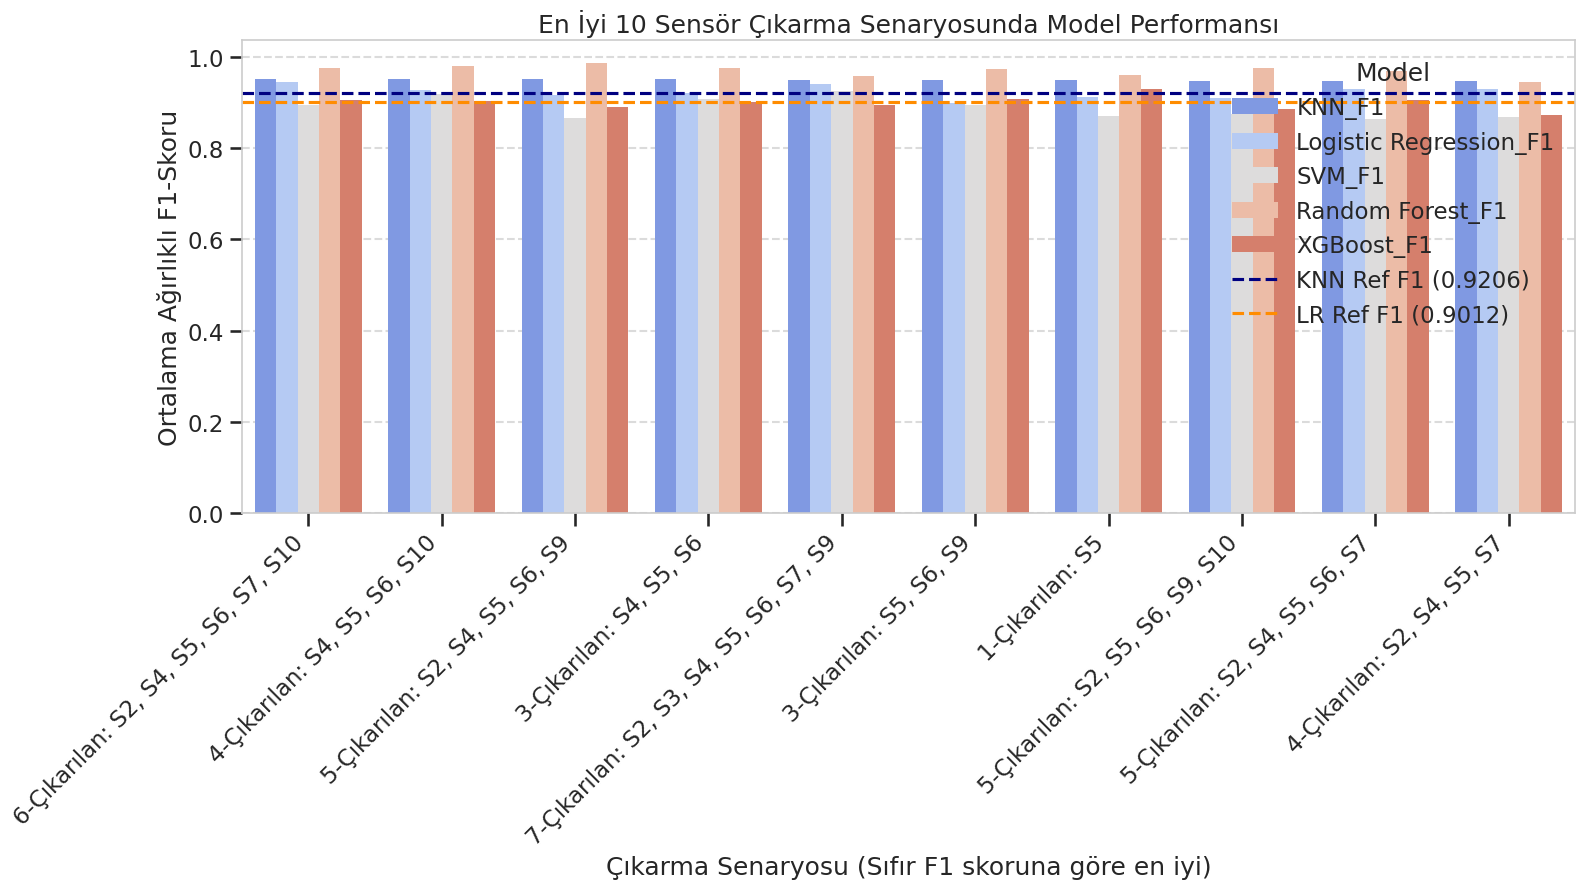



Analiz tamamlandı. En iyi performansı koruyan veya artıran kombinasyonlar belirlendi.


In [30]:
import pandas as pd
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time # Süre takibi için

# --- 1. SABİT TANIMLAMALAR ---
# features_df_new_norm'un bu yeni egzersiz verilerini içerdiği varsayılır.

# Orijinal Veri Kümesi Özellikleri ve Etiketleri
X_base = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_base = features_df_new_norm['label']
groups_base = features_df_new_norm['user']

le = LabelEncoder().fit(y_str_base)
y_base = le.transform(y_str_base)
logo = LeaveOneGroupOut()

# Modelleri tanımla (Sadece en iyi 3 veya 4 modeli seçerek süreyi kısaltabiliriz)
MODELS = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

# Analiz edilecek tüm sensörler
ALL_SENSORS_KEYS = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
# Bağıl özellikler (Rel) özel olarak ele alınacaktır.
REL_FEATURES = [col for col in X_base.columns if col.startswith('rel_')]

# --- 2. DENEME SENARYOLARINI OLUŞTURMA ---

test_scenarios = []

# Başlangıç Senaryosu (Tüm Sensörler, Referans Değer)
test_scenarios.append({
    "Scenario": "0-REFERANS (Tümü)",
    "Sensors_Removed": "Hiçbiri",
    "Columns_Removed": []
})

# Bağıl (Rel) Özellikleri Çıkarma
test_scenarios.append({
    "Scenario": "1-Çıkarılan: REL (Bağıl Özellikler)",
    "Sensors_Removed": "REL",
    "Columns_Removed": REL_FEATURES
})

# Kombinasyon Senaryolarını Oluşturma
# Sadece çıkarma gruplarına odaklanıyoruz (1'li'den 5'li'ye)
for group_size in range(1, 10): # 1'den 5'e kadar grup büyüklükleri
    
    # Tüm olası kombinasyonları al
    all_combinations = list(itertools.combinations(ALL_SENSORS_KEYS, group_size))
    
    # Çok fazla kombinasyon varsa, maksimum 50 tanesini rastgele seç
    max_samples = 200000
    if len(all_combinations) > max_samples:
        selected_combinations = random.sample(all_combinations, max_samples)
    else:
        selected_combinations = all_combinations

    for group in selected_combinations:
        group_str = ", ".join(group).upper()
        
        # Çıkarılacak sütunları oluştur
        cols_to_remove = []
        for sensor_key in group:
            cols_to_remove.extend([col for col in X_base.columns if col.startswith(f'{sensor_key}_')])
        
        test_scenarios.append({
            "Scenario": f"{group_size}-Çıkarılan: {group_str}",
            "Sensors_Removed": group_str,
            "Columns_Removed": cols_to_remove
        })

# --- 3. LOGO CV FONKSİYONU ---

def run_logo_cv(X_df, y_arr, groups_arr, models):
    """Verilen X, y ve gruplar üzerinde LOGO CV uygulayarak F1 skorlarını döndürür."""
    results = {name: [] for name in models.keys()}
    
    # Orijinal kodunuzdaki gibi LOGO CV uygulamasını koruyoruz.
    for train_idx, test_idx in logo.split(X_df, y_arr, groups_arr):
        X_train, X_test = X_df.iloc[train_idx], X_df.iloc[test_idx]
        y_train, y_test = y_arr[train_idx], y_arr[test_idx]
        
        # Standardizasyon
        scaler = StandardScaler().fit(X_train)
        X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred, average="weighted")
            results[name].append(f1)
            
    # Ortalama F1 skorlarını hesapla
    avg_f1_scores = {name: np.mean(scores) for name, scores in results.items()}
    return avg_f1_scores

# --- 4. ANALİZİN BAŞLATILMASI ---

analysis_results = []
total_scenarios = len(test_scenarios)

print(f"Toplam {total_scenarios} farklı sensör çıkarma senaryosu test edilecek (Her model için {len(groups_base)} katlama). Bu süreç zaman alabilir.")
print("-" * 80)

start_time = time.time()

for idx, scenario in enumerate(test_scenarios):
    scenario_name = scenario["Scenario"]
    cols_to_drop = scenario["Columns_Removed"]
    
    # Yeni X_df oluştur
    X_current = X_base.drop(cols_to_drop, axis=1, errors='ignore')
    
    # Senaryo ilerlemesini takip et
    print(f"[{idx + 1}/{total_scenarios}] Deneniyor: {scenario_name} | Kalan Özellik Sayısı: {X_current.shape[1]}")
    
    # LOGO CV çalıştır ve F1 skorlarını al
    f1_scores = run_logo_cv(X_current, y_base, groups_base, MODELS)
    
    # Sonuçları kaydet
    result_row = {
        "Senaryo": scenario_name,
        "Çıkarılan Sensörler": scenario["Sensors_Removed"],
        "Kalan Özellik Sayısı": X_current.shape[1],
        **{f"{k}_F1": v for k, v in f1_scores.items()}
    }
    analysis_results.append(result_row)
    
end_time = time.time()
print("-" * 80)
print(f"Tüm analiz {end_time - start_time:.2f} saniyede tamamlandı.")

# --- 5. SONUÇLARIN ÖZETLENMESİ VE GÖRSELLEŞTİRİLMESİ ---

summary_df = pd.DataFrame(analysis_results)

# Referans skorları al
reference_row = summary_df[summary_df['Senaryo'] == '0-REFERANS (Tümü)'].iloc[0]

# Performans Değişimini Hesapla
for model_name in MODELS.keys():
    f1_col = f"{model_name}_F1"
    ref_f1 = reference_row[f1_col]
    
    # Yüzdelik değişim
    summary_df[f"{model_name}_Change (%)"] = ((summary_df[f1_col] - ref_f1) / ref_f1) * 100
    
    # Değişim yüzdesini görselleştirmek için 2 ondalık hane formatı
    summary_df[f"{model_name}_Change (%)"] = summary_df[f"{model_name}_Change (%)"].map('{:.2f}%'.format)

# Sütunları düzenle
final_columns = ["Senaryo", "Çıkarılan Sensörler", "Kalan Özellik Sayısı"] + \
                [col for col in summary_df.columns if col.endswith('_F1')] + \
                [col for col in summary_df.columns if col.endswith('Change (%)')]

# Sonuçları F1 skoruna göre sırala (Örn: En iyi genelleyici olan KNN F1 skoruna göre)
final_summary = summary_df[final_columns].sort_values(by="KNN_F1", ascending=False).reset_index(drop=True)

print("\n\n############################################################")
print("## 🚀 KAPSAMLI SENSÖR ÇIKARMA ANALİZİ SONUÇLARI (Genişletilmiş) ##")
print("############################################################\n")
print(final_summary.to_string())

# --- Sonuçların Görselleştirilmesi (Top 10 En İyi Senaryo) ---

# Sadece F1 skoru en yüksek 10 senaryoyu al (Referans hariç)
top_n = 10
top_scenarios = final_summary.drop(0).head(top_n).copy() 

# Grafiğe uygun formata dönüştür
plot_data_melt = top_scenarios.melt(id_vars='Senaryo', 
                                    value_vars=[f"{m}_F1" for m in MODELS.keys()],
                                    var_name='Model', 
                                    value_name='Average F1-Score')

plt.figure(figsize=(16, 9))
sns.barplot(x='Senaryo', y='Average F1-Score', hue='Model', data=plot_data_melt, palette="coolwarm")
plt.axhline(y=reference_row['KNN_F1'], color='navy', linestyle='--', label=f"KNN Ref F1 ({reference_row['KNN_F1']:.4f})")
plt.axhline(y=reference_row['Logistic Regression_F1'], color='darkorange', linestyle='--', label=f"LR Ref F1 ({reference_row['Logistic Regression_F1']:.4f})")
plt.title(f'En İyi {top_n} Sensör Çıkarma Senaryosunda Model Performansı', fontsize=18)
plt.ylabel('Ortalama Ağırlıklı F1-Skoru')
plt.xlabel('Çıkarma Senaryosu (Sıfır F1 skoruna göre en iyi)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n\nAnaliz tamamlandı. En iyi performansı koruyan veya artıran kombinasyonlar belirlendi.")

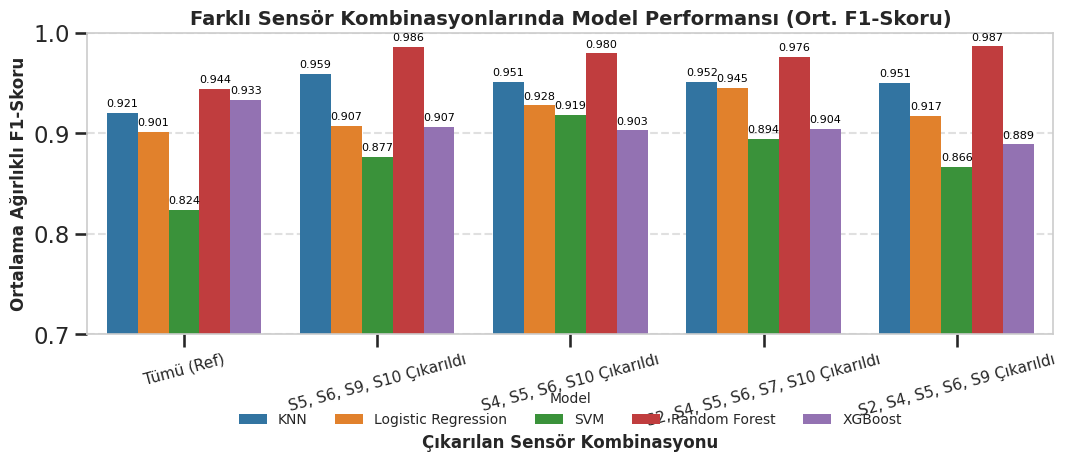

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Örnek Veri (Önceki Analizinizden Alınmıştır) ===
# Senaryolar: 5 farklı sensör kombinasyonunda elde edilen Ortalama F1-Skorları
data = {
    'Model': [
        'KNN', 'KNN', 'KNN', 'KNN', 'KNN',
        'Logistic Regression', 'Logistic Regression', 'Logistic Regression', 'Logistic Regression', 'Logistic Regression',
        'SVM', 'SVM', 'SVM', 'SVM', 'SVM',
        'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest',
        'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost'
    ],
    'Kombinasyon': [
        'Tümü (Ref)', 'S5, S6, S9, S10 Çıkarıldı', 'S4, S5, S6, S10 Çıkarıldı', 'S2, S4, S5, S6, S7, S10 Çıkarıldı', 'S2, S4, S5, S6, S9 Çıkarıldı',
        'Tümü (Ref)', 'S5, S6, S9, S10 Çıkarıldı', 'S4, S5, S6, S10 Çıkarıldı', 'S2, S4, S5, S6, S7, S10 Çıkarıldı', 'S2, S4, S5, S6, S9 Çıkarıldı',
        'Tümü (Ref)', 'S5, S6, S9, S10 Çıkarıldı', 'S4, S5, S6, S10 Çıkarıldı', 'S2, S4, S5, S6, S7, S10 Çıkarıldı', 'S2, S4, S5, S6, S9 Çıkarıldı',
        'Tümü (Ref)', 'S5, S6, S9, S10 Çıkarıldı', 'S4, S5, S6, S10 Çıkarıldı', 'S2, S4, S5, S6, S7, S10 Çıkarıldı', 'S2, S4, S5, S6, S9 Çıkarıldı',
        'Tümü (Ref)', 'S5, S6, S9, S10 Çıkarıldı', 'S4, S5, S6, S10 Çıkarıldı', 'S2, S4, S5, S6, S7, S10 Çıkarıldı', 'S2, S4, S5, S6, S9 Çıkarıldı'
    ],
    # F1 Skorları (Önceki yanıttan alınan örnek verilerdir)
    'F1_Score': [
        0.9206, 0.9592, 0.9513, 0.9515, 0.9505,
        0.9012, 0.9075, 0.9278, 0.9450, 0.9172,
        0.8237, 0.8768, 0.9186, 0.8942, 0.8664,
        0.9439, 0.9864, 0.9797, 0.9761, 0.9867,
        0.9334, 0.9067, 0.9030, 0.9042, 0.8890
    ]
}

df = pd.DataFrame(data)

# Kombinasyonları ve Modelleri sıralama
combination_order = [
    'Tümü (Ref)',
    'S5, S6, S9, S10 Çıkarıldı',
    'S4, S5, S6, S10 Çıkarıldı',
    'S2, S4, S5, S6, S7, S10 Çıkarıldı',
    'S2, S4, S5, S6, S9 Çıkarıldı'
]
model_order = ['KNN', 'Logistic Regression', 'SVM', 'Random Forest', 'XGBoost']

df['Kombinasyon'] = pd.Categorical(df['Kombinasyon'], categories=combination_order, ordered=True)
df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)


# === 2. Grafik Ayarları ===
cm_to_inch = 1/2.54
figure_width_cm = 28  # Genişletildi
figure_height_cm = 12

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'font.size': 10,
    'axes.linewidth': 1.2,
})

# === 3. Grafik Çizimi ===
fig, ax = plt.subplots(figsize=(figure_width_cm * cm_to_inch, figure_height_cm * cm_to_inch))

# Renk paleti: Her model için farklı bir renk
palette = 'tab10' 

sns.barplot(
    data=df,
    x='Kombinasyon',
    y='F1_Score',
    hue='Model',            # Modeller gruplanmış çubuklar olacak
    palette=palette,
    ax=ax
)

# === 4. Barların Üzerine Değer Yazma ===
y_max_limit = 1
ax.set_ylim(0.7, y_max_limit) # Görünürlüğü artırmak için Y ekseni 0.8'den başlatıldı

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{height:.3f}",  # F1 skoru 3 ondalık hane formatı
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', 
                    fontsize=8, color='black', xytext=(0, 3), 
                    textcoords='offset points')

# === 5. Stil Ayarları ===
ax.set_title("Farklı Sensör Kombinasyonlarında Model Performansı (Ort. F1-Skoru)", fontweight='bold', fontsize=14)
ax.set_ylabel("Ortalama Ağırlıklı F1-Skoru", fontweight='bold', fontsize=12)
ax.set_xlabel("Çıkarılan Sensör Kombinasyonu", fontweight='bold', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6) # Izgara çizgisi eklendi

plt.xticks(rotation=15, ha='center', fontsize=11)
ax.legend(title="Model", fontsize=10, title_fontsize=10, 
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,
    frameon=False)

# === 6. Kaydetme ===
plt.tight_layout()
plt.savefig("single_grouped_bar_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

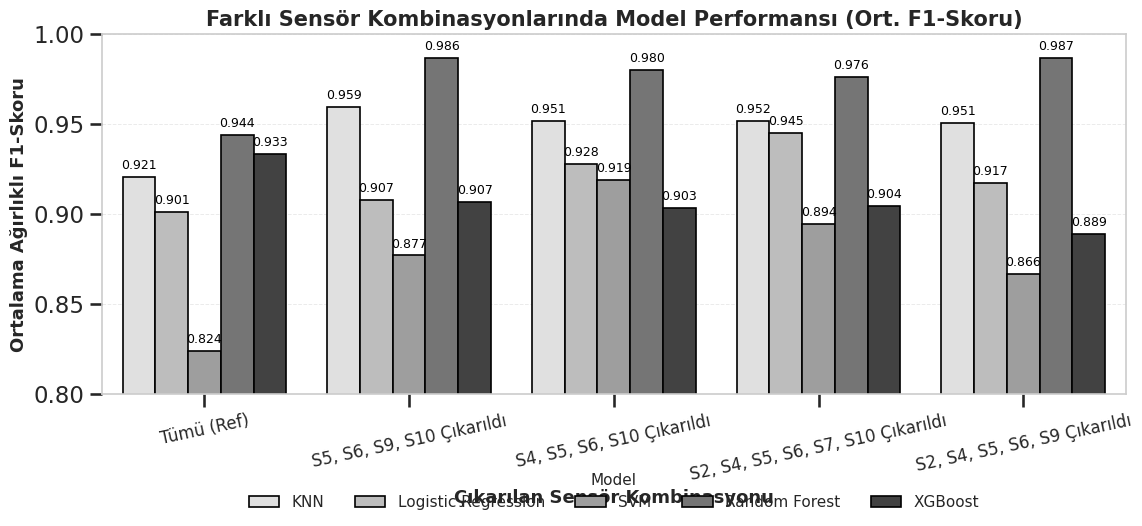

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Veri ===
df = pd.DataFrame(data)

df['Kombinasyon'] = pd.Categorical(df['Kombinasyon'], categories=combination_order, ordered=True)
df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)

# === Şekil Boyutu ===
cm_to_inch = 1/2.54
fig, ax = plt.subplots(figsize=(30 * cm_to_inch, 14 * cm_to_inch))

# === Stil ===
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 11,
    'axes.linewidth': 1.2,
})

# === Güçlü Gri Tonlu Palette (yüksek kontrast) ===
# En net fark için özel gri paleti
palette = ["#e0e0e0", "#bdbdbd", "#9e9e9e", "#757575", "#424242"]

# === Barplot ===
sns.barplot(
    data=df,
    x='Kombinasyon',
    y='F1_Score',
    hue='Model',
    palette=palette,
    edgecolor='black',
    linewidth=1.2,
    ax=ax
)

# === Y Ekseni 0–1 aralığı ===
ax.set_ylim(0.8, 1.0)

# === Değer Etiketleri ===
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center',
                va='bottom',
                fontsize=9,
                color='black',
                xytext=(0, 4),
                textcoords='offset points')

# === Ekseni ve Başlıklar ===
ax.set_title("Farklı Sensör Kombinasyonlarında Model Performansı (Ort. F1-Skoru)",
             fontweight='bold', fontsize=15)

ax.set_ylabel("Ortalama Ağırlıklı F1-Skoru", fontweight='bold', fontsize=13)
ax.set_xlabel("Çıkarılan Sensör Kombinasyonu", fontweight='bold', fontsize=13)

# === X etiketlerini iyileştir ===
plt.xticks(rotation=12, ha='center', fontsize=12)

# === Izgara ===
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.4)

# === Legend ===
ax.legend(
    title="Model",
    fontsize=11,
    title_fontsize=11,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=5,
    frameon=False
)

plt.tight_layout()
plt.savefig("improved_grayscale_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
